# Case Study 2: Predict Success of New Product Launch

Goal: Is a product going to be successful ?

Method: Predict Market Share of the firm 1 year after launch.

* [Data Exploration](#data-exploration)
* [Pre Processing](#preprocessing)
* [Training](#training)
* [Evaluation](#evaluation)
* [Scoring](#scoring)



## Data Exploration <a class="anchor" id="data-exploration"></a>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import re
import numpy as np
%matplotlib inline

from sklearn import feature_selection
import category_encoders as ce

In [3]:
# load data
df_case = pd.read_excel('./use_case_data.xlsx')
df_case.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716 entries, 0 to 1715
Data columns (total 40 columns):
REGION                    1716 non-null object
MARKET                    1716 non-null object
BRM                       1716 non-null object
BLDIMAGE                  1716 non-null object
BRANDDIFFERENTIATOR       1716 non-null object
BRANDFAMILY               1716 non-null object
BRANDONMARKET             1716 non-null object
BRANDSUBFAMILY            1716 non-null object
BRANDSUBFAMILYGROUP       1716 non-null object
BRANDSUBFAMILYGROUPING    1716 non-null object
BRANDSUBFAMILYLINE        1716 non-null object
CHARINDICATOR             1716 non-null object
BRMID                     1716 non-null int64
INDICATOR                 1716 non-null object
RTYPE                     473 non-null object
INTERNATIONALINDICATOR    1716 non-null object
ISREPLACEMENT             1716 non-null object
ISSTRATEGIC               1716 non-null object
ITEMSHAPE                 804 non-null object
ITE

In [68]:
for col in df_case.columns:
    print('-'*10+col+'-'*10)
    print(df_case[col].value_counts()) 

----------REGION----------
REGION3    643
REGION2    569
REGION1    264
REGION4    240
Name: REGION, dtype: int64
----------MARKET----------
MARKET112    52
MARKET25     46
MARKET42     45
MARKET51     44
MARKET95     41
MARKET108    40
MARKET87     38
MARKET92     36
MARKET15     34
MARKET58     34
MARKET7      32
MARKET70     32
MARKET53     31
MARKET31     31
MARKET96     30
MARKET38     29
MARKET91     29
MARKET60     28
MARKET6      28
MARKET111    26
MARKET5      25
MARKET23     25
MARKET98     25
MARKET14     23
MARKET89     23
MARKET41     23
MARKET93     23
MARKET104    22
MARKET22     22
MARKET56     22
             ..
MARKET73      5
MARKET4       5
MARKET83      4
MARKET9       4
MARKET78      4
MARKET57      4
MARKET2       3
MARKET47      3
MARKET115     3
MARKET107     3
MARKET109     3
MARKET50      2
MARKET3       2
MARKET46      2
MARKET68      2
MARKET43      2
MARKET44      1
MARKET35      1
MARKET116     1
MARKET66      1
MARKET34      1
MARKET110     1
MARKET79   

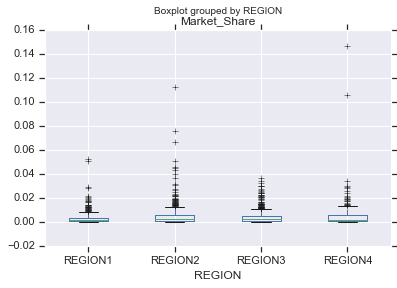

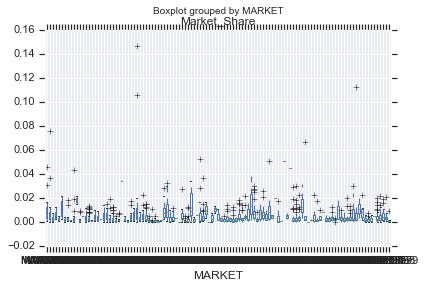

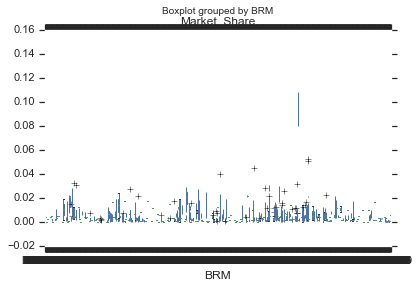

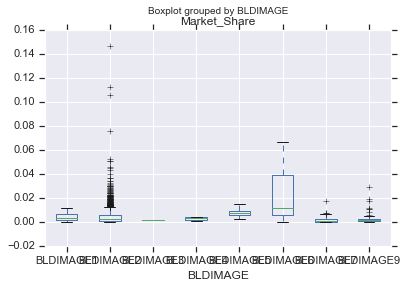

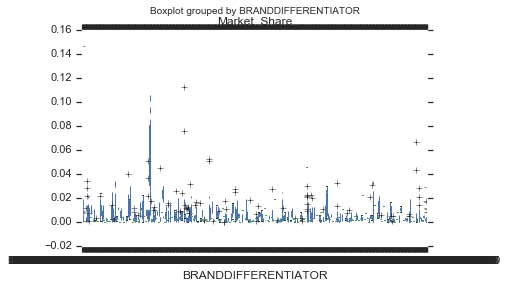

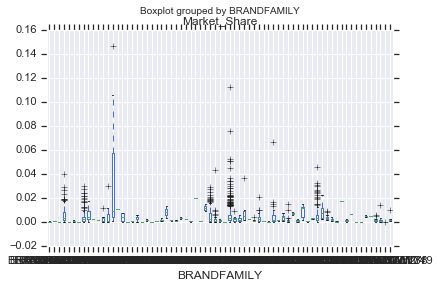

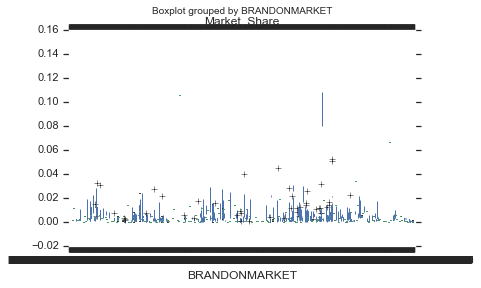

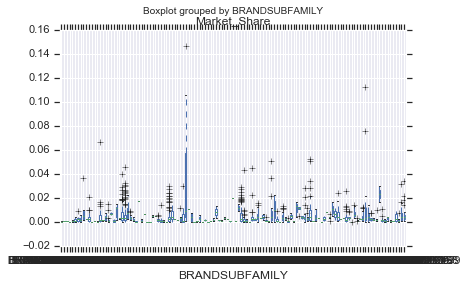

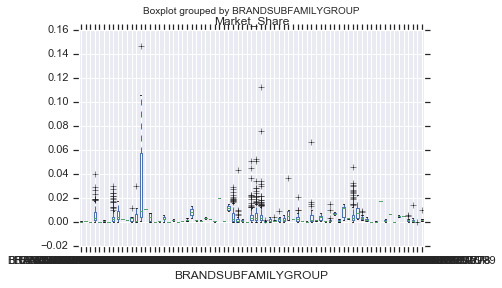

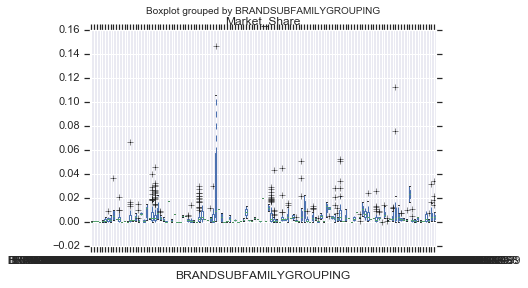

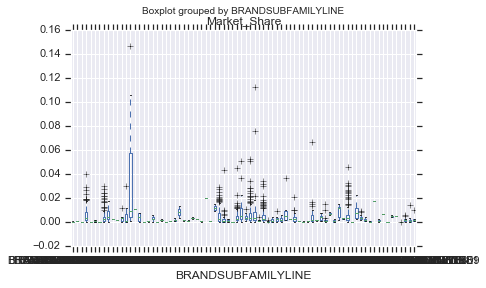

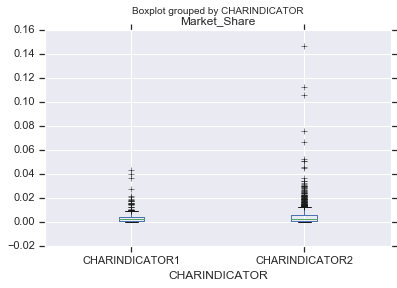

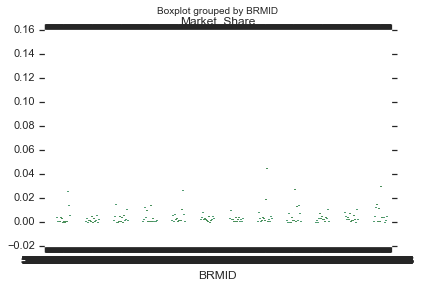

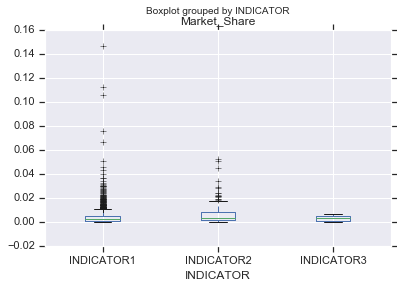

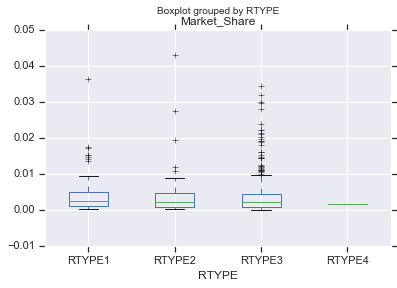

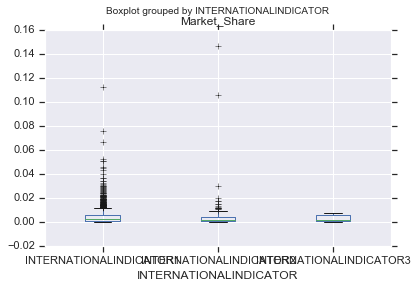

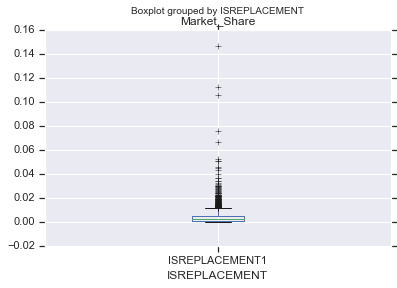

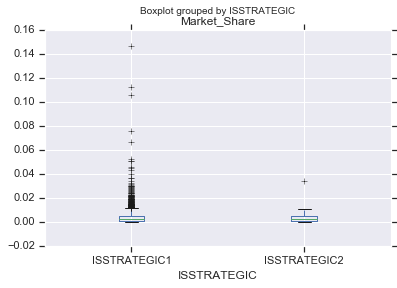

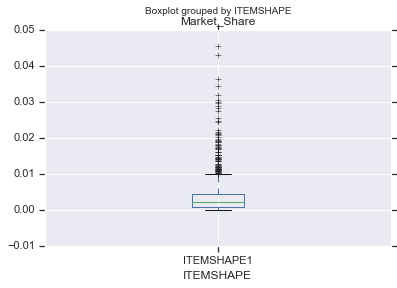

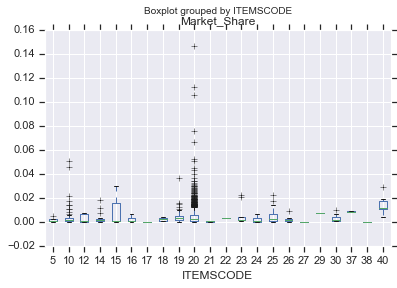

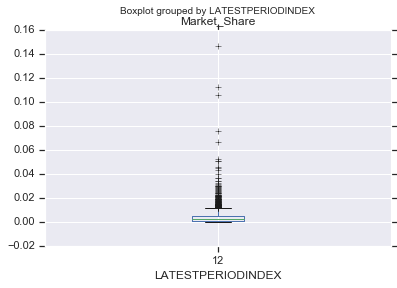

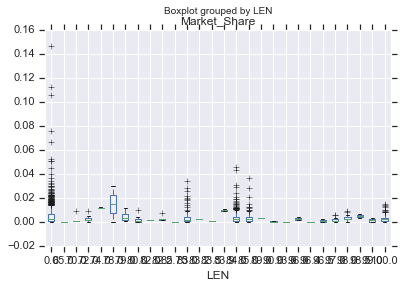

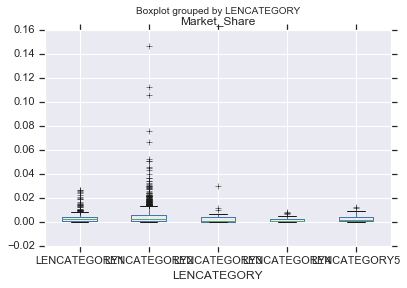

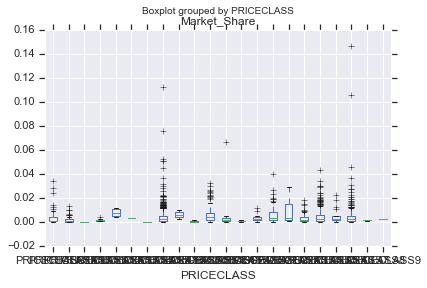

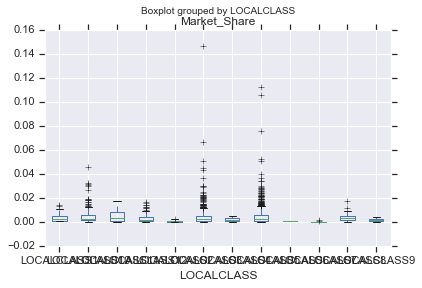

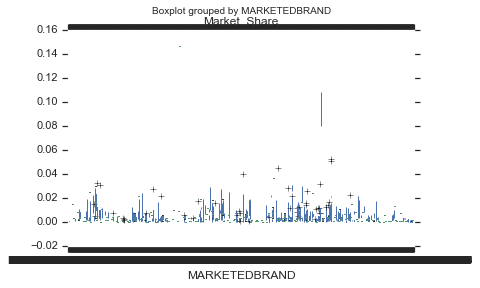

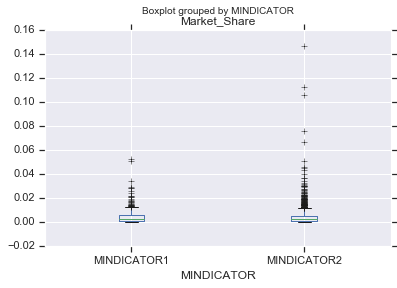

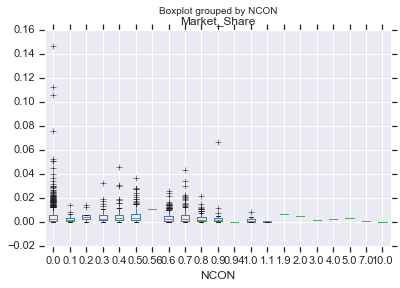

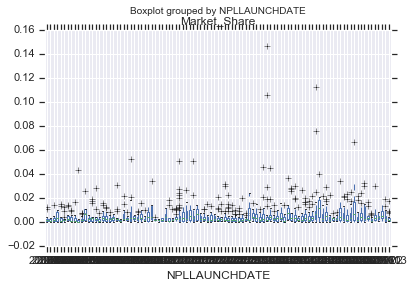

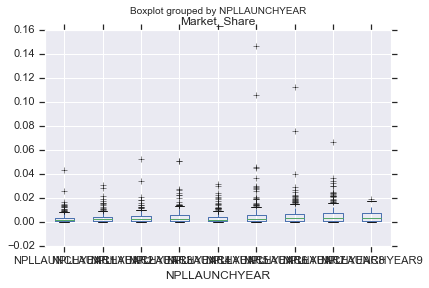

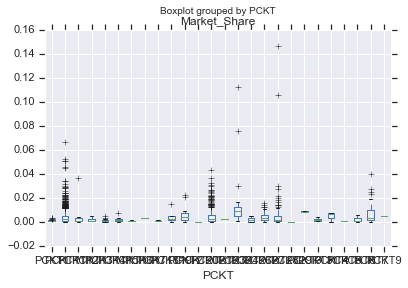

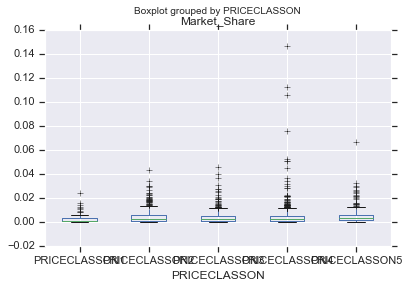

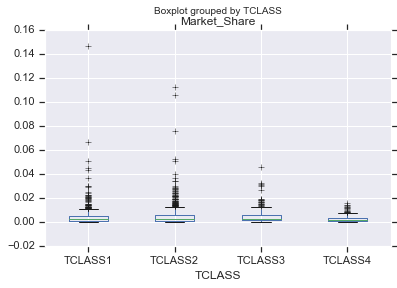

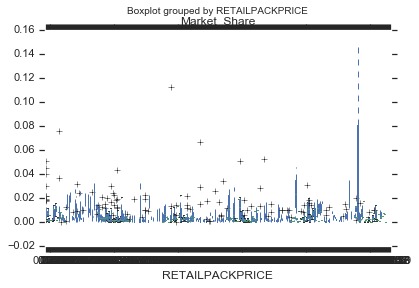

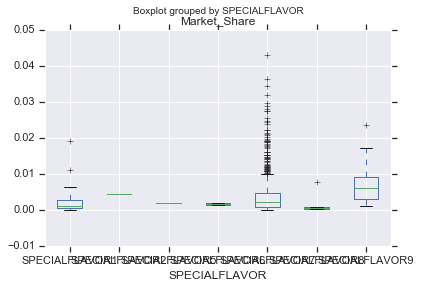

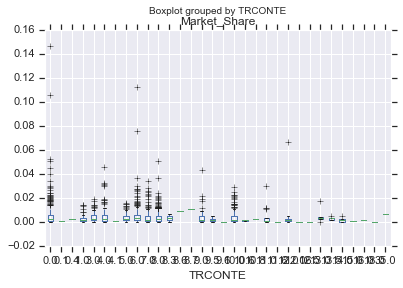

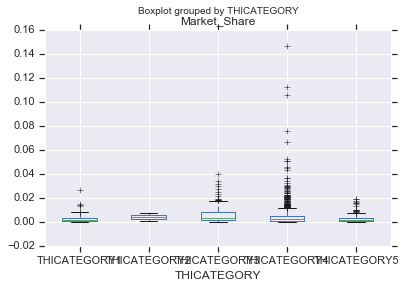

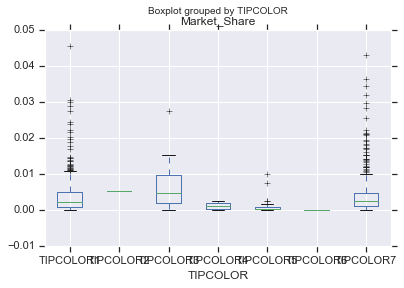

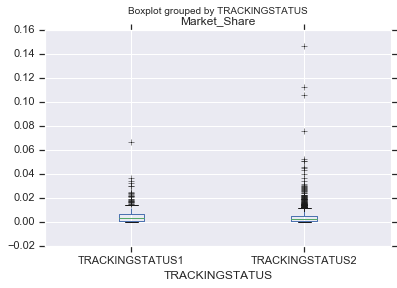

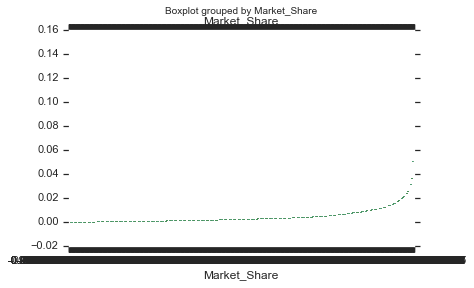

In [4]:
for col in df_case.columns:
    plt.figure(figsize=(15,10))
    df_case.boxplot('Market_Share', by=col)
    plt.show()

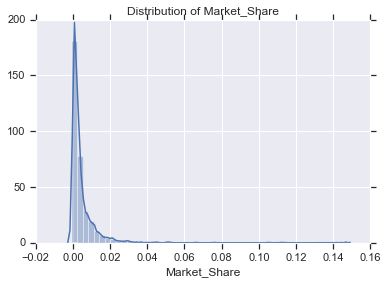

In [5]:
sns.distplot(df_case['Market_Share'])
plt.title('Distribution of Market_Share')
plt.savefig('image/Market_Share_dist.jpg')
plt.show()

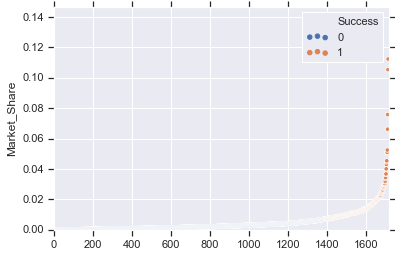

Success rate: 18.939394 %


In [6]:
# create label
threshold = 0.007
df_label = df_case.copy()
df_label['Success'] = np.where(df_case['Market_Share'] > threshold, 1, 0)
df_label = df_label.sort_values(by='Market_Share')

# Plot the success rate and market distribution sorted
g = sns.scatterplot(x=range(len(df_label)), y='Market_Share', data=df_label, hue='Success')
g.set(ylim=(0, max(df_case['Market_Share'])))
g.set(xlim=(0, len(df_label)))
plt.show()

print('Success rate: {:2f} %'.format(df_label['Success'].sum()/len(df_label)*100))

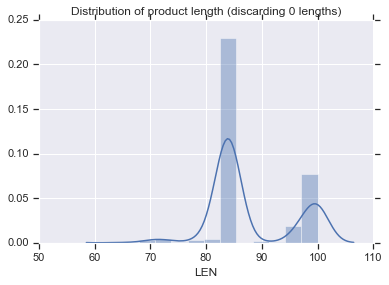

In [7]:
sns.distplot(df_case[df_case['LEN'] != 0]['LEN'])
plt.title('Distribution of product length (discarding 0 lengths)')
plt.savefig('image/LEN_dist.png')
plt.show()

Given the context of the use case, we are most likely dealing with PMI brand/flavor/product launches. The LEN feature describes the length of cigarettes ["The length varies from what is known as King Size (84 mm) to 100s (100 mm)."](https://en.wikipedia.org/wiki/Cigarette#Construction).  
Features understanding:
- REGION: one of the four continents (could be inferred from distributions)
- MARKET: countries/market where product is launched
- BRANDFAMILY(LINE/GROUP/..): L&M, Marlboro, Philip Morris etc..., Group/Line could be Gold, Blue, Light etc...
- BLDIMAGE: Image (blend?) related on the package
- INDICATOR: Indication on packages (i.e. warnings and/or cigarete content)
- NPLLAUNCHDATE: New Product Launch date: year concatenated with month (+category)
- RETAILPACKPRICE: Packet price in local currency (category referring to range standardized or currency)
- SECIALFLAVOR: raspberry, violet etc... (i.e. additives)
- ITEMSHAPE: shape of packet
- TIPCOLOR: Color of the cigarette butt or packet

Possible features may involve filter, paper, tobacco blend, additives category and other marketing insights.

## Pre Processing <a class="anchor" id="preprocessing"></a>

Key aspect of this business use case is the categorical data. In order to be processed we need to encode these categories.
This encoding will depend on whether the category is nominal or ordinal (if we can arrange in a sorting order). 

In [8]:
def rmvText(word):
    '''Return numerics only in a word'''
    if word is not np.nan:
        matches = re.findall('\d+', word)
        if len(matches) == 1:
            return np.int_(matches[0])
        else:
            print('Multiple or 0 num values found')
            return matches
    else:
        return word
    

In [9]:
# Remove text in dataframe for categories
df_nums = df_case.select_dtypes(include=['object']).applymap(rmvText)
categories = df_nums.columns
df_no_text = df_case.copy()
df_no_text.update(df_nums)
for col in categories:
    df_no_text[col] = df_no_text[col].astype('category')
df_no_text.head()

REGION MARKET BRM BLDIMAGE BRANDDIFFERENTIATOR BRANDFAMILY BRANDONMARKET  \
0      1      7  36        9                  98          12            36   
1      1      7  37        9                  98          12            37   
2      1      7  38        9                  98          12            38   
3      1      7  58        9                 267          12            58   
4      1      7  73        9                 467          12            73   

  BRANDSUBFAMILY BRANDSUBFAMILYGROUP BRANDSUBFAMILYGROUPING      ...       \
0             12                  12                     12      ...        
1             12                  12                     12      ...        
2             12                  12                     12      ...        
3             12                  12                     12      ...        
4             12                  12                     12      ...        

  PCKT PRICECLASSON  TCLASS RETAILPACKPRICE SPECIALFLAVOR TRCONTE THICATEGORY  \
0   11            2       2           15.00           7.0    10.0           4   
1   11            2       2           19.55           7.0    10.0           4   
2   11            2       2           27.00           7.0    10.0           4   
3   11            2       2           29.25           7.0     8.0           4   
4   11            2       2           15.00           7.0    11.0           4   

  TIPCOLOR TRACKINGSTATUS  Market_Share  
0      1.0              2      0.001440  
1      1.0              2      0.002881  
2      1.0              2      0.028870  
3      1.0              2      0.018922  
4      1.0              2      0.000928  

[5 rows x 40 columns]

In [10]:
for col in df_no_text.columns:
    df_no_text[col] = df_no_text[col].astype('float')

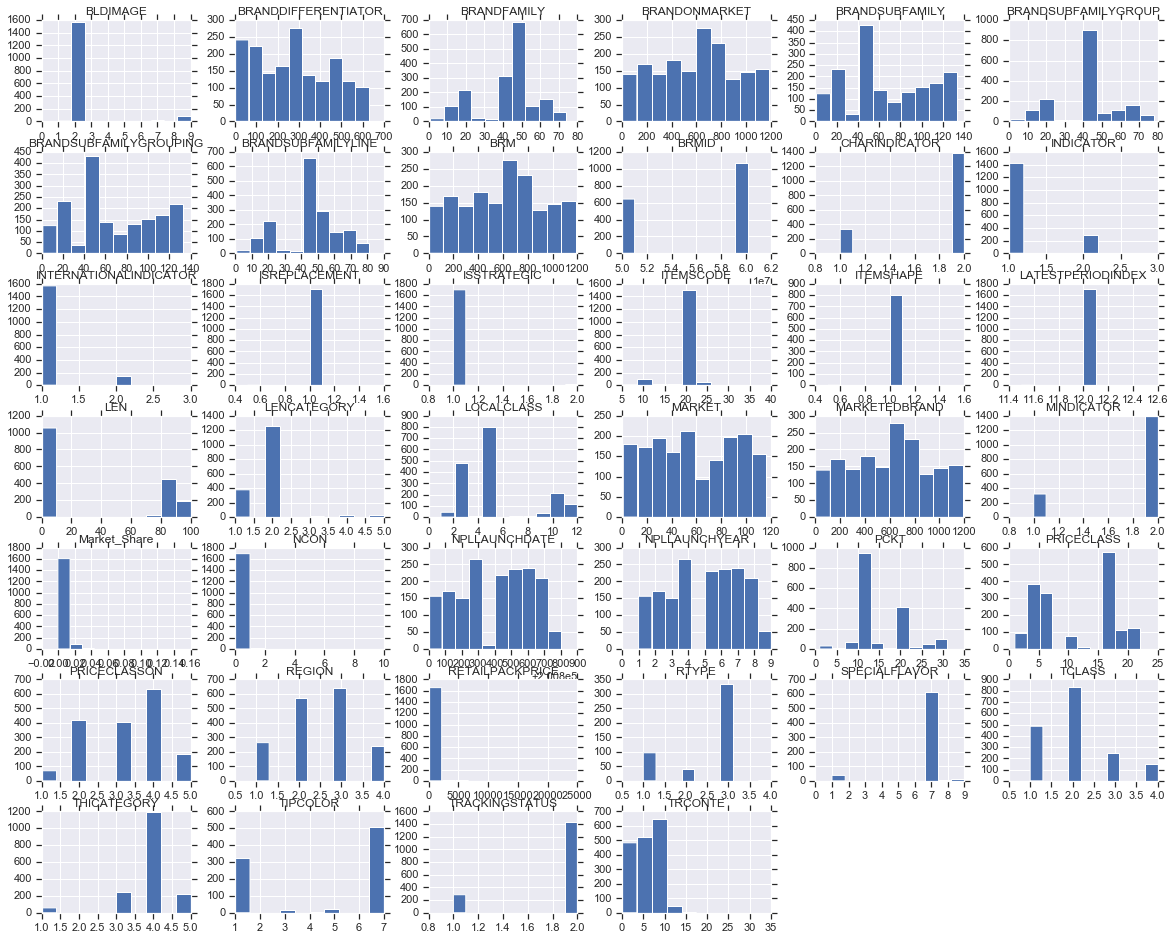

In [11]:
df_no_text.hist(figsize=(20, 16))
plt.show()

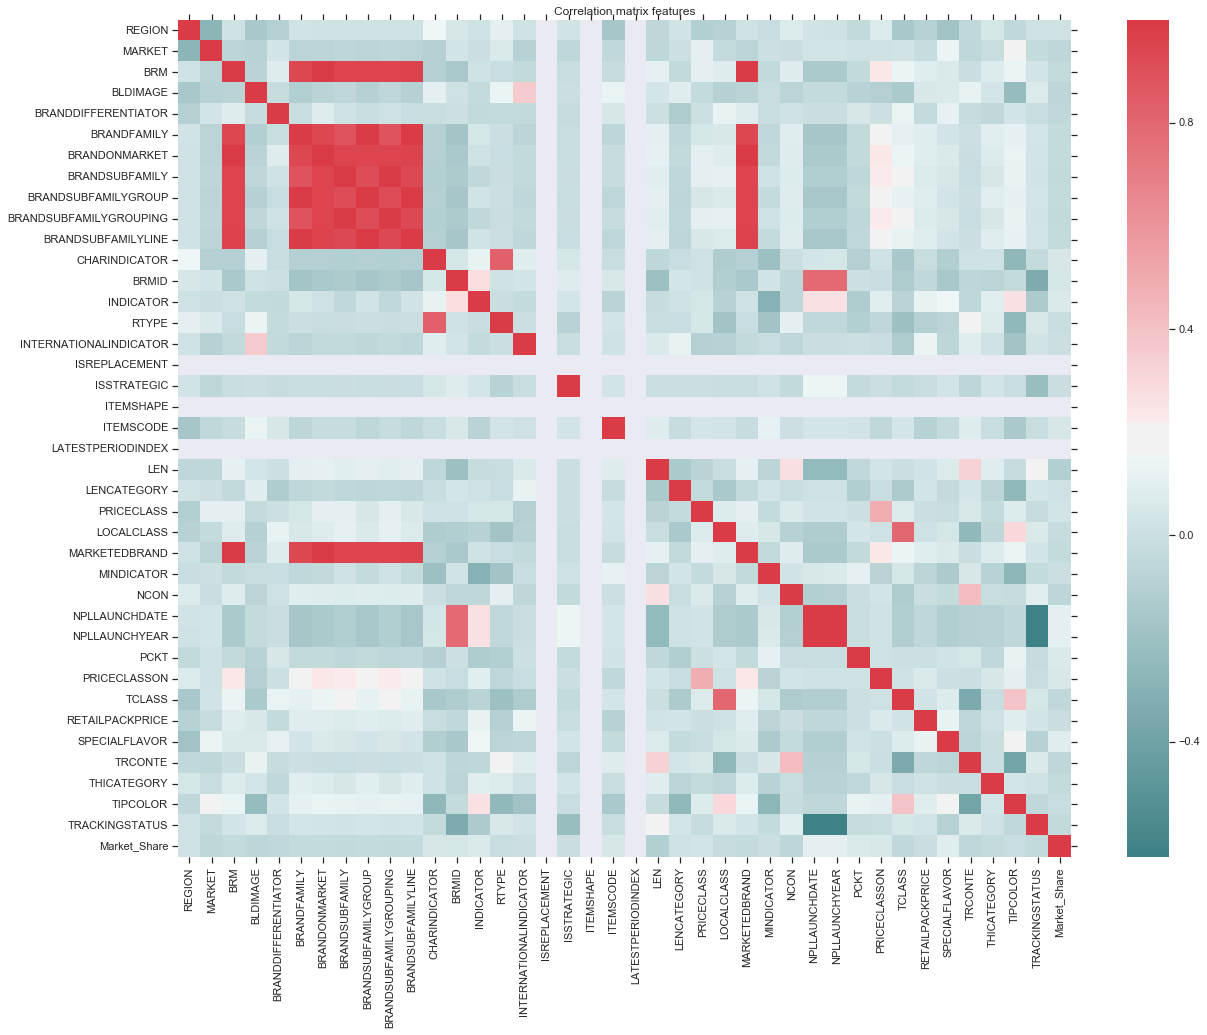

x                       y      corr
0                      BRM           BRANDONMARKET  0.999999
1                      BRM          BRANDSUBFAMILY  0.953794
2                      BRM     BRANDSUBFAMILYGROUP  0.953629
3                      BRM  BRANDSUBFAMILYGROUPING  0.953794
4                      BRM      BRANDSUBFAMILYLINE  0.961794
5                      BRM           MARKETEDBRAND  0.999999
6              BRANDFAMILY     BRANDSUBFAMILYGROUP  0.997816
7              BRANDFAMILY      BRANDSUBFAMILYLINE  0.993806
8            BRANDONMARKET          BRANDSUBFAMILY  0.953794
9            BRANDONMARKET     BRANDSUBFAMILYGROUP  0.953629
10           BRANDONMARKET  BRANDSUBFAMILYGROUPING  0.953794
11           BRANDONMARKET      BRANDSUBFAMILYLINE  0.961794
12           BRANDONMARKET           MARKETEDBRAND  1.000000
13          BRANDSUBFAMILY  BRANDSUBFAMILYGROUPING  1.000000
14          BRANDSUBFAMILY           MARKETEDBRAND  0.953796
15     BRANDSUBFAMILYGROUP      BRANDSUBFAMILYLINE  0.998661
16     BRANDSUBFAMILYGROUP           MARKETEDBRAND  0.953630
17  BRANDSUBFAMILYGROUPING           MARKETEDBRAND  0.953796
18      BRANDSUBFAMILYLINE           MARKETEDBRAND  0.961796
19           NPLLAUNCHDATE           NPLLAUNCHYEAR  0.999891

In [12]:
# Compute mutual correlations
corr = df_no_text.corr()

def dispCorr(corr):
    # Plot correlation matrix
    plt.subplots(figsize=(20,15))
    sns.heatmap(corr, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values, cmap=sns.diverging_palette(200, 10,as_cmap=True))
    plt.title('Correlation matrix features')
    plt.show()
    
    # Display highly correlated features
    features = set()
    df_hcorr = pd.DataFrame(columns=['x', 'y', 'corr'])
    for col in corr:
        features.add(col)
        for row in corr:
            correlation = corr.loc[row, col]
            if (row not in features and (abs(correlation) > 0.95)):
                df_hcorr = df_hcorr.append(pd.Series({'x': col,'y': row,'corr': correlation}), ignore_index=True)
    return df_hcorr

dispCorr(corr)

In [13]:
def listDiff(row):
    print('---', row['x'], row['y'], row['corr'],'---')
    idx = df_no_text[row['x']] != df_no_text[row['y']]
    print(idx.sum(), 'rows strictly different')
    #print(df_no_text[idx])

In [80]:
df_hcorr.apply(listDiff, axis=1)

--- BRM BRANDONMARKET 0.999999233623944 ---
17 rows strictly different
--- BRM BRANDSUBFAMILY 0.9537942412863172 ---
1715 rows strictly different
--- BRM BRANDSUBFAMILYGROUP 0.9536287463503402 ---
1715 rows strictly different
--- BRM BRANDSUBFAMILYGROUPING 0.9537942412863172 ---
1715 rows strictly different
--- BRM BRANDSUBFAMILYLINE 0.9617937945219709 ---
1715 rows strictly different
--- BRM MARKETEDBRAND 0.99999915473874 ---
24 rows strictly different
--- BRANDFAMILY BRANDSUBFAMILYGROUP 0.9978162491522108 ---
860 rows strictly different
--- BRANDFAMILY BRANDSUBFAMILYLINE 0.9938062449259775 ---
890 rows strictly different
--- BRANDONMARKET BRANDSUBFAMILY 0.953794241286317 ---
1715 rows strictly different
--- BRANDONMARKET BRANDSUBFAMILYGROUP 0.9536287463503402 ---
1715 rows strictly different
--- BRANDONMARKET BRANDSUBFAMILYGROUPING 0.953794241286317 ---
1715 rows strictly different
--- BRANDONMARKET BRANDSUBFAMILYLINE 0.9617937945219709 ---
1715 rows strictly different
--- BRANDONMAR

0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
18    None
19    None
dtype: object

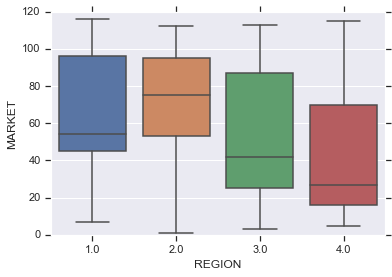

In [144]:
# Attempt to notice a numerical relationship in market numbers
sns.boxplot('REGION', 'MARKET', data=df_no_text)
plt.show()

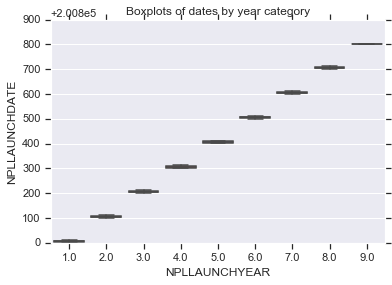

In [81]:
# plot NPL dates
sns.boxplot(x='NPLLAUNCHYEAR', y='NPLLAUNCHDATE', data=df_no_text)
plt.title('Boxplots of dates by year category')
plt.show()

Each year are encoded in an already existing category NPLLAUNCHYEAR hence let us infer a second category from the date: the month. In stock market forecasting there should not be cyclic dependency such as for weather for instance however it is important to make sure that the difference between 12 and 1 is the same than 1 and 2. Solution: $sin(2pi*X/12)$

In [14]:
# Apply cyclic value with sin(pi*X/6)
df_cyclic = df_no_text.copy()
df_cyclic['NPLLAUNCHDATE'] = np.sin(np.pi * (df_no_text['NPLLAUNCHDATE'] % 100) / 6)
df_cyclic = df_cyclic.rename(columns={'NPLLAUNCHDATE': 'NPLMONTH'})

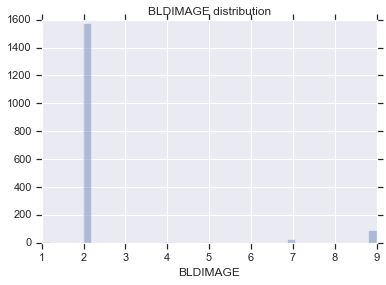

In [15]:
# Plot BLDIMAGE distribution
sns.distplot(df_cyclic['BLDIMAGE'], kde=False)
plt.title('BLDIMAGE distribution')
plt.savefig('image/BLDIMAGE.png')
plt.show()

In the case of sparsed categories, we create class grouping 95% percentile of the data observed and we create a category for others:

In [84]:
# Compute percentile
print(df_cyclic['BLDIMAGE'].value_counts())
print((1573+93)/len(df_cyclic))

2.0    1573
9.0      93
7.0      28
5.0       7
1.0       6
4.0       5
6.0       3
3.0       1
Name: BLDIMAGE, dtype: int64
0.9708624708624709


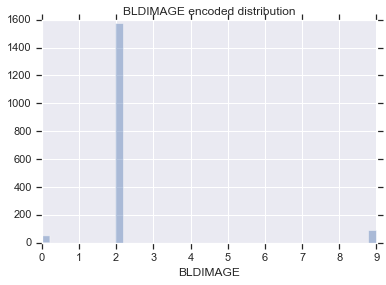

In [16]:
# Replace with a new encoded category
df_image = df_cyclic.copy()
df_image['BLDIMAGE'] = df_cyclic['BLDIMAGE'].replace({2:2, 9:9, 7:0, 5:0, 1:0, 4:0, 6:0, 3:0})
sns.distplot(df_image['BLDIMAGE'], kde=False)
plt.title('BLDIMAGE encoded distribution')
plt.savefig('image/BLDIMAGE_enc.png')
plt.show()

In [17]:
# Similar approach for ITEMSCODE
# Compute percentile
print(df_image['ITEMSCODE'].value_counts())
print((1391+101+91+35+16)/len(df_cyclic))

20.0    1391
19.0     101
10.0      91
25.0      35
14.0      16
23.0      14
30.0      10
24.0       9
16.0       8
18.0       6
40.0       6
26.0       6
12.0       5
21.0       4
5.0        4
15.0       3
37.0       2
38.0       1
22.0       1
17.0       1
29.0       1
27.0       1
Name: ITEMSCODE, dtype: int64
0.9522144522144522


In [18]:
# Replace with a new encoded category
df_code = df_image.copy()
df_code['ITEMSCODE'] = df_cyclic['ITEMSCODE'].replace([23, 30, 24, 16, 40, 26, 18, 12, 21, 5, 15, 37, 38, 17, 22, 27, 29], 0)

df_code['PCKT'] = df_code['PCKT'].replace([2, 13, 31, 19, 12, 15, 6, 26, 16, 20, 4, 17, 18, 3, 29, 9, 23, 5], 0)

Binary category are encoded to 0 or 1, e.g. CHARINDICATOR, ISSTRATEGIC, MINDICATOR, TRACKINGSTATUS.

In [19]:
# dict encoder
d = {1:0, 2:1}
cols = ['CHARINDICATOR', 'ISSTRATEGIC', 'MINDICATOR', 'TRACKINGSTATUS']

df_bins = df_code.copy()
df_bins[cols] = df_bins[cols].replace(d)

We usually remove the id column however here if we plot the distribution we can clearly see two clusters. This might bring information and hence we will encode those two clusters.

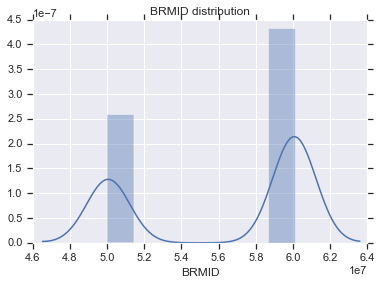

In [90]:
# Plot BRMID dist
sns.distplot(df_bins['BRMID'])
plt.title('BRMID distribution')
plt.savefig('image/BRMID_dist.png')
plt.show()

In [20]:
df_ids = df_bins.copy()
# Modulo trick to encode
df_ids['BRMID'] = (df_ids['BRMID'] / 10000000).astype(int) % 5

For the three Price-related features, we try to infer some property from visualization. Unfortunately there is no obvious relationship between them. RETAILPACKPRICE corresponds most likely to packet prices in the home country currency and hence cannot be standardize without the currency.

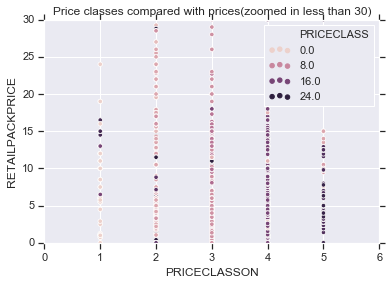

In [21]:
# scatter plot for price features
sns.scatterplot(x='PRICECLASSON', y='RETAILPACKPRICE', hue='PRICECLASS', data=df_ids)
plt.ylim((0, 30))
plt.title('Price classes compared with prices(zoomed in less than 30)')
plt.savefig('image/price.jpg')
plt.show()

# Remove local price since it cannot be standardized for the time being
df_noprice = df_ids.drop('RETAILPACKPRICE', axis=1)
df_no_text = df_noprice.copy()

### Missing Values
NaN values are located in categories. Given the amount of missing values, we assume that it has been omitted because it is not applcable to the product (e.g. a new product might not have any specific flavor). In the case of missing LEN, we associate it to the LENCATEGORY since it all corresponds to a range except few outliers (error?).

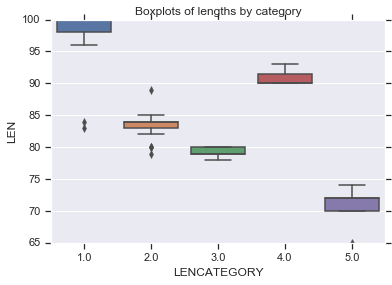

In [124]:
# plot lencategory
sns.boxplot(x='LENCATEGORY', y='LEN', data=df_no_text[df_no_text['LEN'] != 0])
plt.title('Boxplots of lengths by category')
plt.savefig('image/len_cat_boxplot.png')
plt.show()

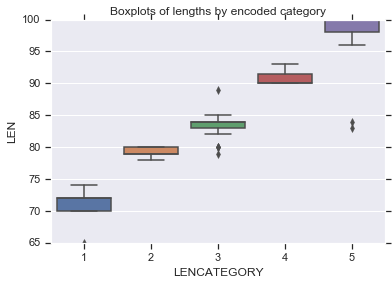

In [23]:
# Order categories
lencats_enc = {1: 5, 2:3, 3:2, 4:4, 5:1}
df_enc = df_no_text.copy()
df_enc['LENCATEGORY'] = df_enc['LENCATEGORY'].map(lencats_enc)

sns.boxplot(x='LENCATEGORY', y='LEN', data=df_enc[df_enc['LEN'] != 0])
plt.title('Boxplots of lengths by encoded category')
plt.savefig('image/len_cat_sorted.png')
plt.show()

For other numerical features, values being at 0 could be missing or set voluntarily to 0 to show that this is not applicable in the situation. Hence, we will keep 0.   
  
We have the similar situation for categorical data, however if we take SPECIALFLAVOR or TIPCOLOR NA might indicate there is no particular flavor or color respectively and then it makes sense to create a category to that end.

In [210]:
# Display classes
for col in df_no_text:
    print(col, len(df_no_text[col].unique()))
    print(df_no_text[col].unique())

REGION 4
[1. 2. 3. 4.]
MARKET 115
[  7.  41.  44.  45.  51.  54.  62.  65.  77.  82.  86.  96. 104. 106.
 116.   1.   2.   4.   6.  10.  13.  29.  34.  35.  36.  46.  48.  50.
  52.  53.  55.  56.  57.  59.  63.  67.  68.  69.  71.  72.  73.  74.
  75.  79.  81.  89.  90.  92.  93.  94.  95.  99. 103. 107. 108. 109.
 110. 111. 112.   3.   8.   9.  11.  15.  17.  18.  21.  23.  24.  25.
  26.  31.  32.  33.  37.  38.  42.  43.  47.  49.  58.  60.  61.  64.
  66.  76.  80.  87.  88.  91.  97.  98. 100. 101. 102. 113.   5.  12.
  14.  16.  19.  20.  22.  27.  28.  30.  39.  40.  70.  78.  83.  84.
  85. 114. 115.]
BRM 1099
[ 36.  37.  38. ... 929. 272. 273.]
BLDIMAGE 8
[9. 7. 2. 5. 4. 6. 1. 3.]
BRANDDIFFERENTIATOR 584
[ 98. 267. 467. 121. 148. 259.   1. 425. 493. 230. 331. 272. 307. 310.
 301. 305. 302. 515.  41.  43.  64.  84.  92.  90. 194. 308. 309. 397.
 400. 454. 459. 620. 392. 605. 606. 433. 602. 385. 237. 615. 430. 421.
  86.  88. 152. 210. 297. 303. 304. 315. 314. 316. 386. 396. 4

In [24]:
# Fill categories with a class arbitrarily set to 0
df_filled = df_no_text.fillna(0)
for cat in categories:
    df_filled[cat] = df_filled[cat].astype(int).astype('category')

### Feature Selection

First we remove all zero-variance features, i.e. features having the same value in all samples.

In [25]:
# Only keep feature with variance in sample
df_var = df_filled.columns[df_filled.var() != 0]
df_var = df_filled[df_var]
df_var.shape

(1716, 37)

In [26]:
# Split data and labels (continuous)
X = df_var.as_matrix(columns=df_var.columns[:df_var.shape[1]-1])
y = df_var['Market_Share']

C:\Users\Louis\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


We attempt to recognize an univariante linear relationship by plotting the linear relationship for each features.  
In addition we compute the F-test and mutual information (MI) which both attempt to capture any kind of dependency between the market share.

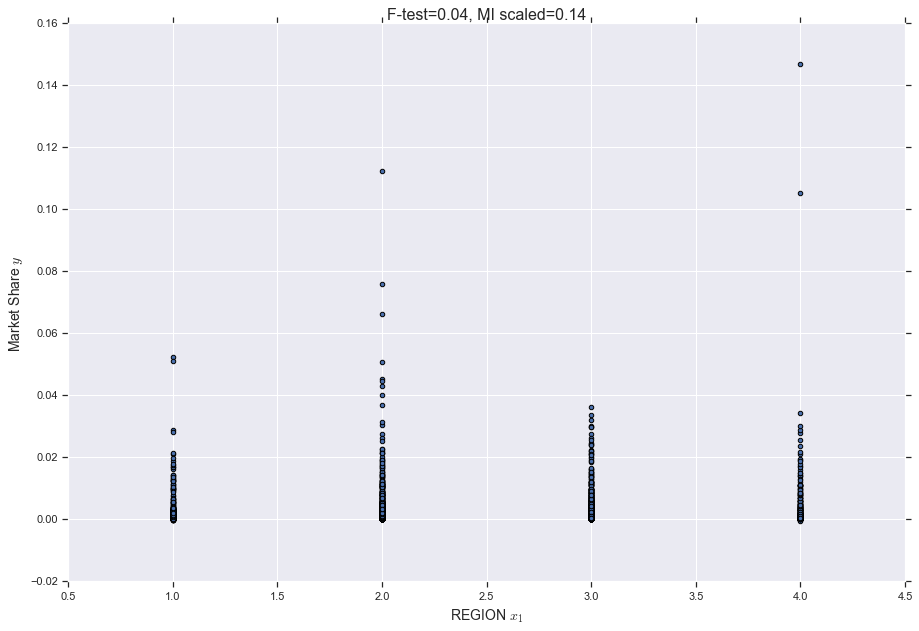

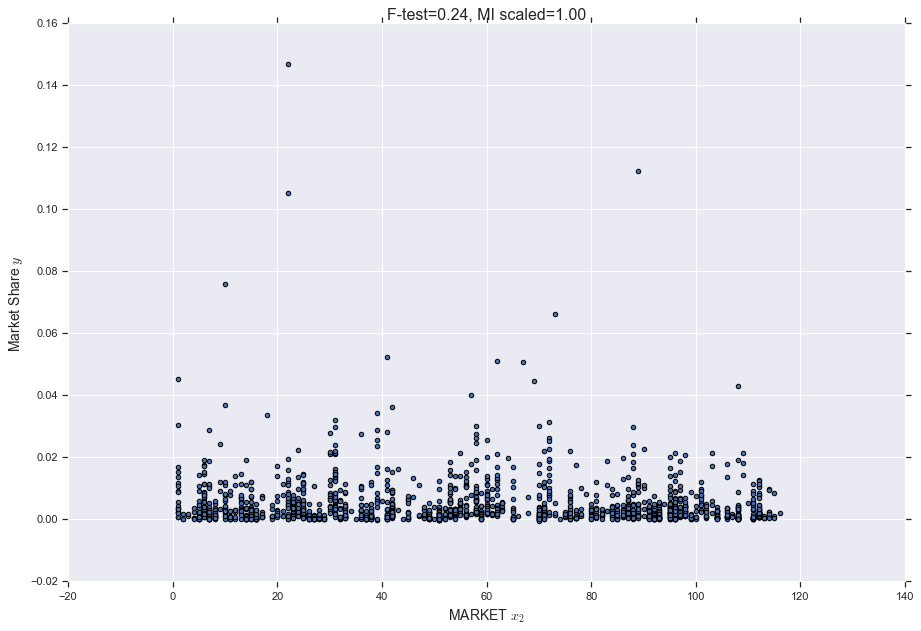

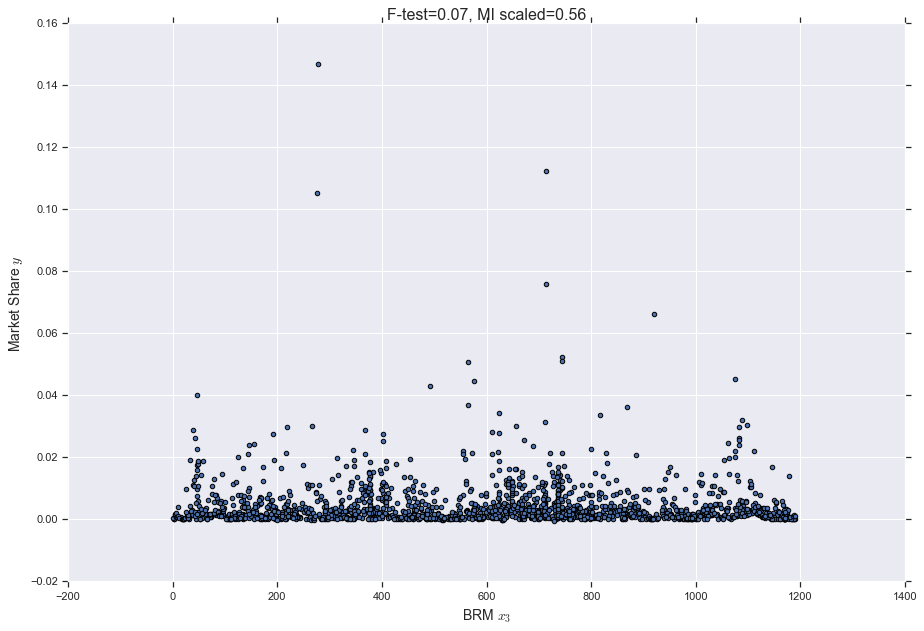

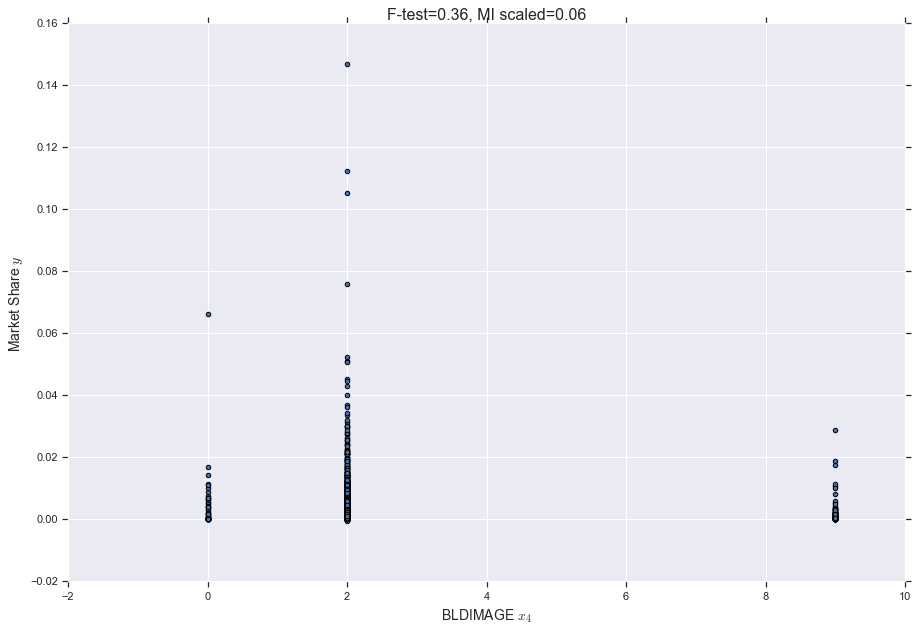

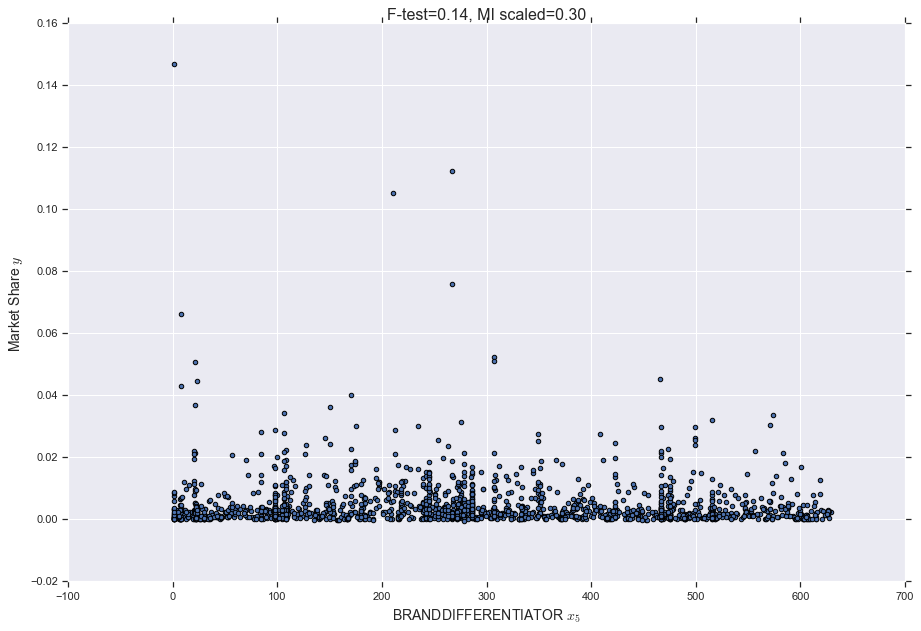

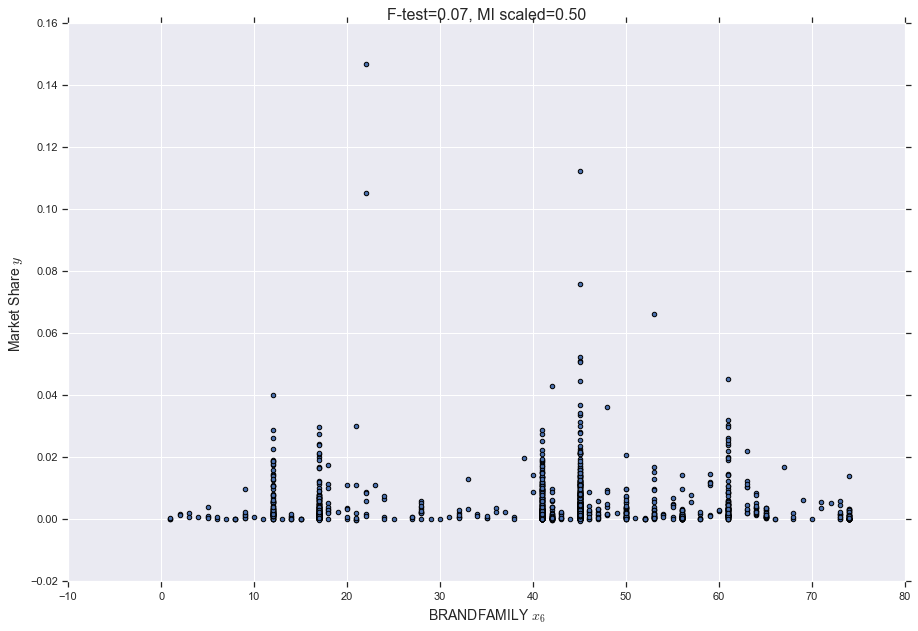

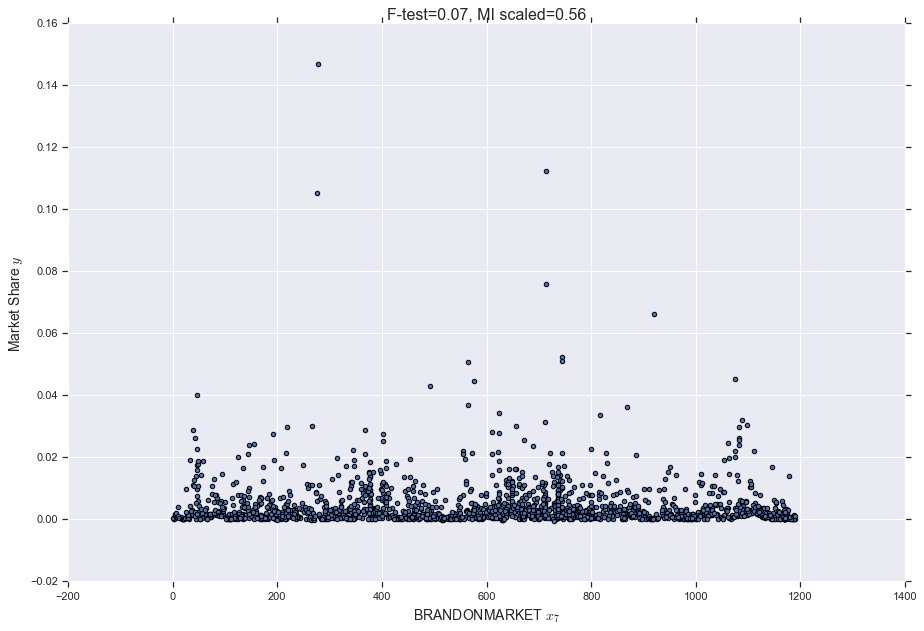

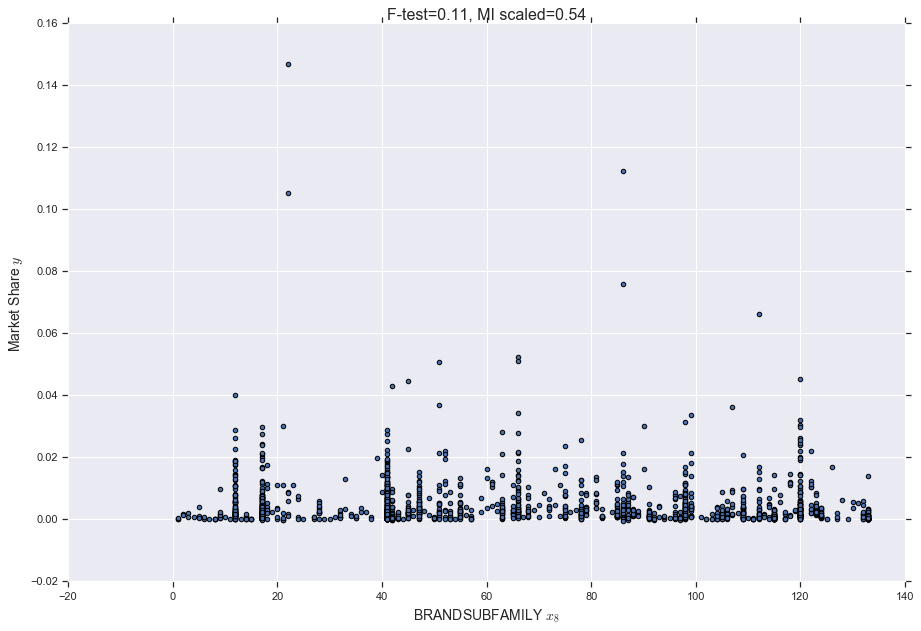

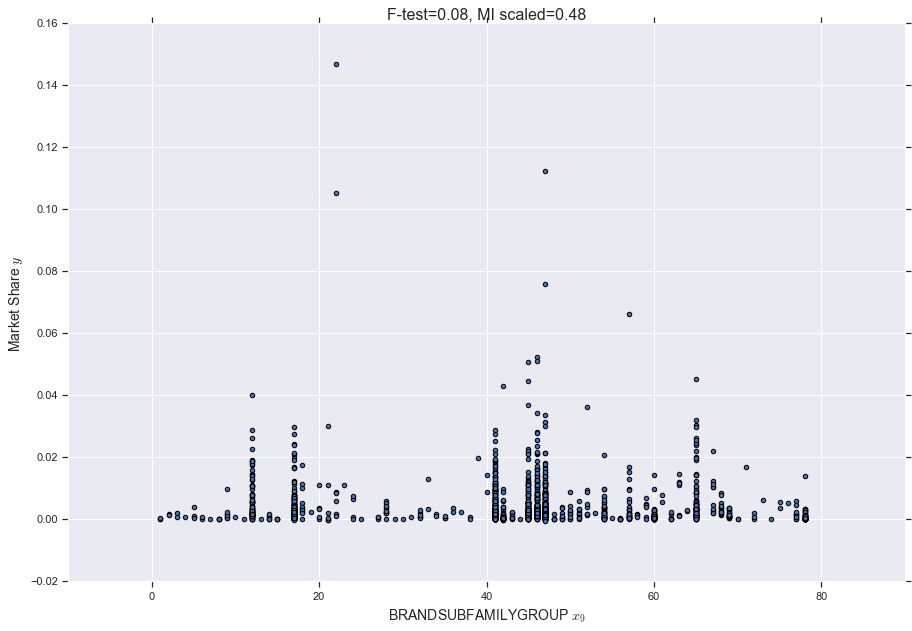

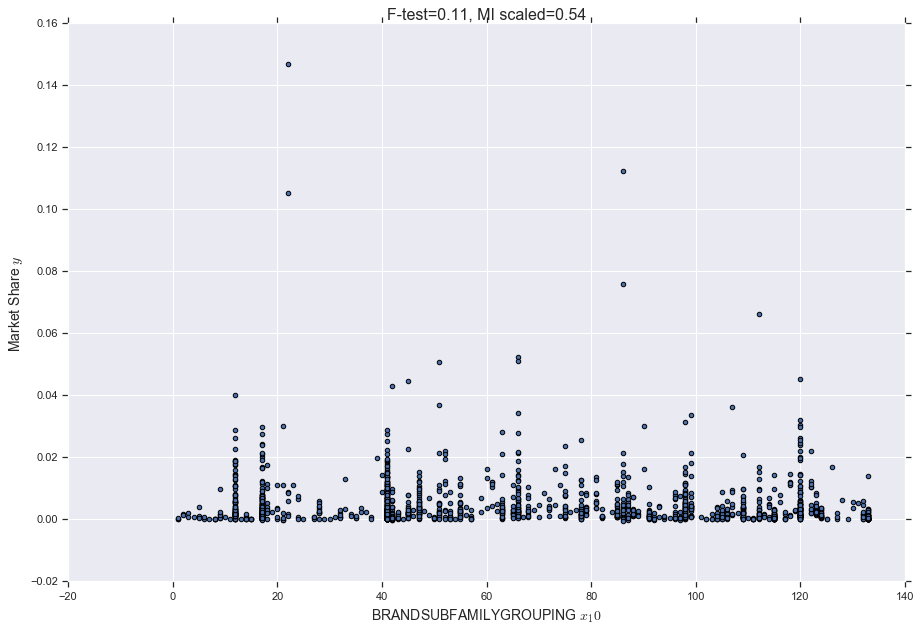

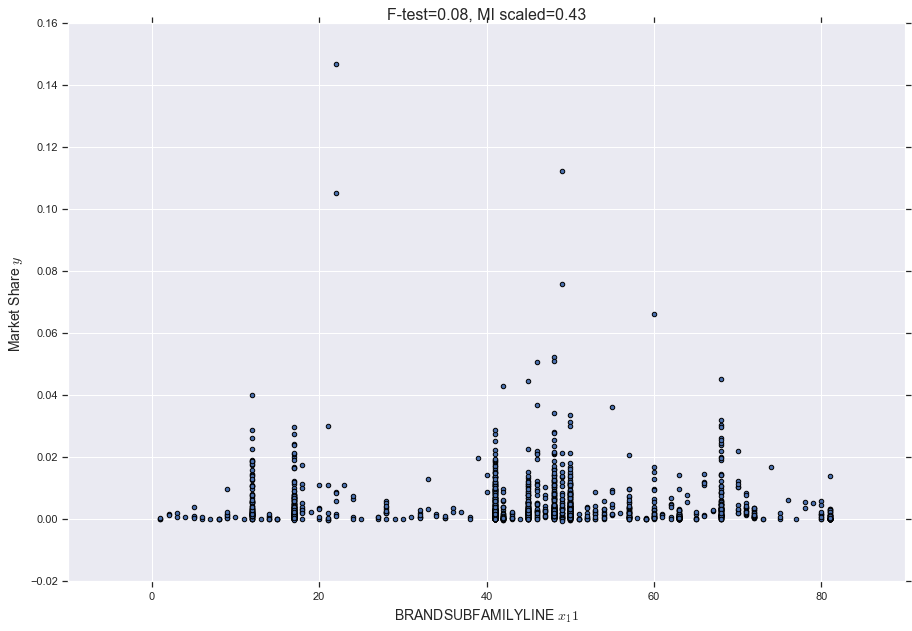

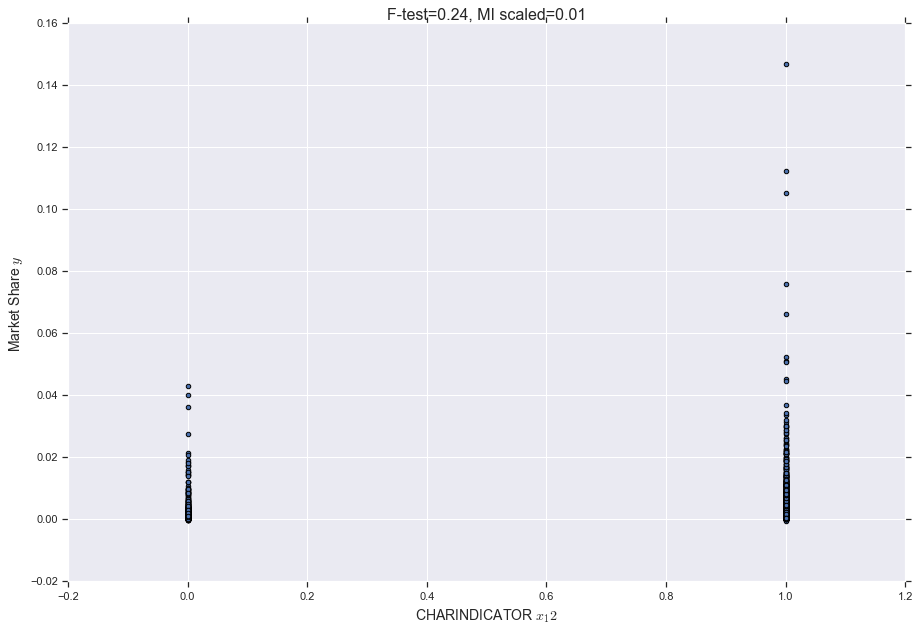

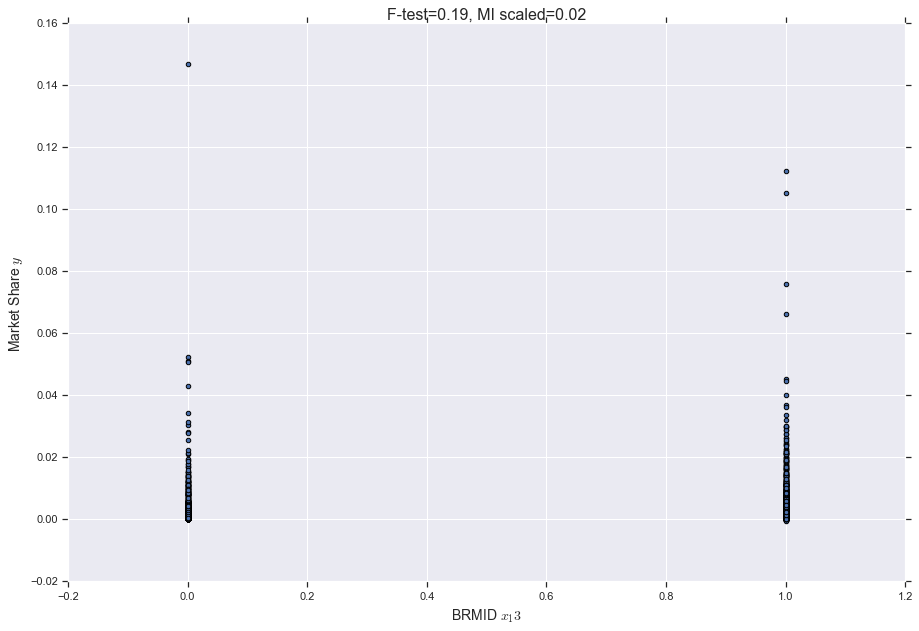

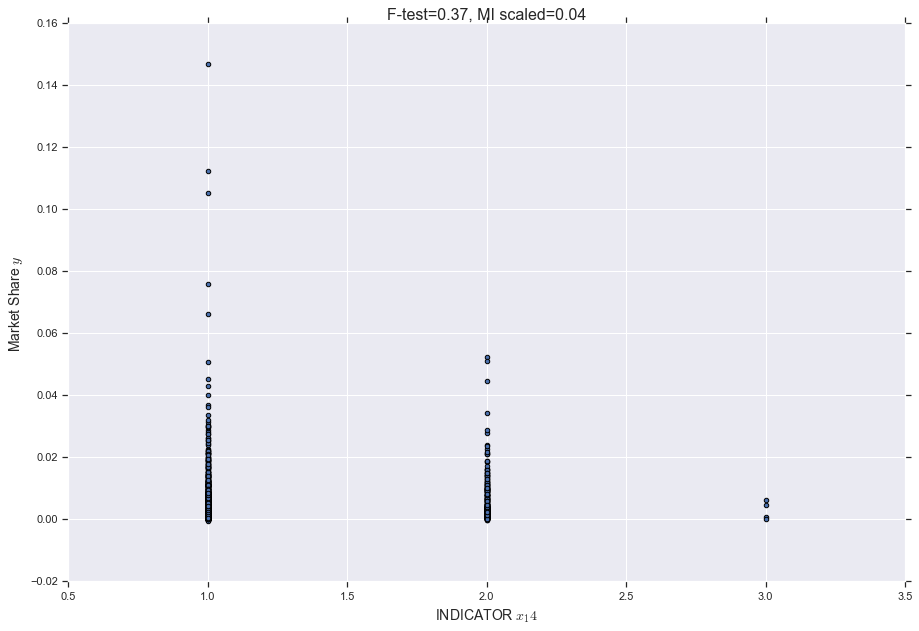

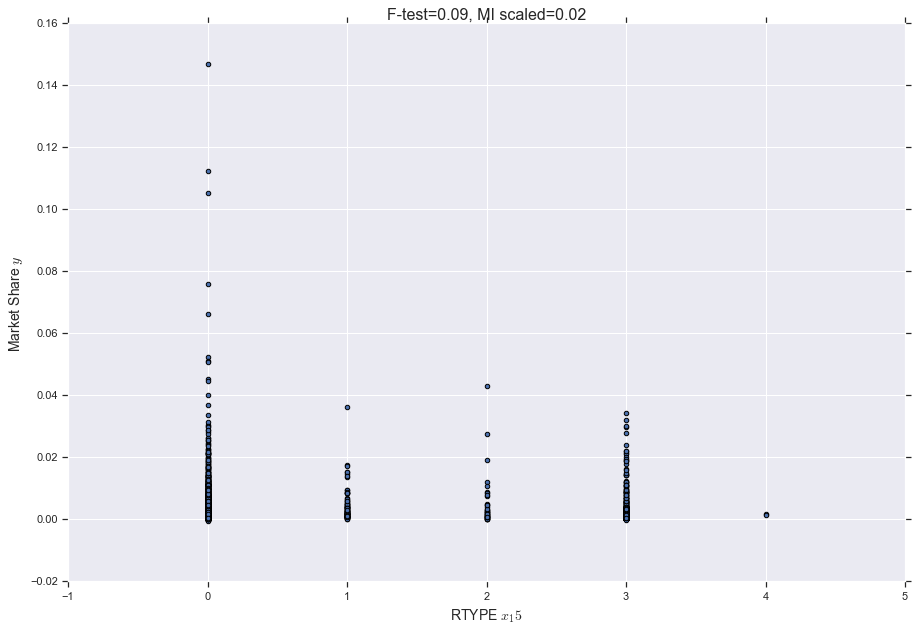

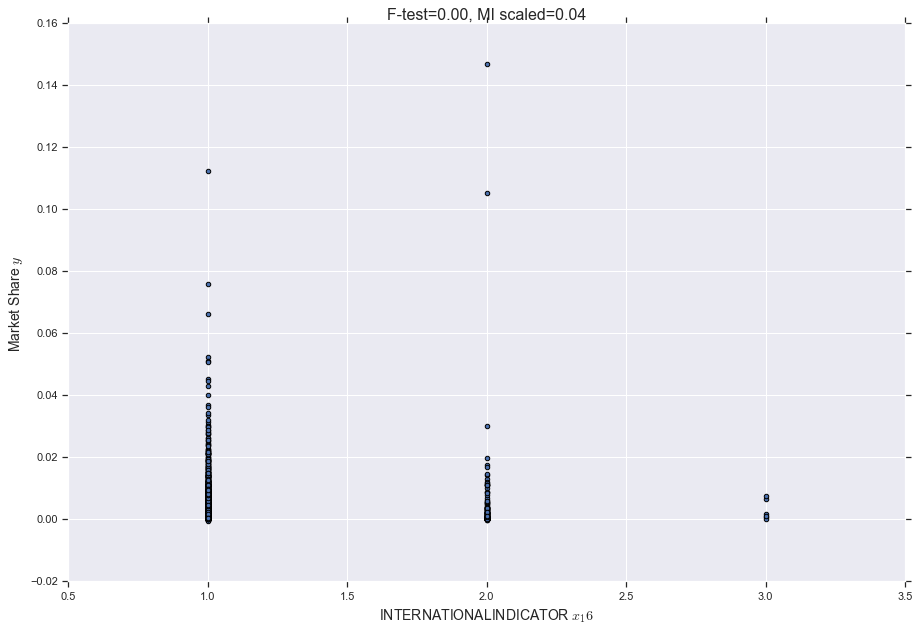

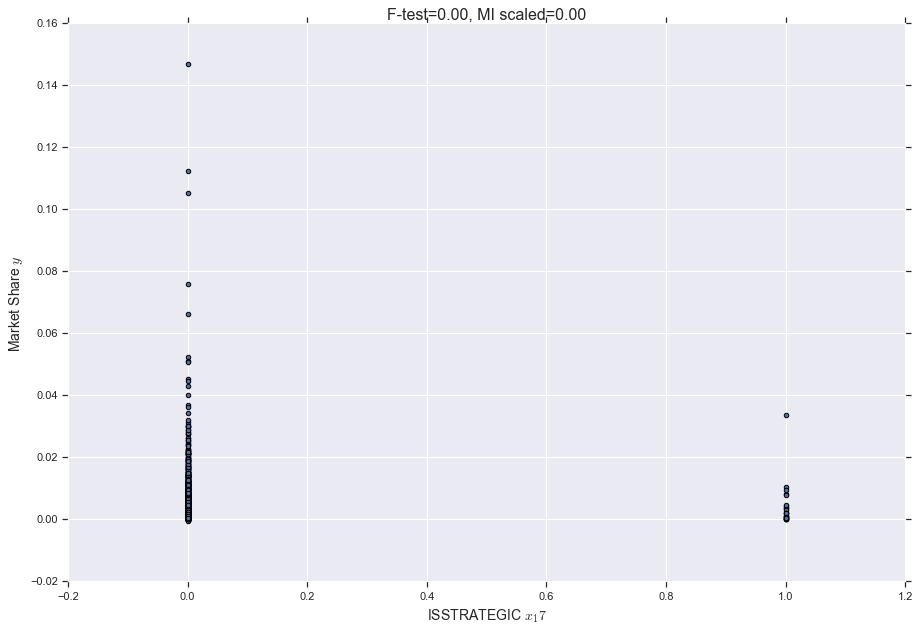

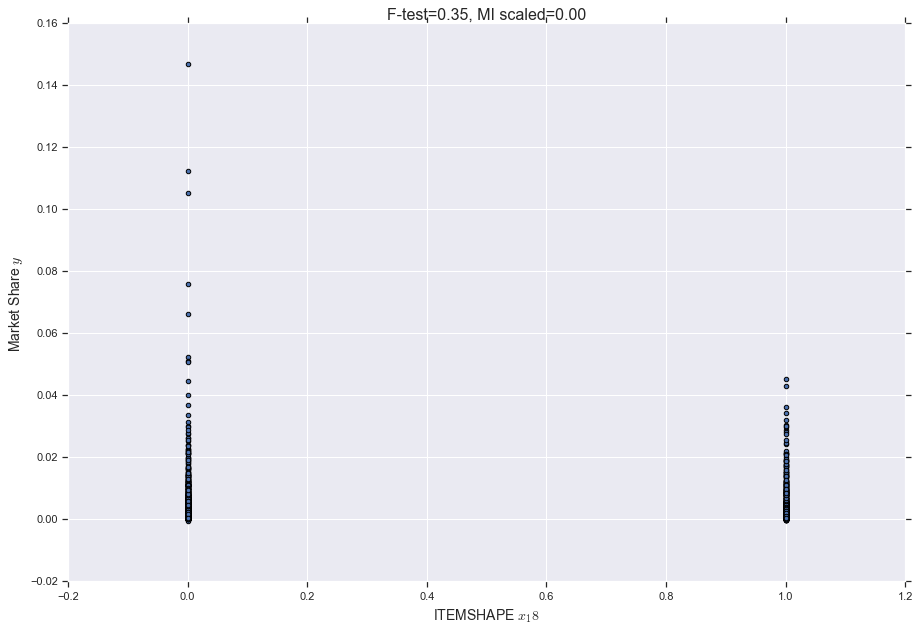

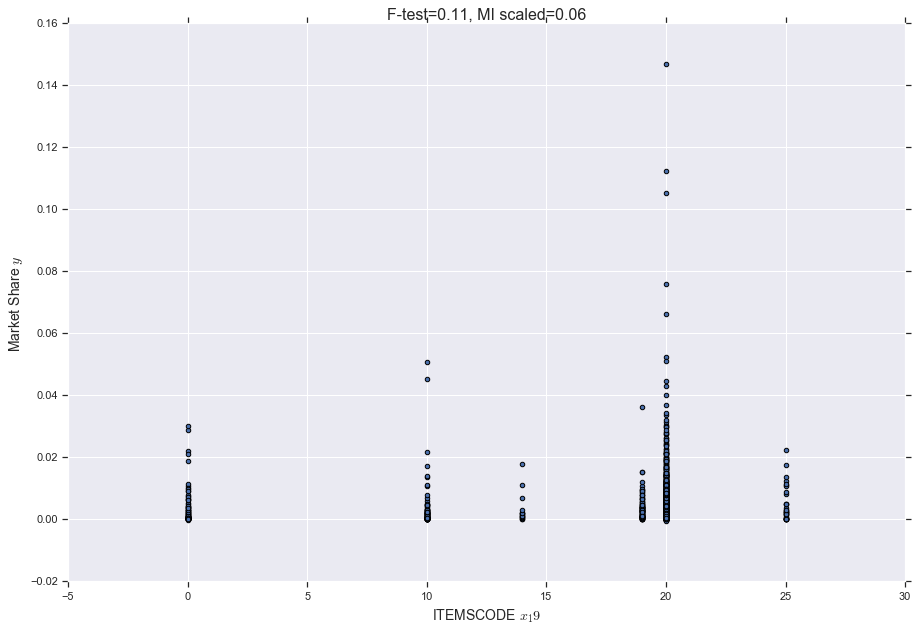

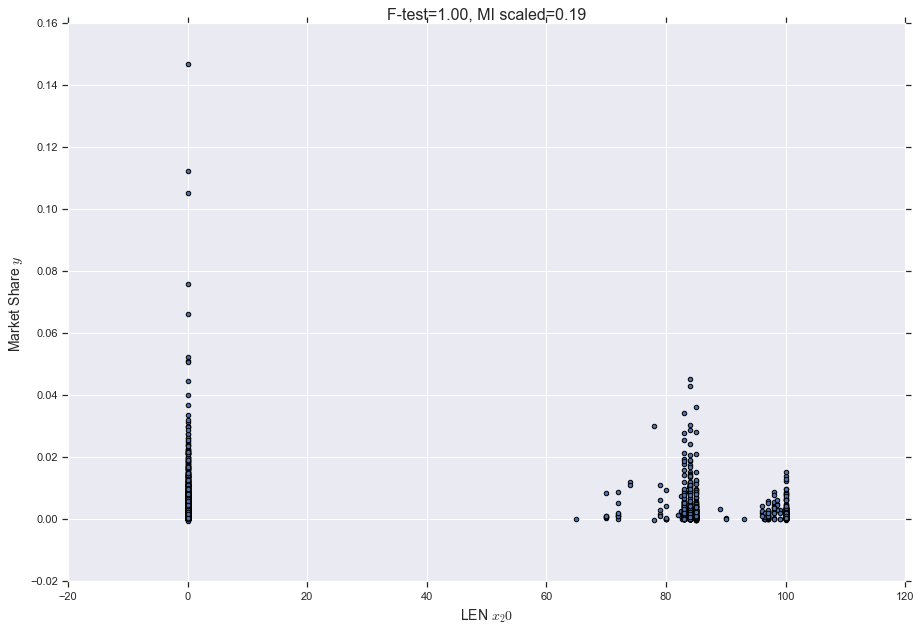

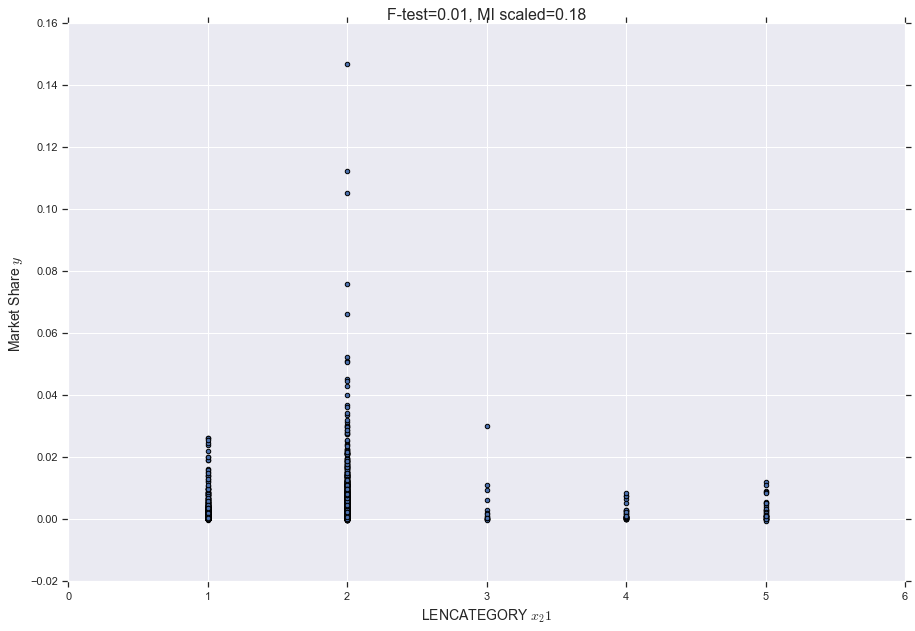

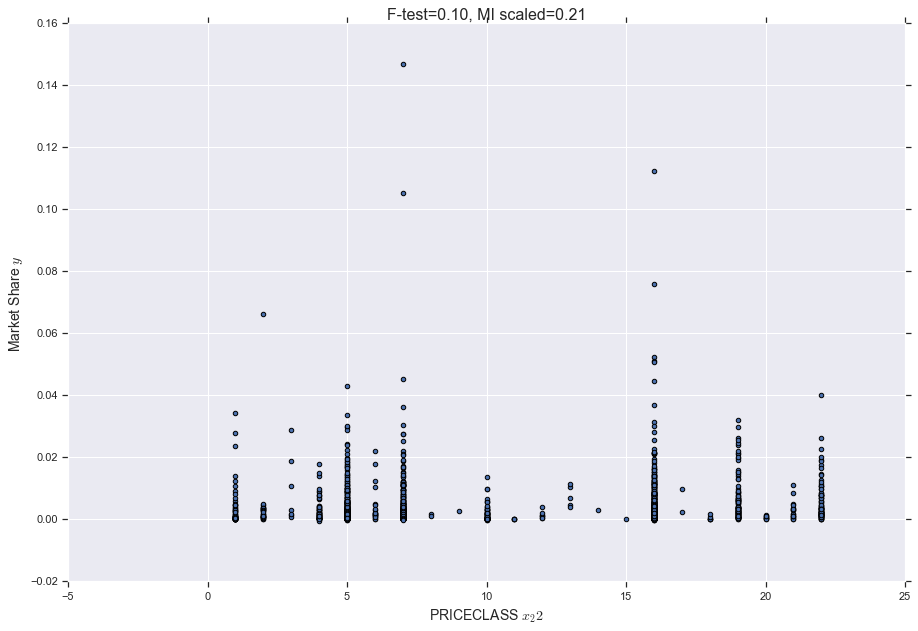

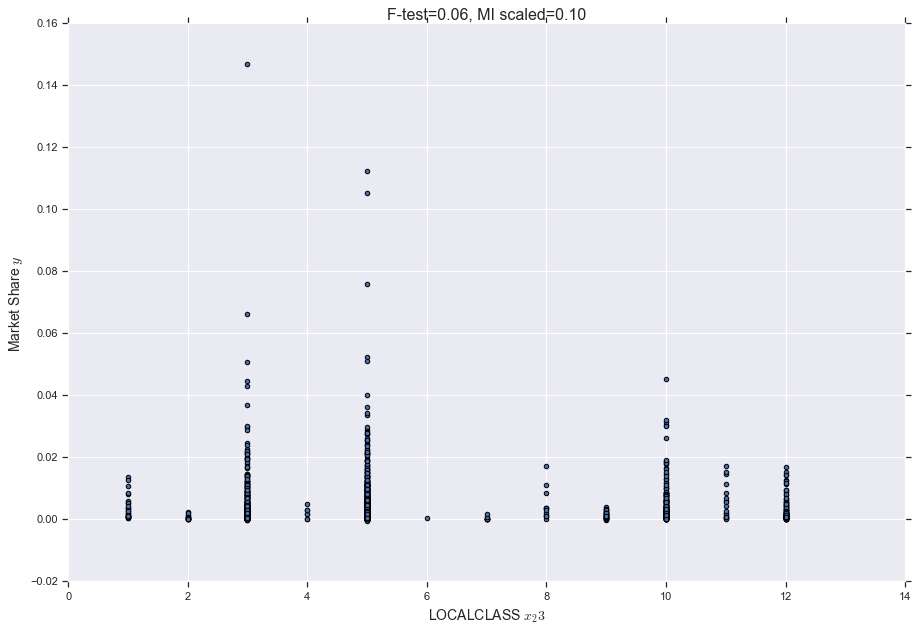

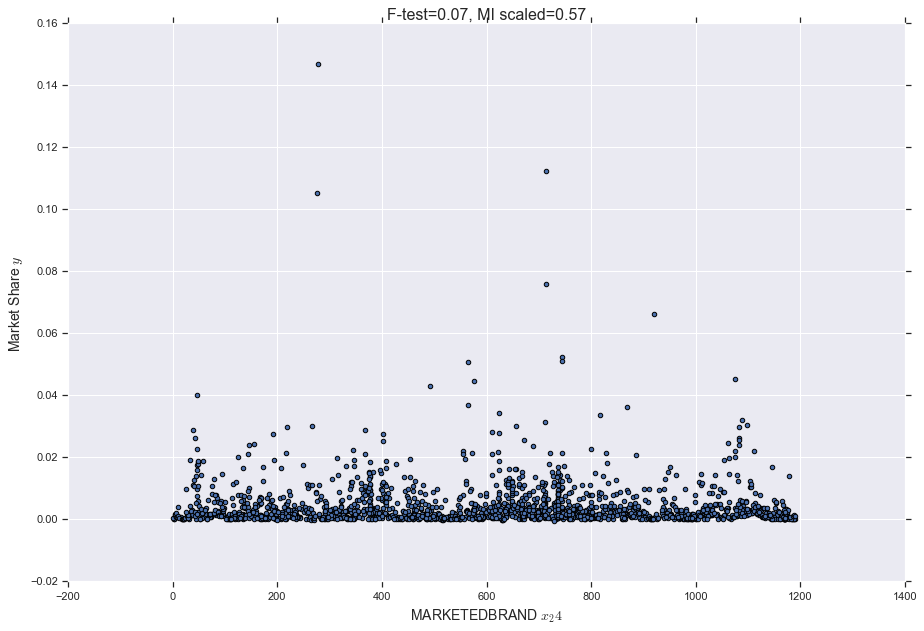

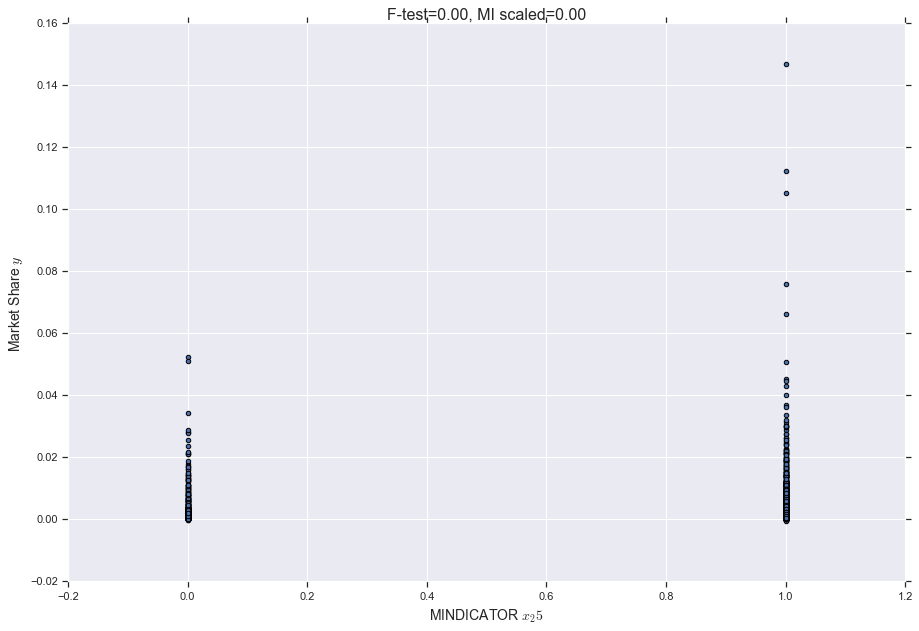

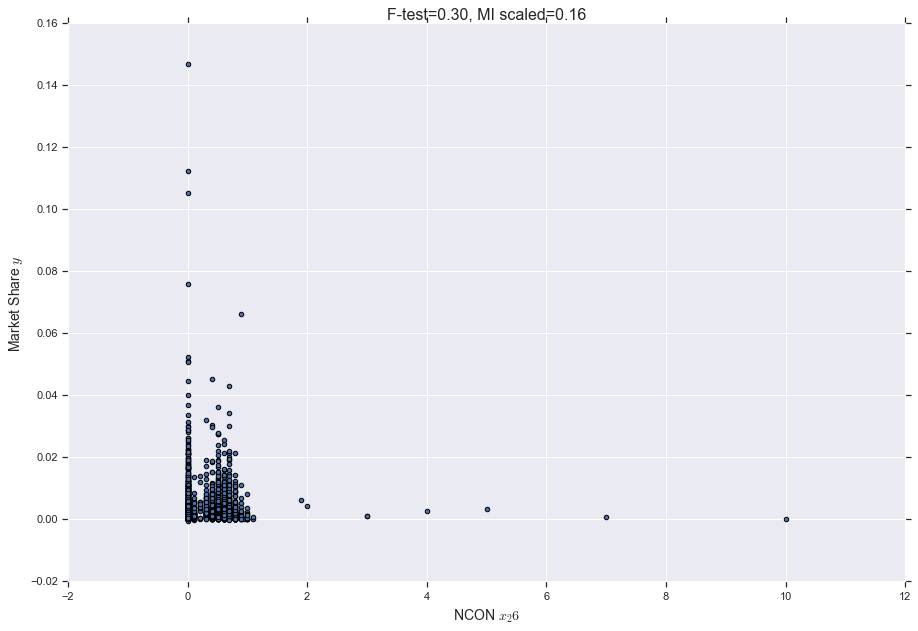

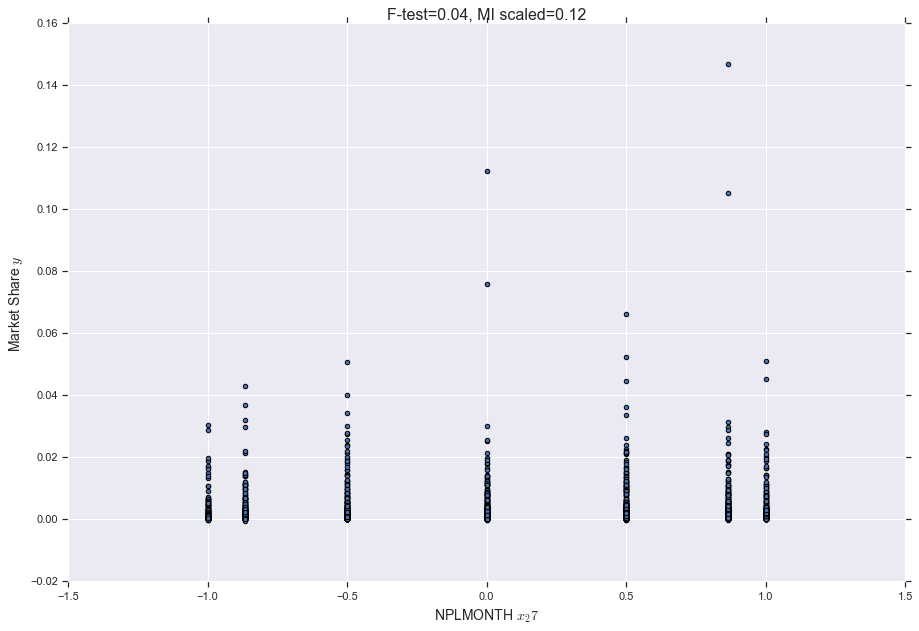

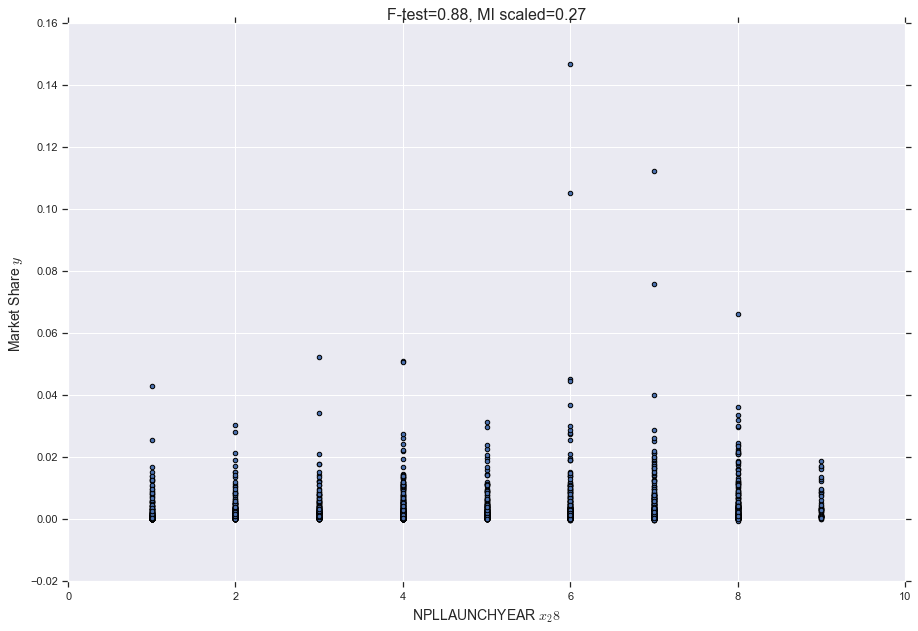

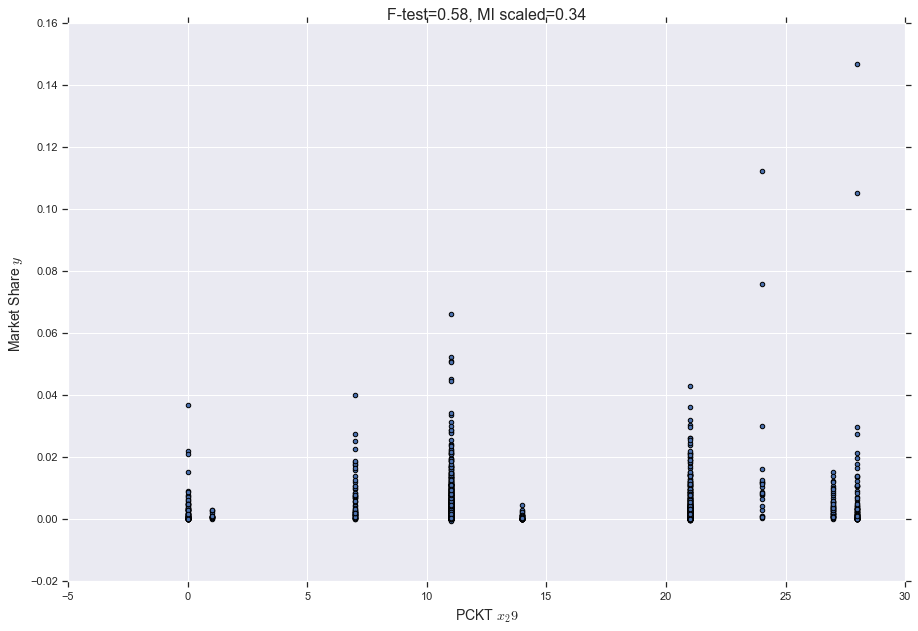

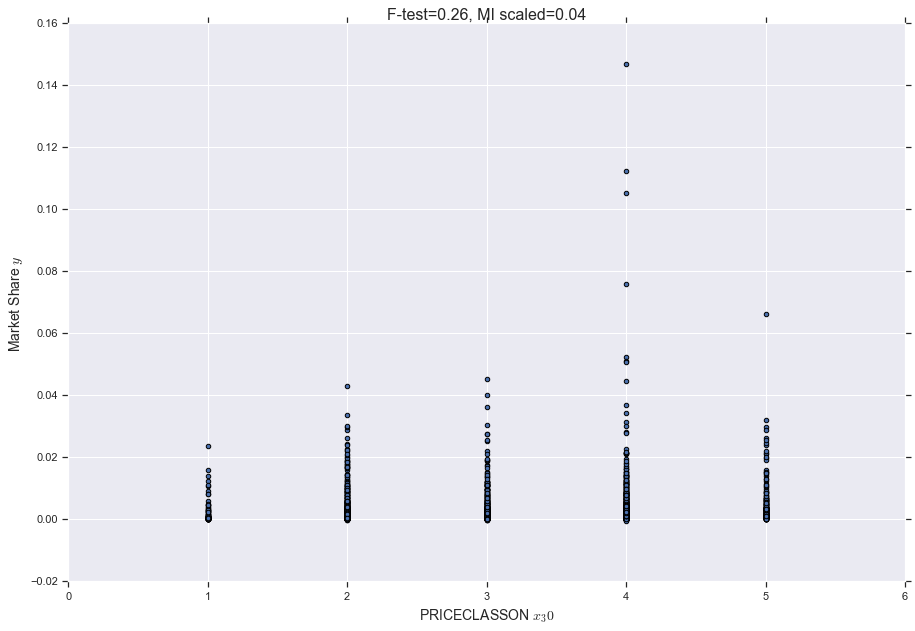

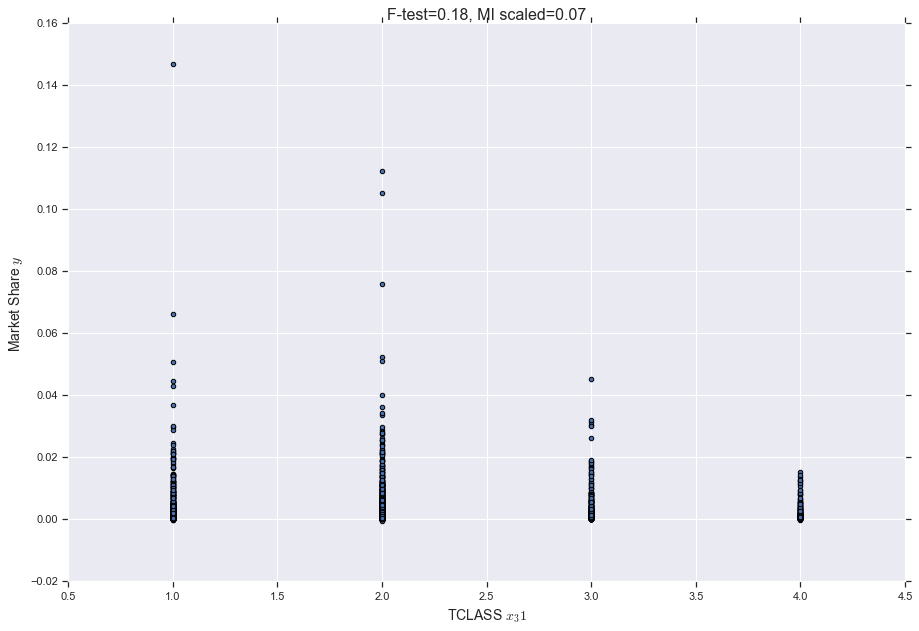

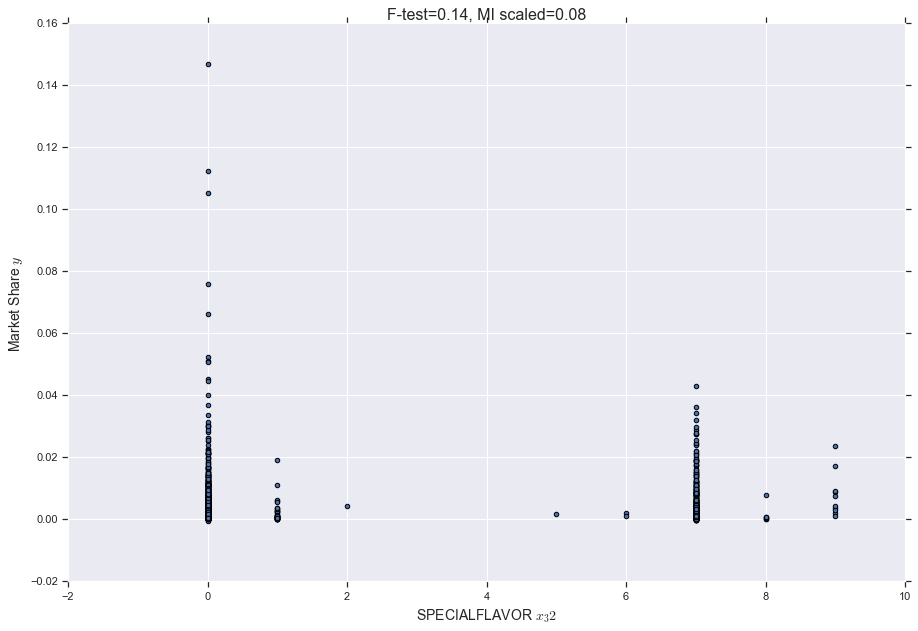

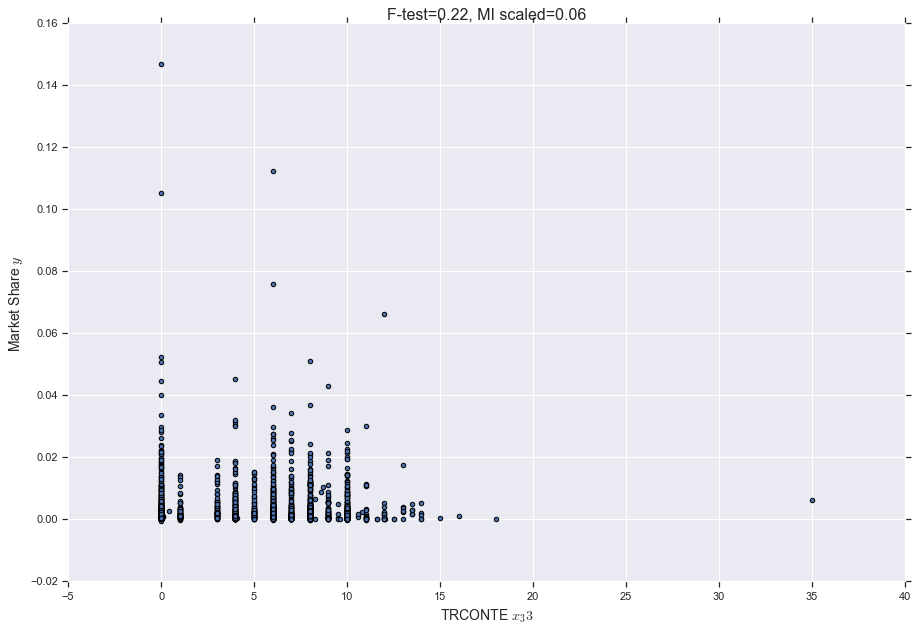

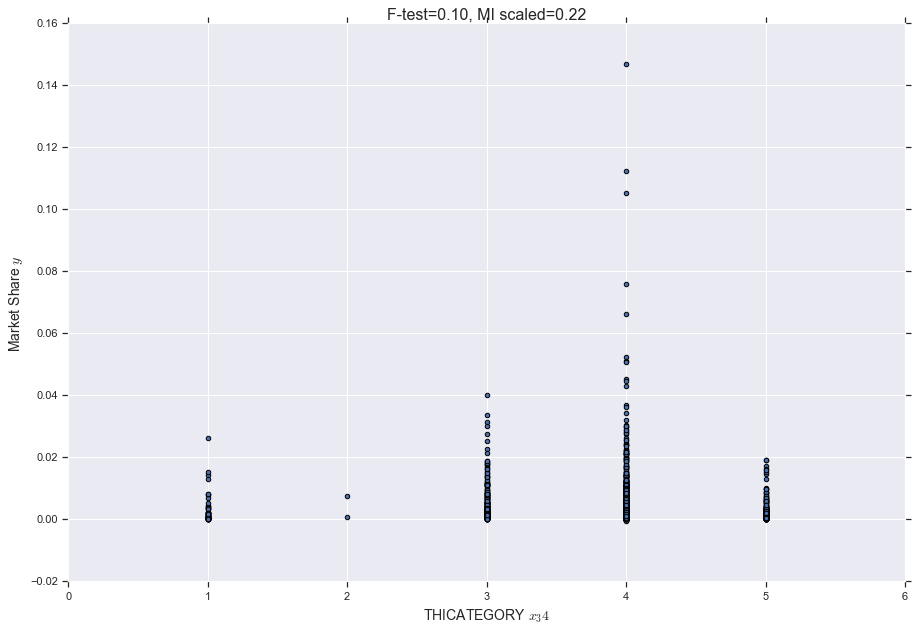

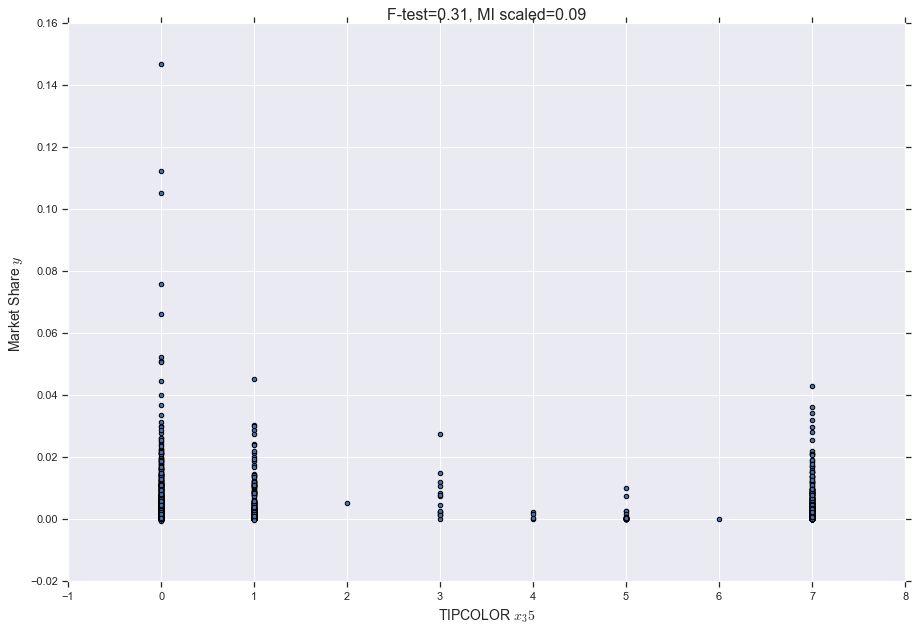

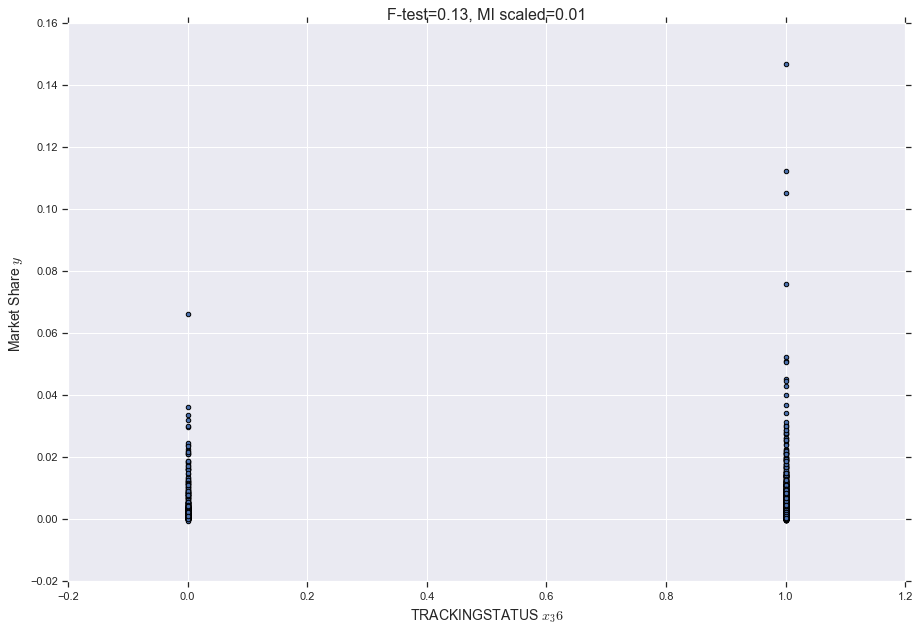

In [27]:
# Scatter plts for each fatures with f test and MI
from sklearn.feature_selection import f_regression, mutual_info_regression

np.random.seed(0)
num = len(df_var.columns) - 1

f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)

mi = mutual_info_regression(X, y)
mi /= np.max(mi)

for i in range(num):
    plt.figure(figsize=(15, 10))
    plt.scatter(X[:, i], y, edgecolor='black', s=20)
    plt.xlabel(df_var.columns[i]+" $x_{}$".format(i + 1), fontsize=14)
    plt.ylabel("Market Share $y$", fontsize=14)
    plt.title("F-test={:.2f}, MI scaled={:.2f}".format(f_test[i], mi[i]),
              fontsize=16)
    plt.show()

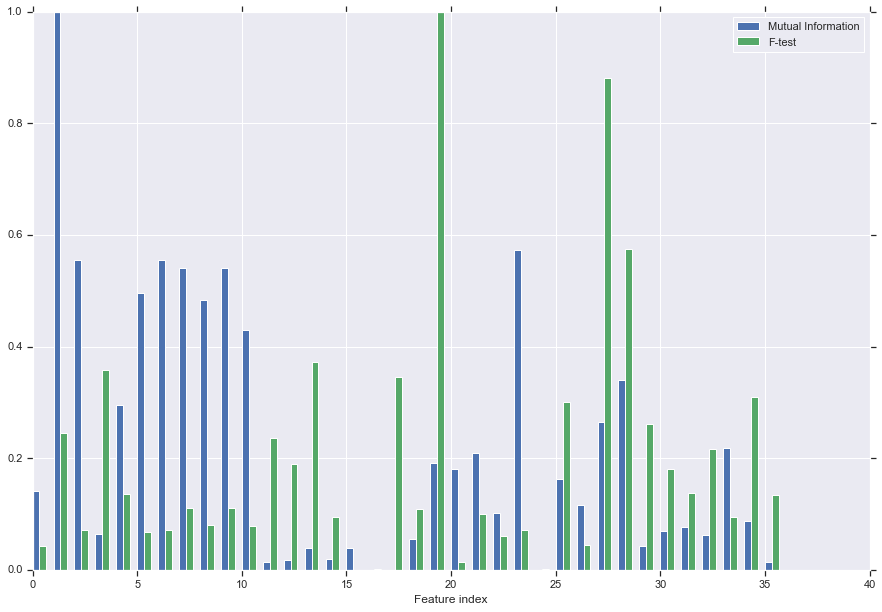

In [28]:
# Plot MI and f test on same graph
plt.figure(figsize=(15, 10))
ax1 = plt.bar(range(num), mi, color='b', width=0.33)
ax2 = plt.bar(np.array(range(num))+0.33, f_test, color='g', width=0.33)
plt.legend((ax1, ax2), ('Mutual Information', 'F-test'))
plt.xlabel('Feature index')
#plt.savefig('image/MI_ftest.jpg')
plt.show()

In [29]:
# We look fr features not rejecting null hypothesis
relevant = dict()
irrelevant = dict()
for i in range(len(f_test)):
    if f_test[i] < 0.05 and mi[i] < 0.05:
        irrelevant[df_var.columns[i]] = f_test[i]
    if f_test[i] > 0.8 :
        relevant[df_var.columns[i]] = f_test[i]
    if mi[i] > 0.8:
        relevant[df_var.columns[i]] = mi[i]
print('Irrelevant features: ', irrelevant)
print('\nHigh indicators: ', relevant)

Irrelevant features:  {'ISSTRATEGIC': 0.00130450070192364, 'INTERNATIONALINDICATOR': 0.00015051937825168445, 'MINDICATOR': 0.0008029318870501306}

High indicators:  {'LEN': 1.0, 'MARKET': 1.0, 'NPLLAUNCHYEAR': 0.8816629635474559}


Results suggest that the ISStrategic, MINDICATOR feature does not provide any information (f test and mi are null).  

Now if we look at the correlation matrix and the data exploration we notice that BRM == MARKETEDBRAND == BRANDONMARKET BRANDSUBFAMILY == BRANDSUBFAMILYGROUPING with only less than 25  and 0 values that differs. We will only keep BRM to simplify the matrix.

In [30]:
# Remove irrelevant (or close to be) variables
df_rm = df_var.drop(['ISSTRATEGIC', 'INTERNATIONALINDICATOR' ,'MINDICATOR', 'MARKETEDBRAND', 'BRANDONMARKET', 'BRANDSUBFAMILYGROUPING', 'LEN', 'PRICECLASS'], axis=1)

### Standardization

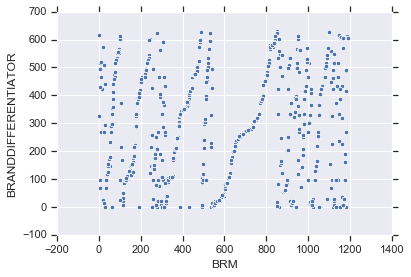

In [31]:
sns.scatterplot(x='BRM', y='BRANDDIFFERENTIATOR', data=df_rm)

In [102]:
# Use hashing function for high cardinality categorical features
df_hashed = df_rm.copy()
to_h = ['BRM', 'MARKET', 'BRANDDIFFERENTIATOR']

def h_cols(df_hashed, to_h, N):
    '''Hashing encode columns in dataframe'''
    h = ce.HashingEncoder()
    for col in to_h:
        df_hashed = h.hashing_trick(df_hashed, N=N, cols=[col])

        # Drop first to infer non colinearity
        df_hashed = df_hashed.drop('col_0', axis=1)

        # Rename columns
        for i in range(1, N):
            df_hashed = df_hashed.rename(columns={'col_'+str(i): col+str(i)})
    return df_hashed
df_hashed = h_cols(df_hashed, to_h, 8)

In [103]:
from sklearn import preprocessing

# Min max scaling for uniformly dist variables
df_scaled = df_hashed.copy()
scaler = preprocessing.MinMaxScaler()
#df_scaled[['BRM', 'MARKET', 'BRANDDIFFERENTIATOR']] = scaler.fit_transform(df_rm[['BRM', 'MARKET', 'BRANDDIFFERENTIATOR']])
df_scaled[['NPLMONTH']] = scaler.fit_transform(df_scaled[['NPLMONTH']])

# Normalizer for normally distributed variables
scaler = preprocessing.RobustScaler()
df_scaled[['NCON', 'TRCONTE']] = scaler.fit_transform(df_scaled[['NCON', 'TRCONTE']])

In [104]:
# Encode sub brand families with 1 (differ from main brand) or 0 (same as brand)
def subDif(row):
    brand = row['BRANDFAMILY']
    if brand == row['BRANDSUBFAMILY']:
        row['BRANDSUBFAMILY'] = 0
    else:
        row['BRANDSUBFAMILY'] = 1
    if brand == row['BRANDSUBFAMILYGROUP']:
        row['BRANDSUBFAMILYGROUP'] = 0
    else:
        row['BRANDSUBFAMILYGROUP'] = 1
    if brand == row['BRANDSUBFAMILYLINE']:
        row['BRANDSUBFAMILYLINE'] = 0
    else:
        row['BRANDSUBFAMILYLINE'] = 1
    return row

# Apply transformation
df_scaled = df_scaled.apply(subDif, axis=1)

# Hash encode Brand Family
df_scaled = h_cols(df_scaled, ['BRANDFAMILY'], 8)
# Apply standard scaler
#scaler = preprocessing.StandardScaler()
#df_scaled[['BRANDFAMILY']] = scaler.fit_transform(df_rm[['BRANDFAMILY']])

In [105]:
# Variables to apply one hot encoding
col_one_hot = ['REGION', 'BLDIMAGE', 'INDICATOR', 'RTYPE', 'PRICECLASSON', 
               'NPLLAUNCHYEAR', 'LENCATEGORY',
                  'ITEMSCODE', 'LOCALCLASS', 'PCKT', 'TCLASS', 'SPECIALFLAVOR', 'THICATEGORY', 'TIPCOLOR']

for col in col_one_hot:    
    # Apply one hot encoded
    df_col_enc = pd.get_dummies(df_scaled[col], prefix=col, prefix_sep='', drop_first=True)
    
    # drop original variable
    df_scaled = df_scaled.drop(col, axis=1)
    df_scaled = pd.concat([df_scaled, df_col_enc], axis=1)

In [106]:
# Split variables and labels
X = df_scaled.drop('Market_Share', axis=1).as_matrix()
y = df_scaled['Market_Share']

C:\Users\Louis\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


In [107]:
# Assess top components wiht PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
X_reduced = pca.fit_transform(X)

<Container object of 110 artists>

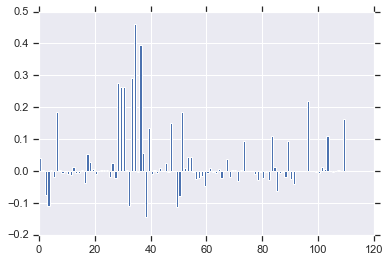

In [108]:
plt.bar(range(len(pca.components_[0])), pca.components_[0])

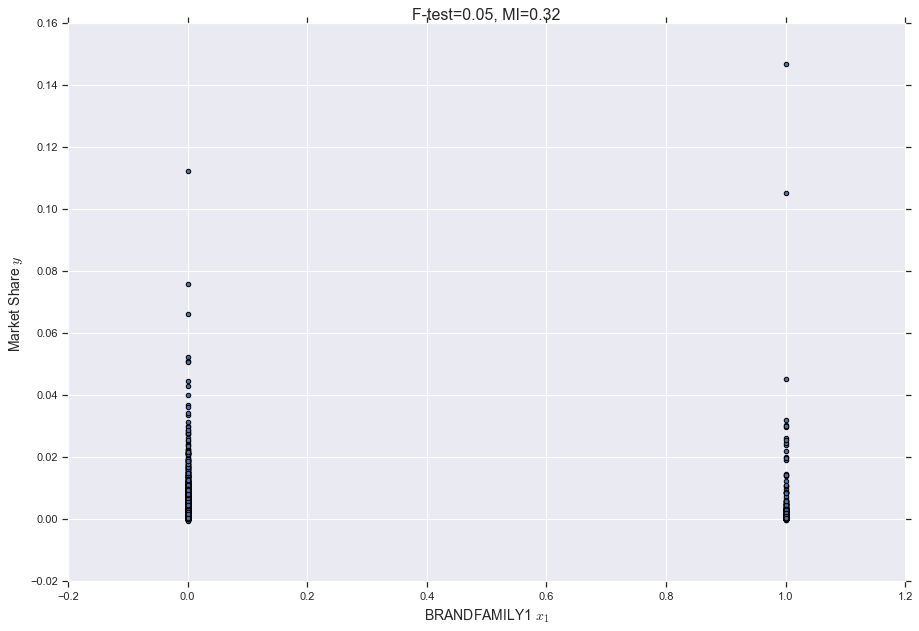

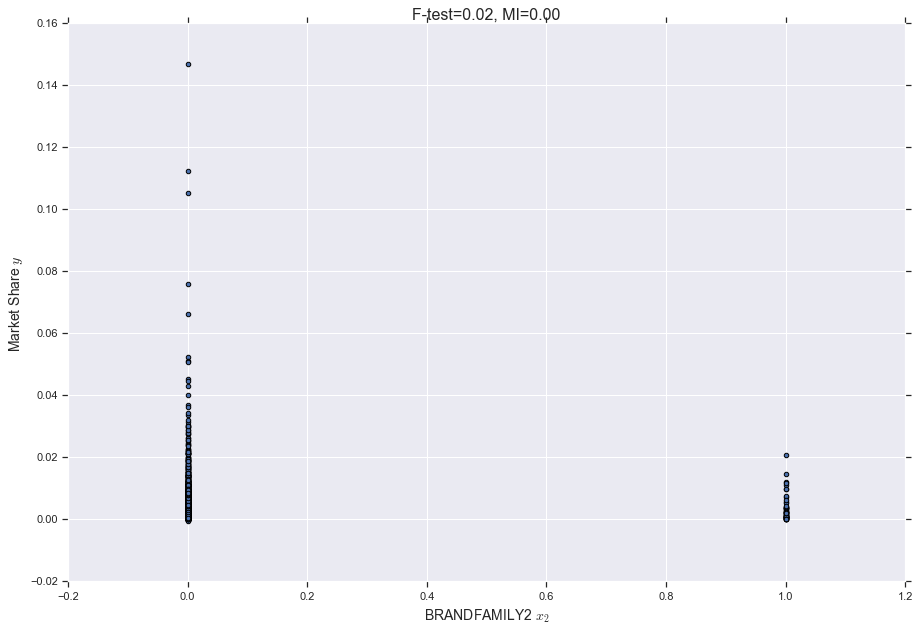

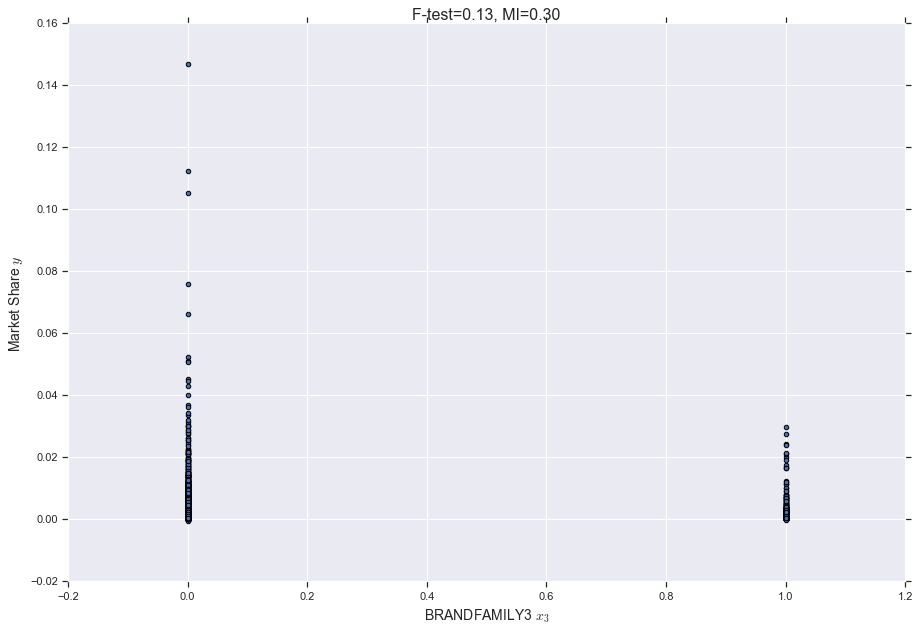

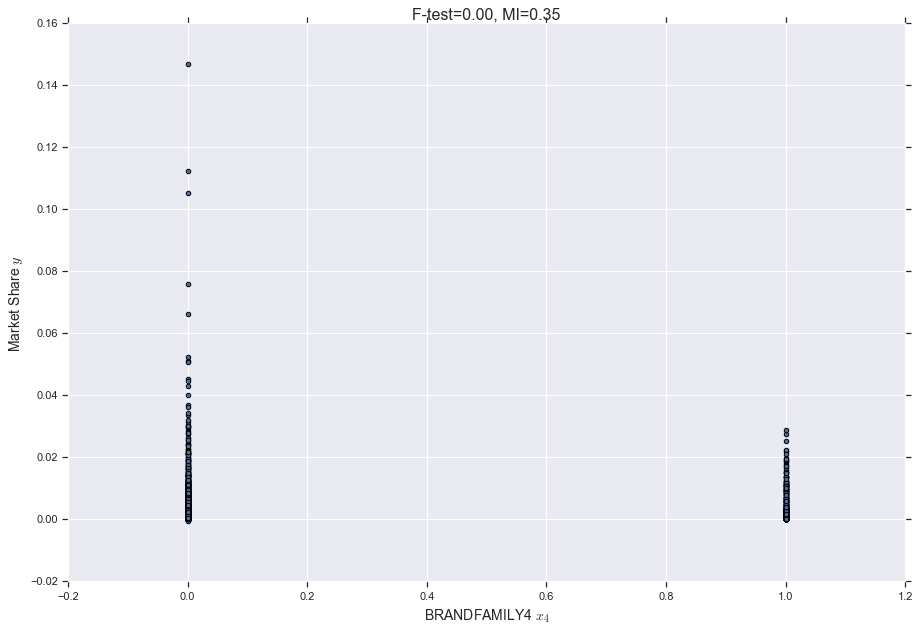

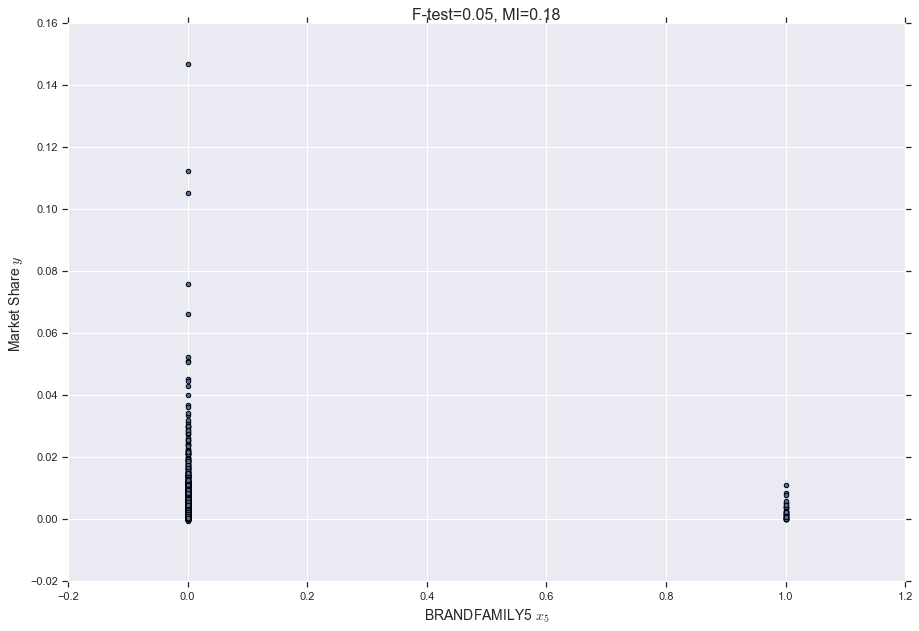

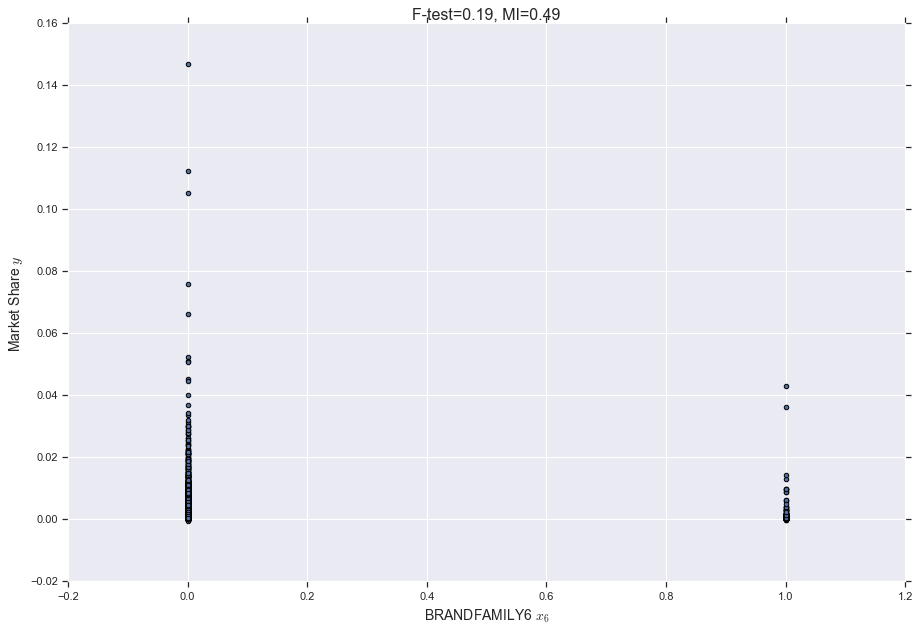

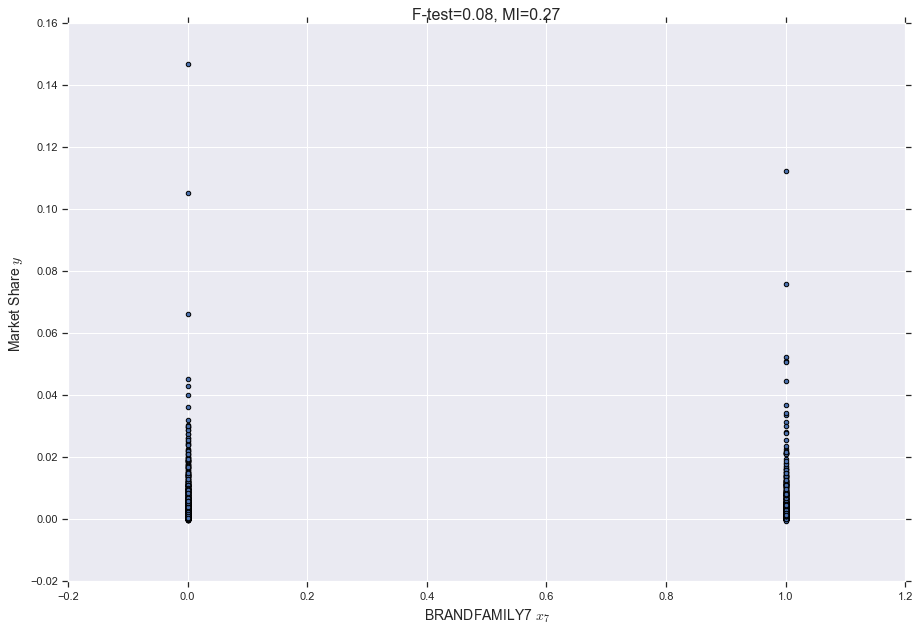

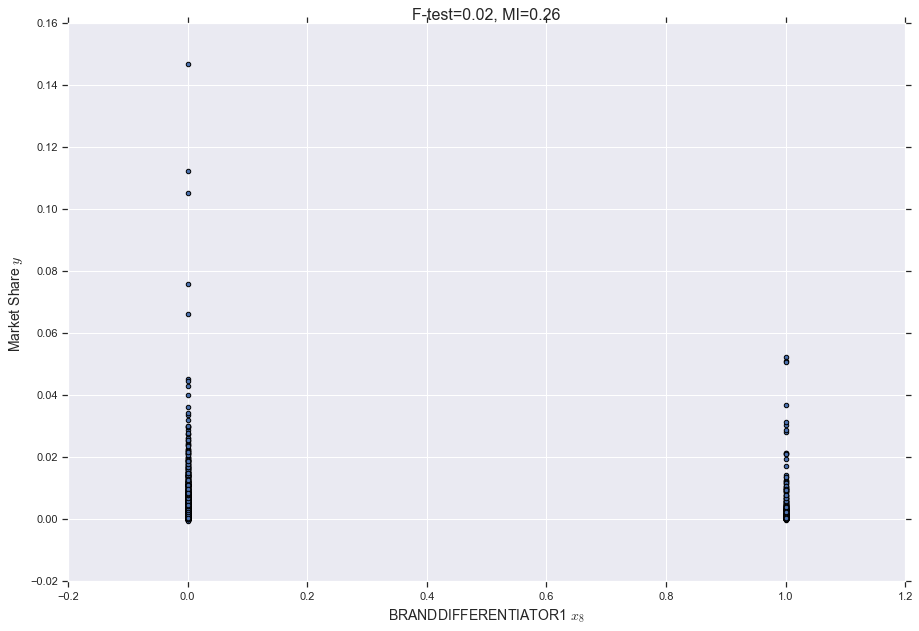

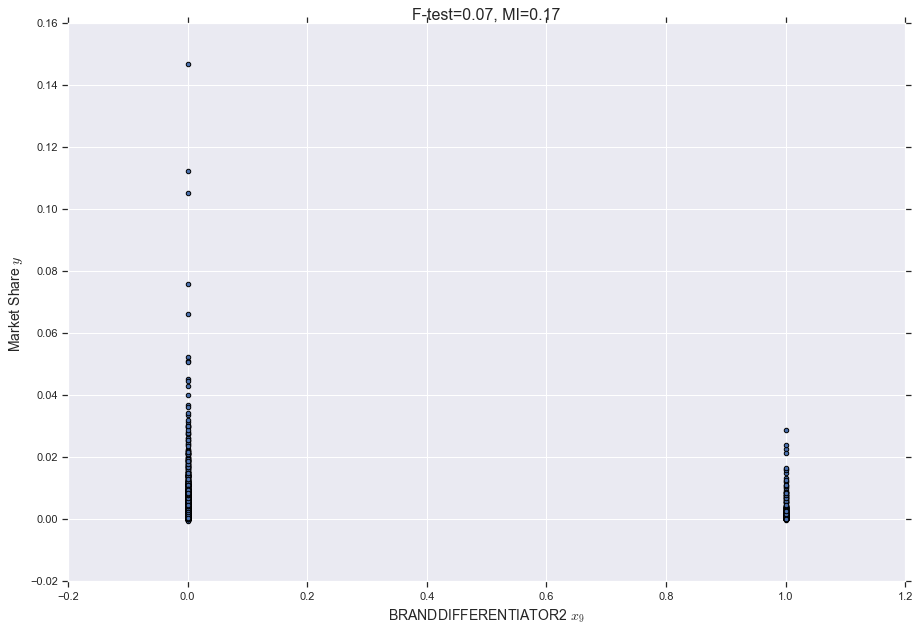

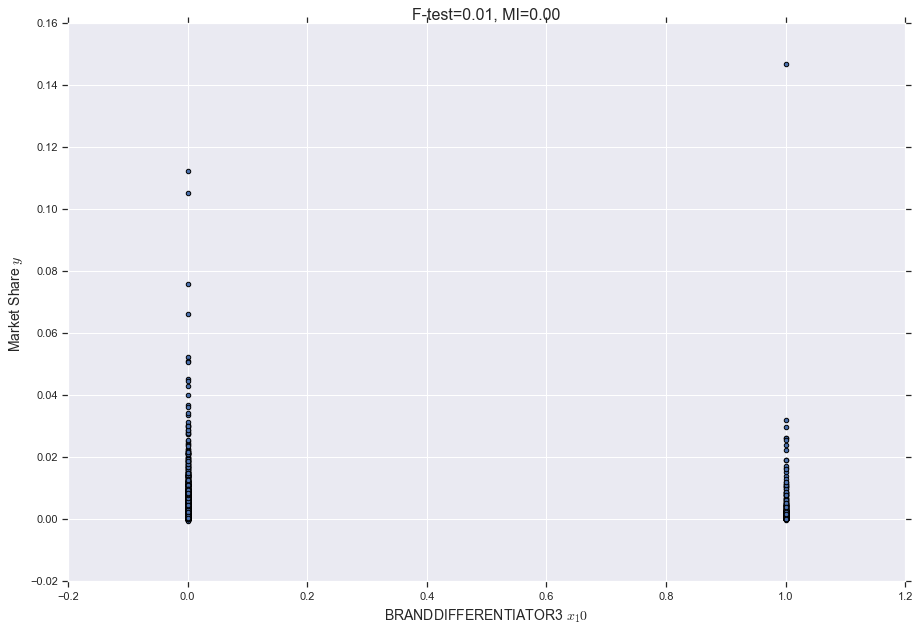

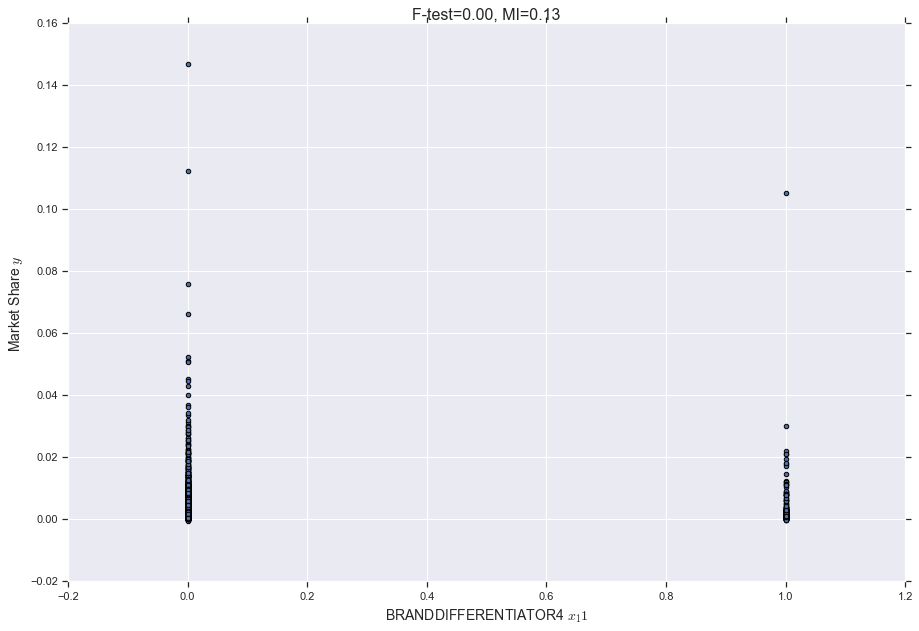

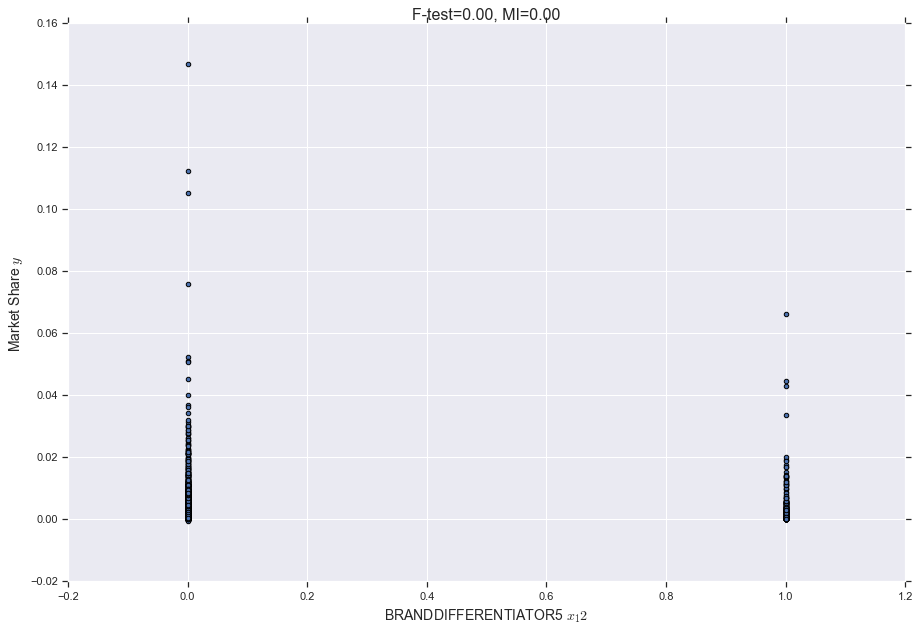

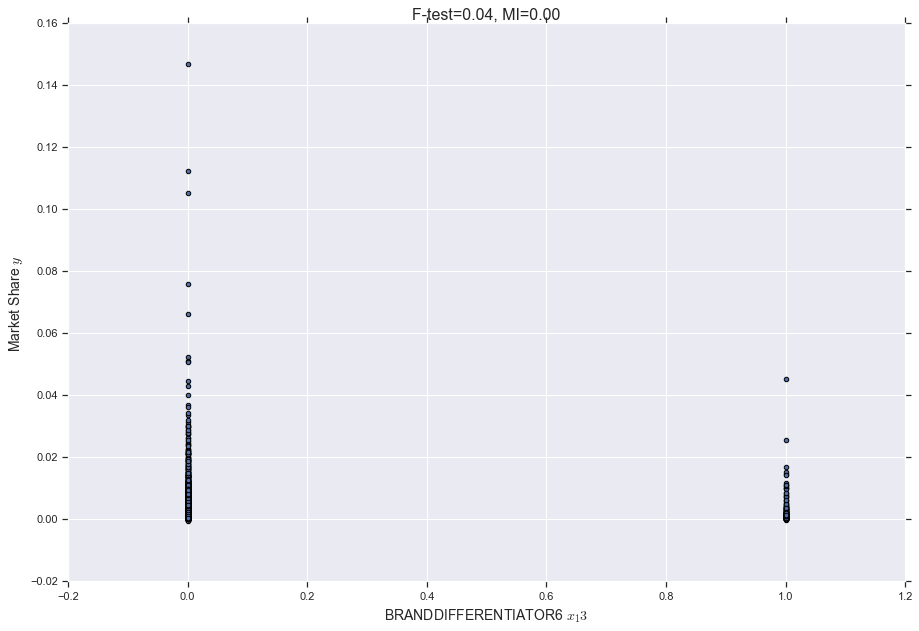

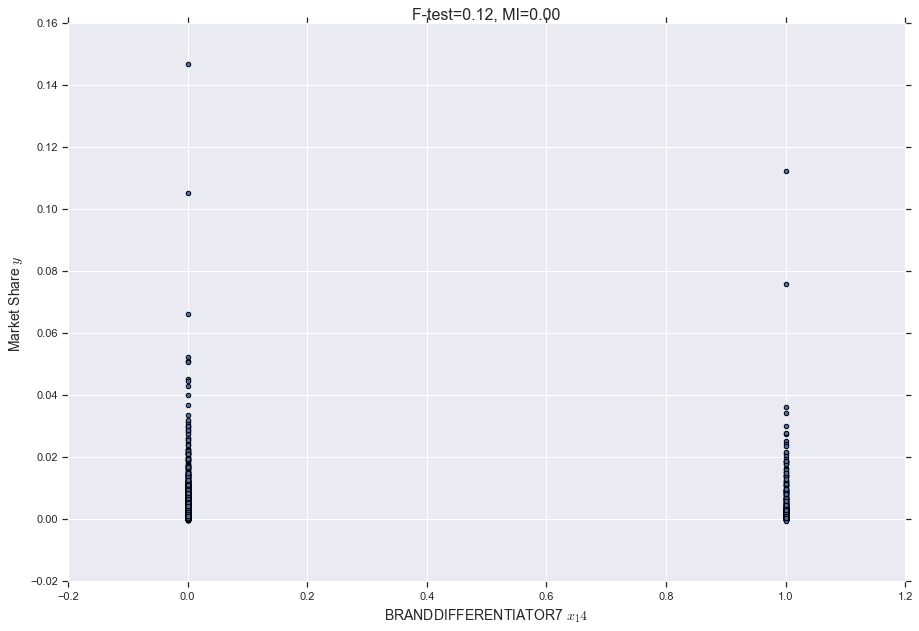

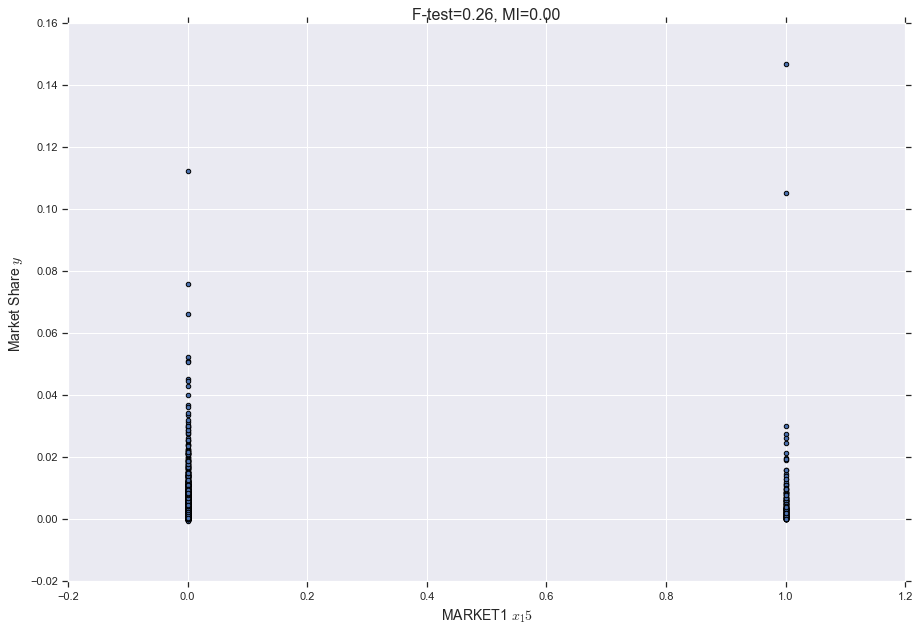

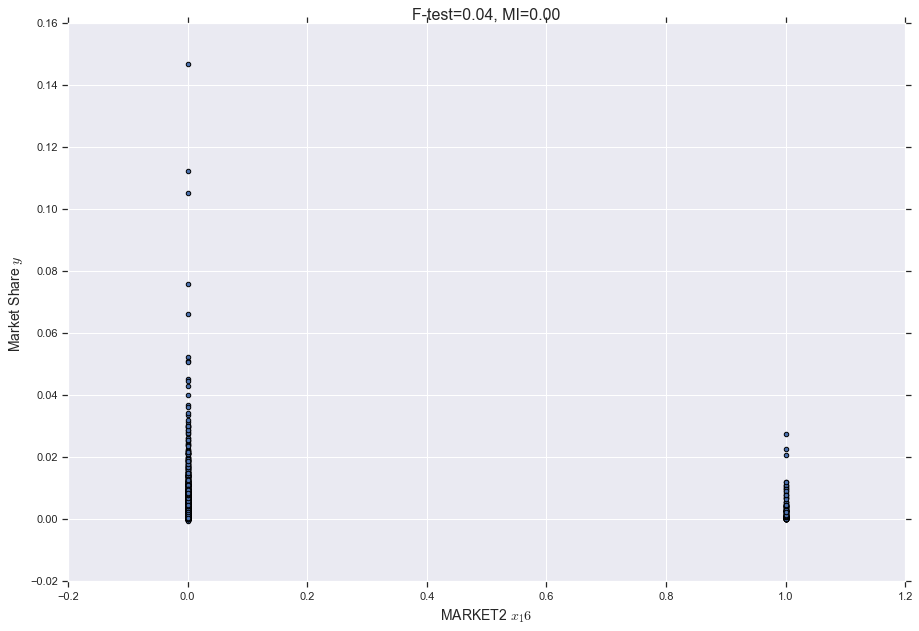

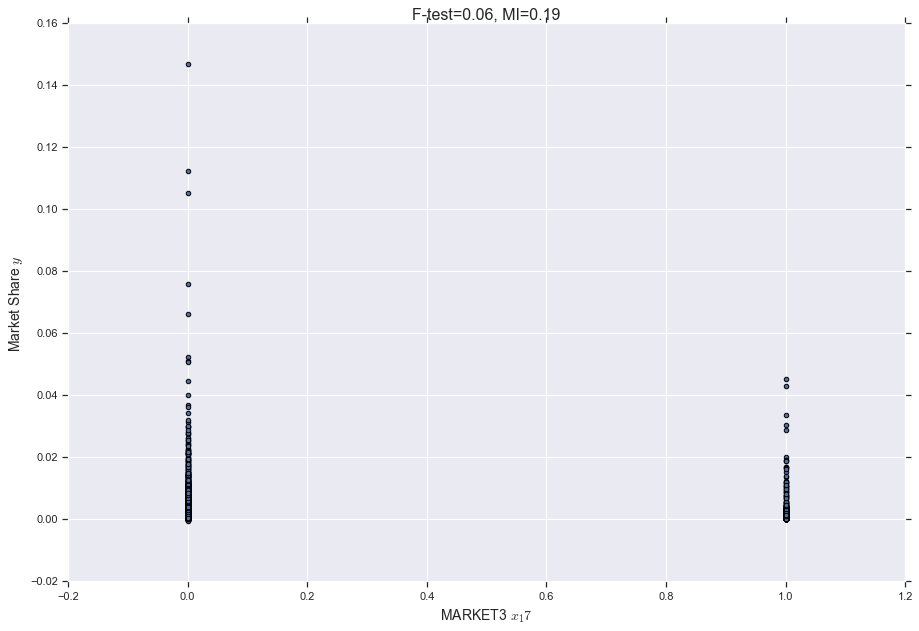

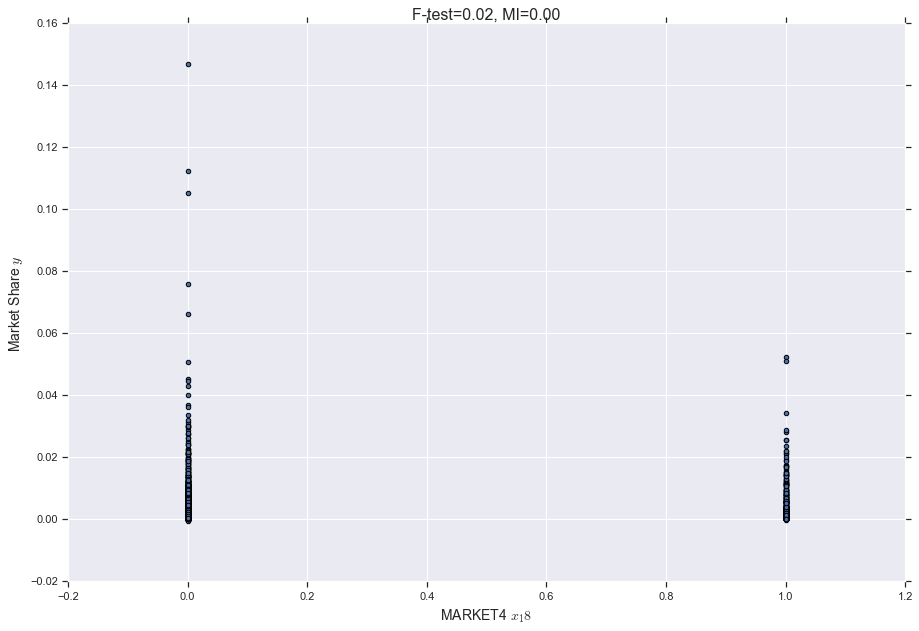

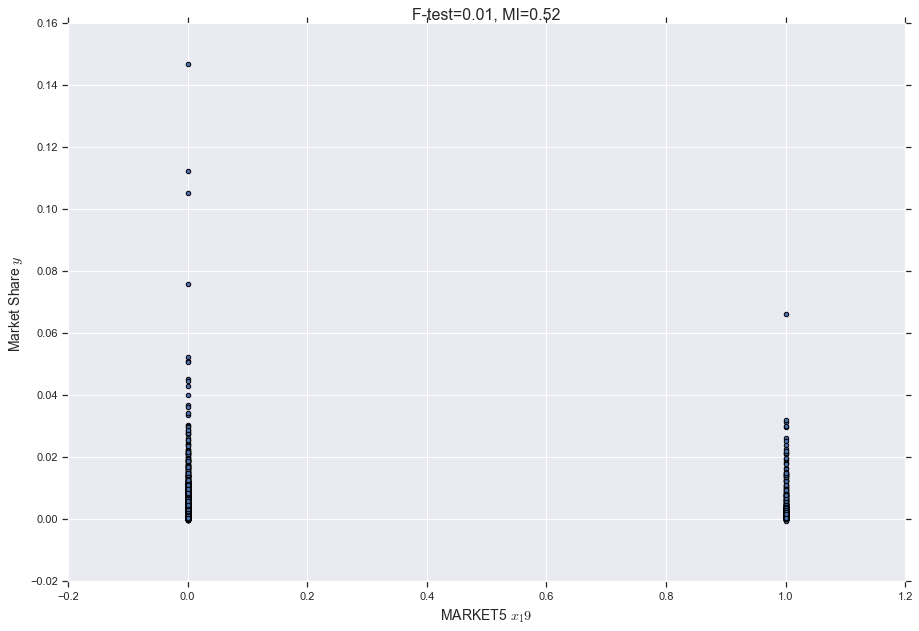

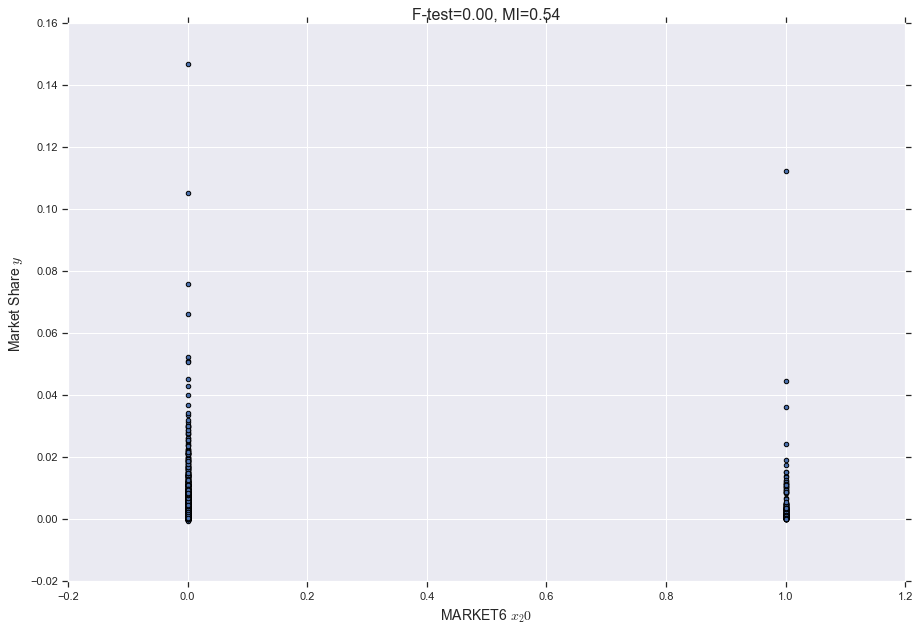

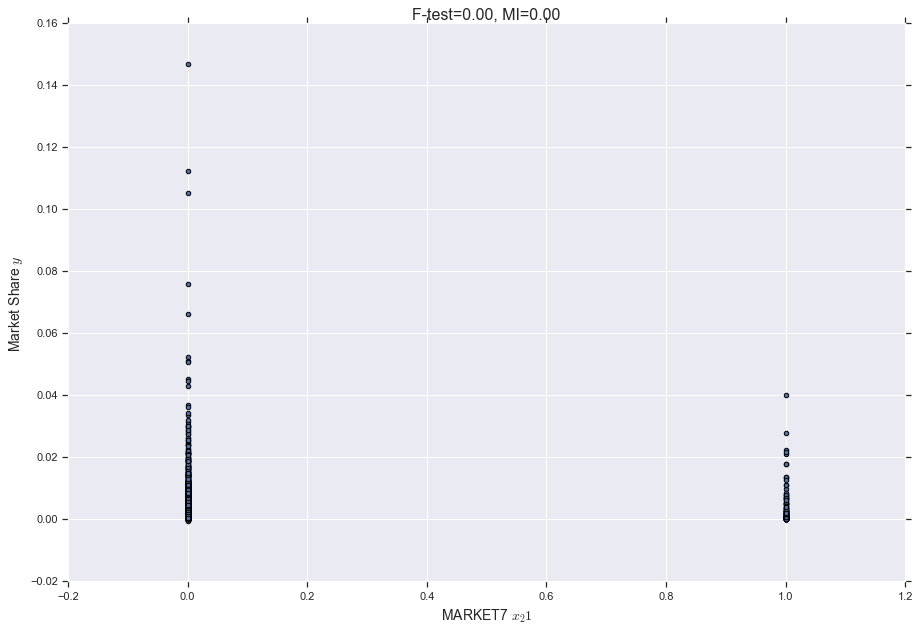

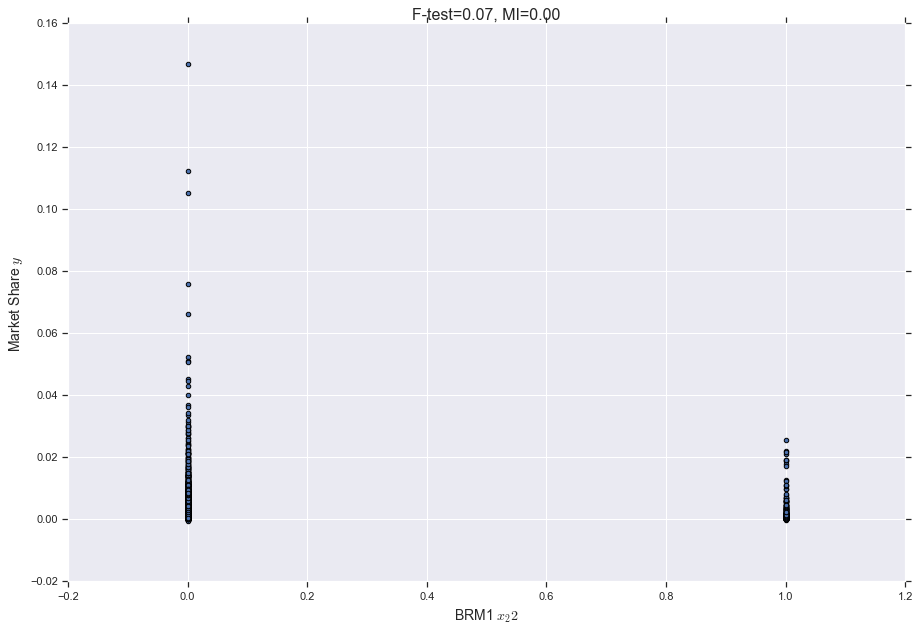

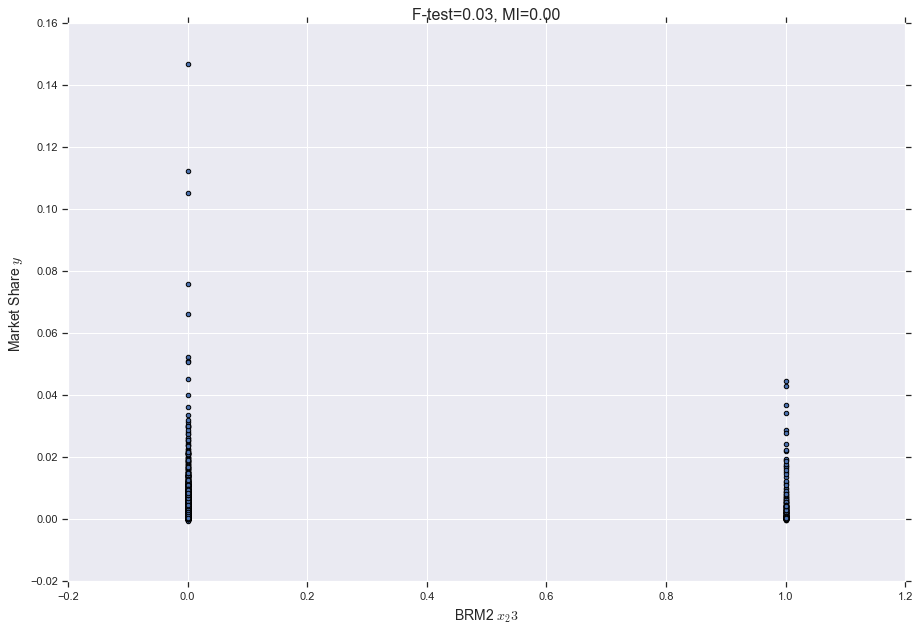

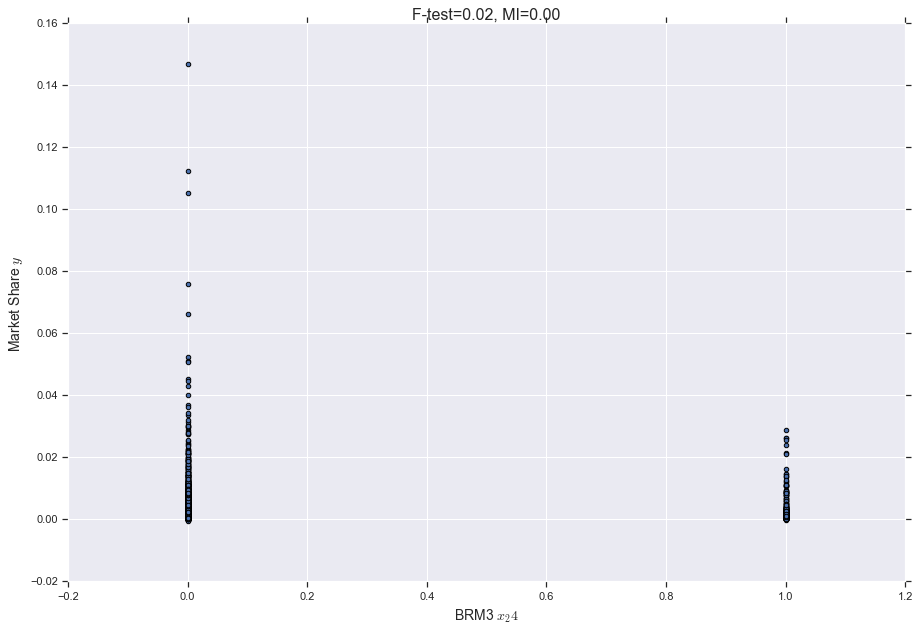

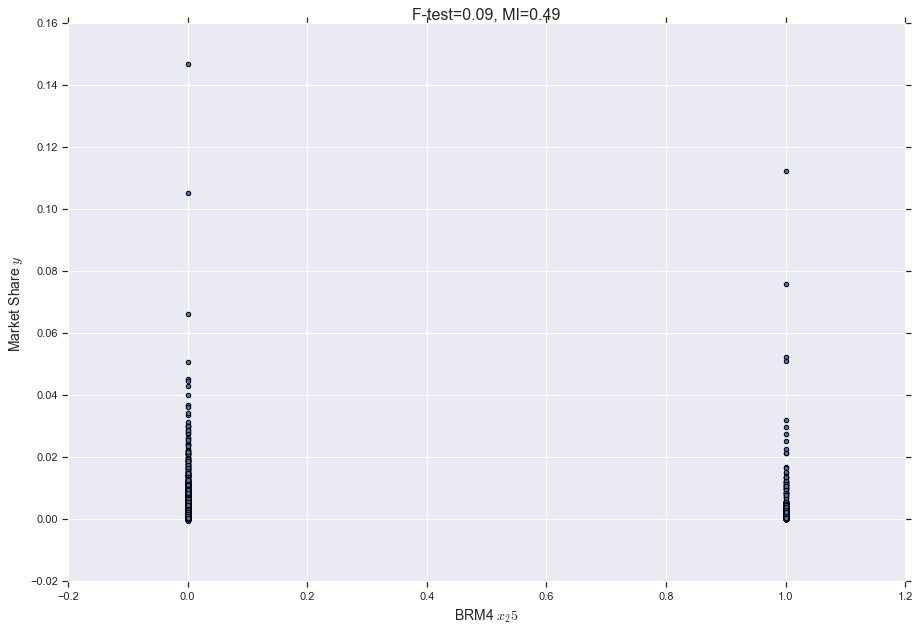

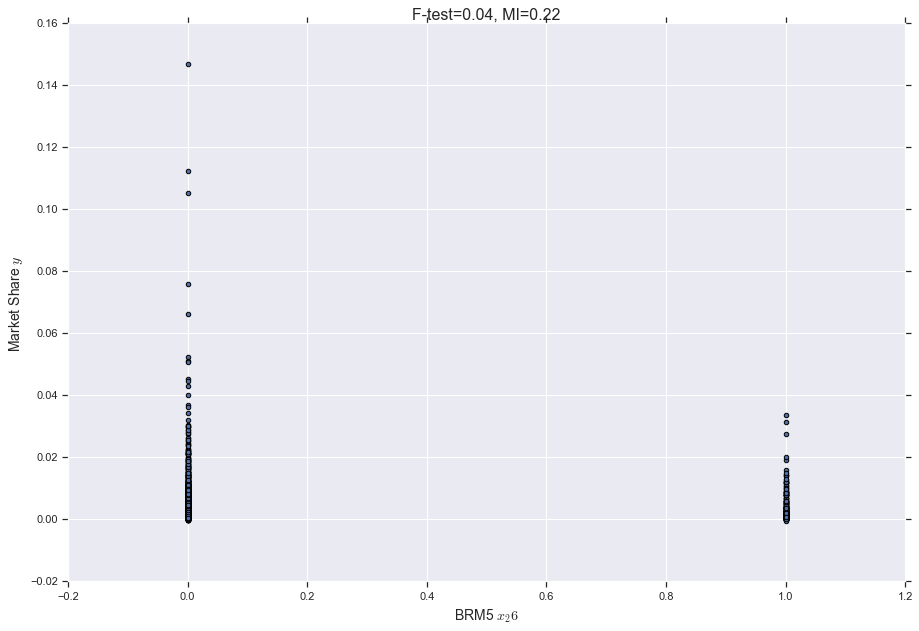

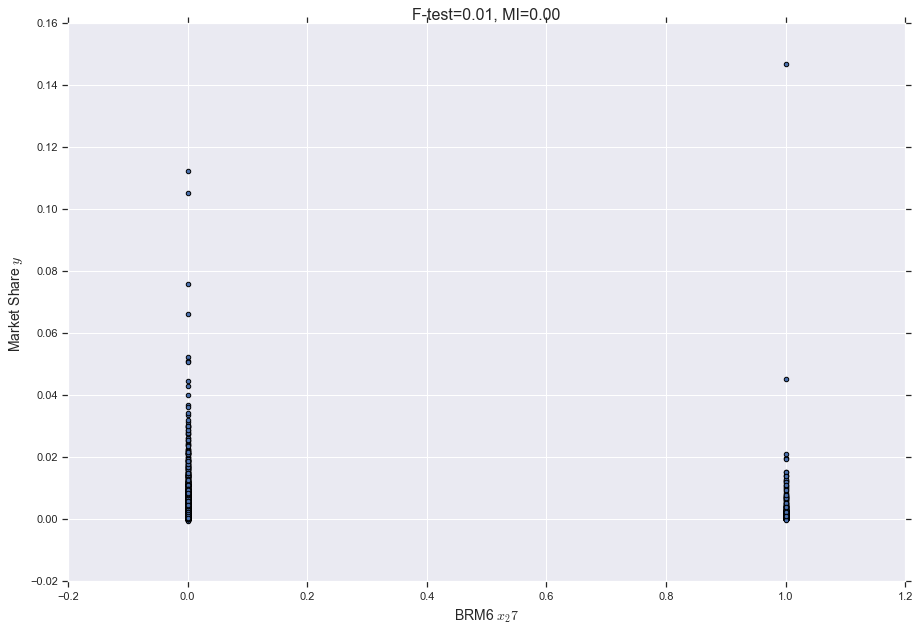

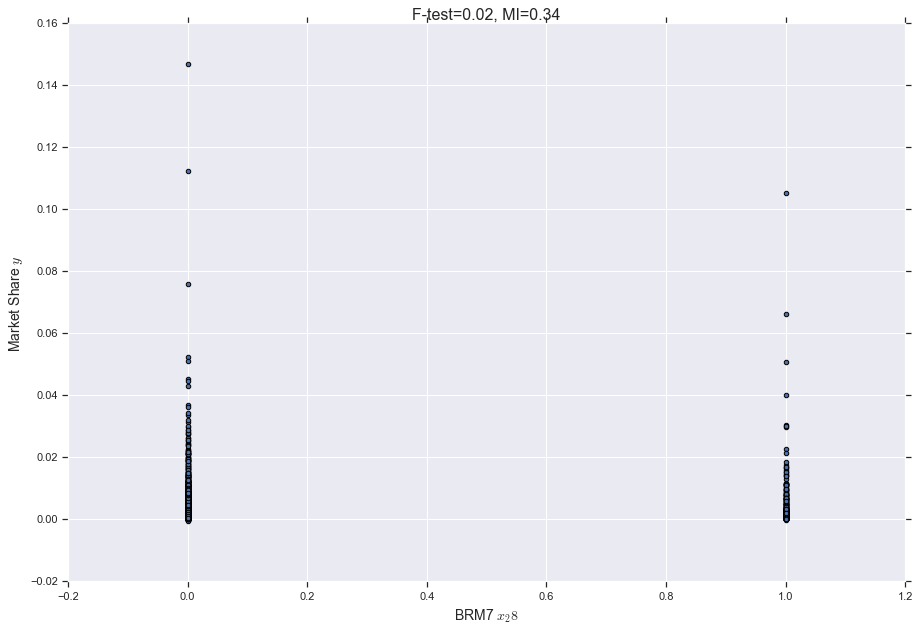

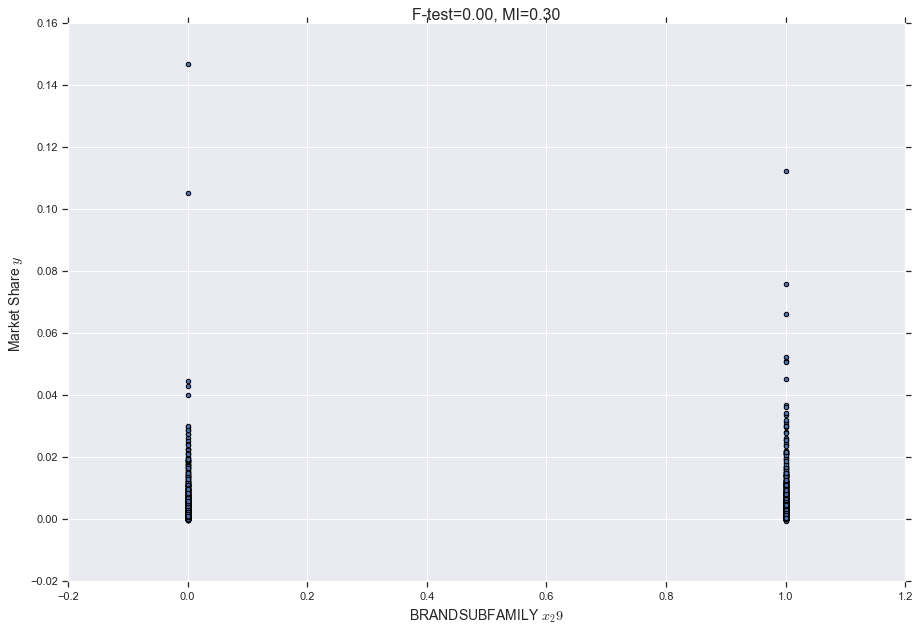

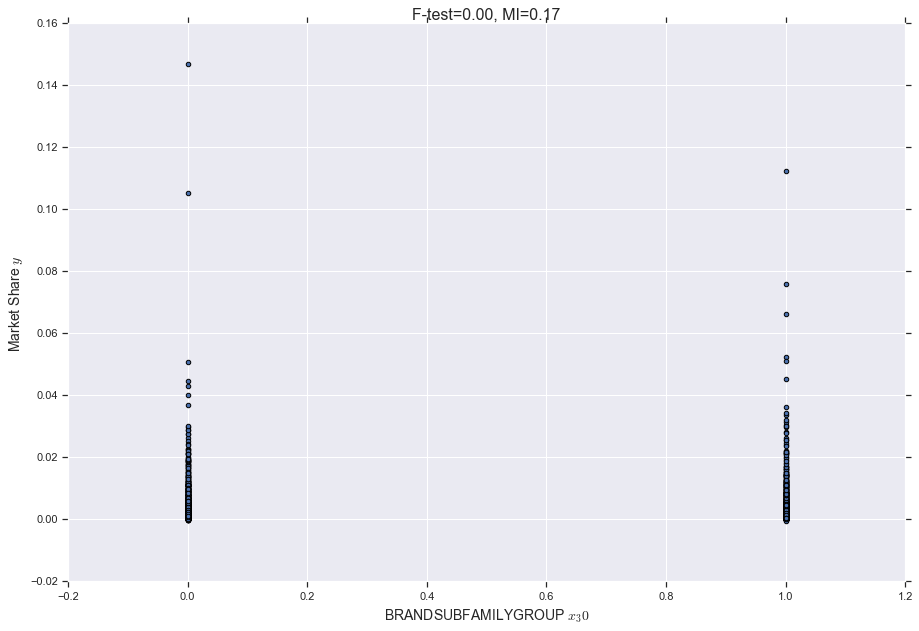

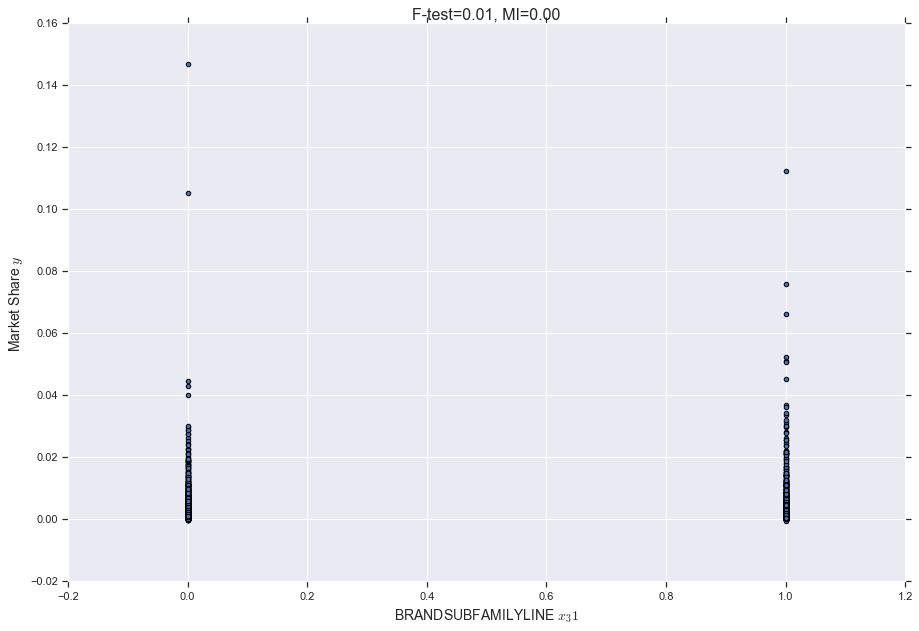

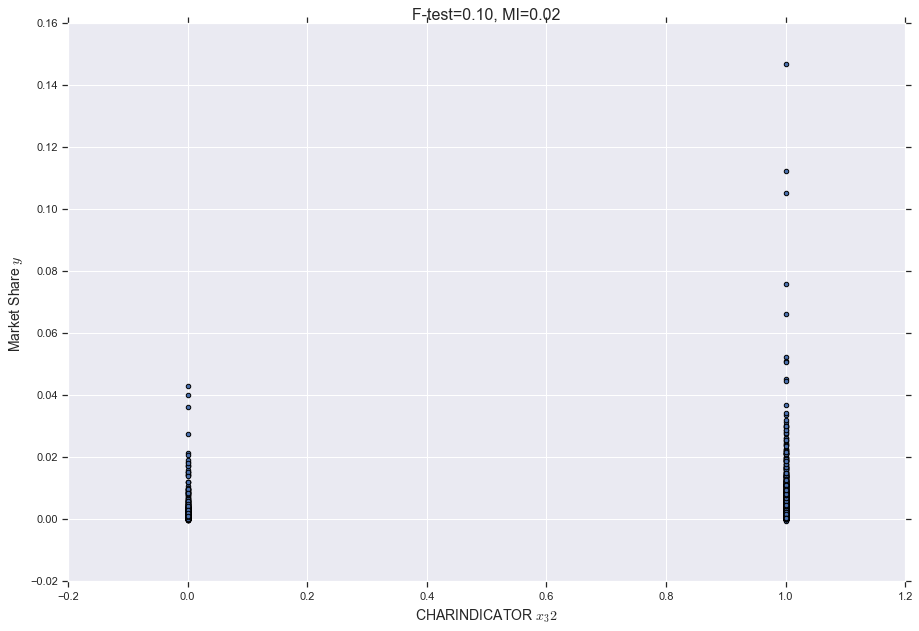

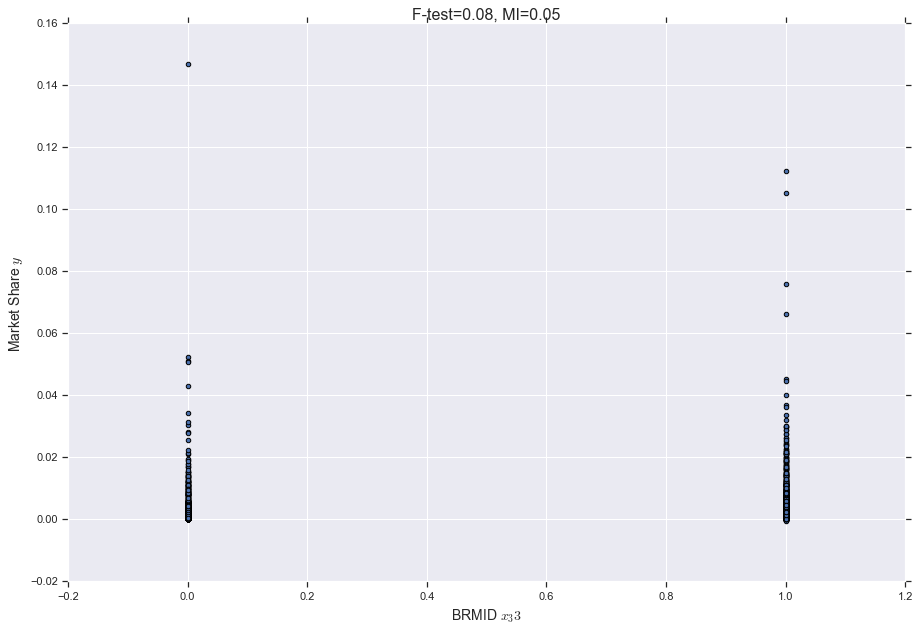

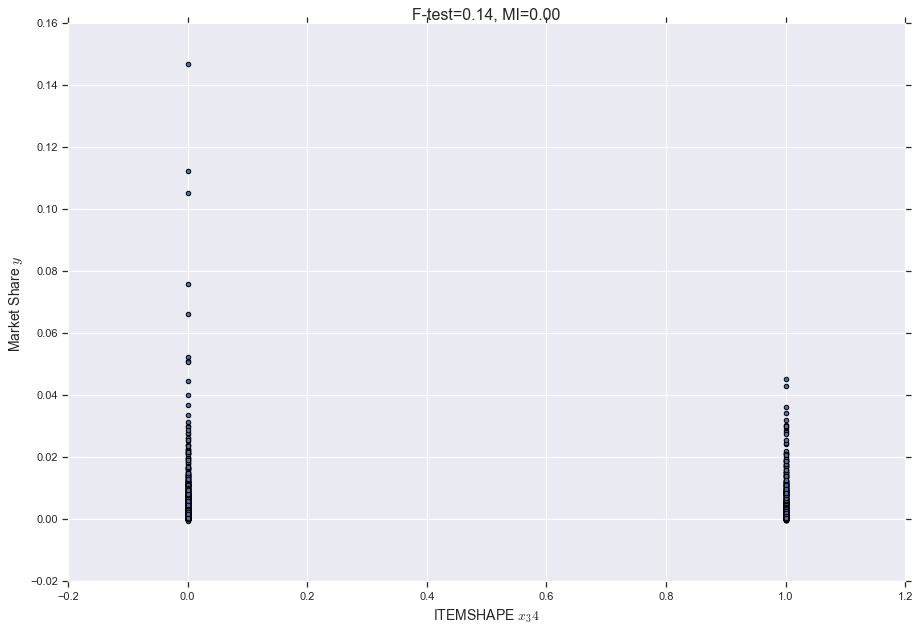

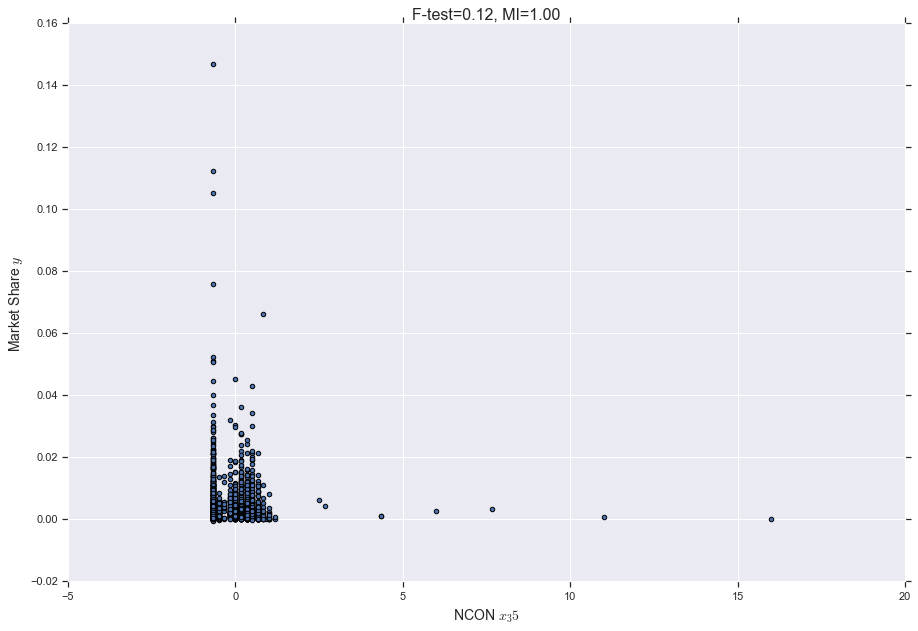

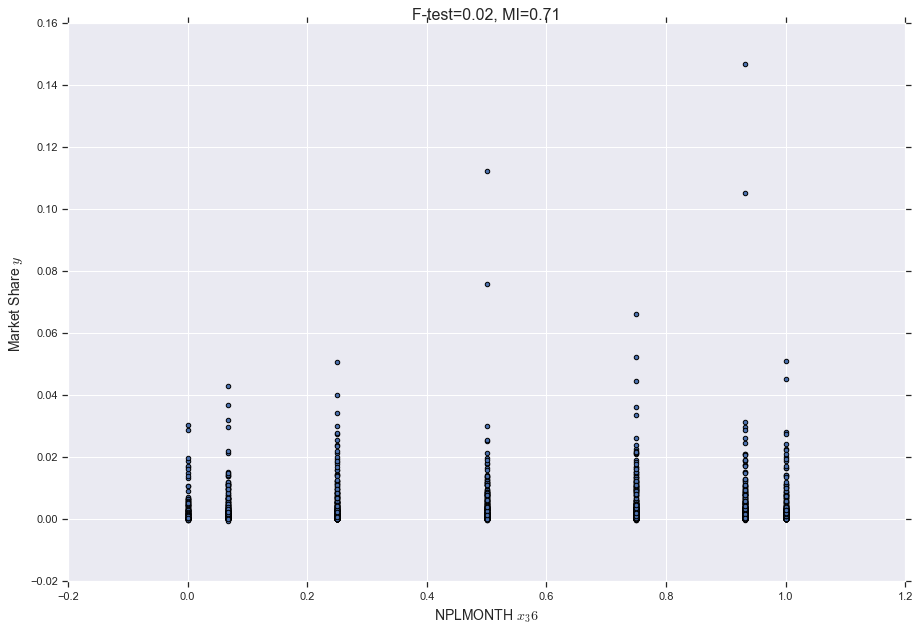

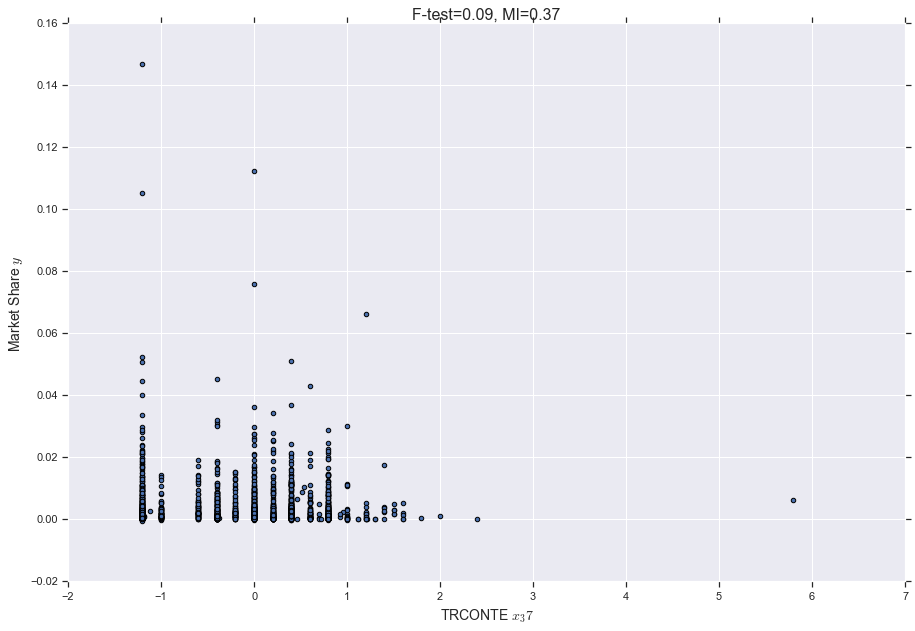

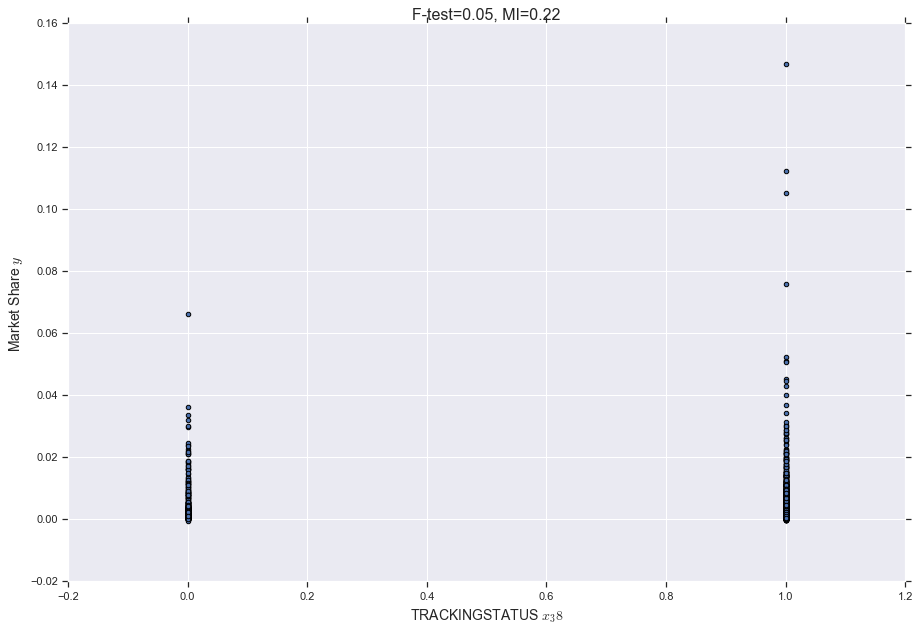

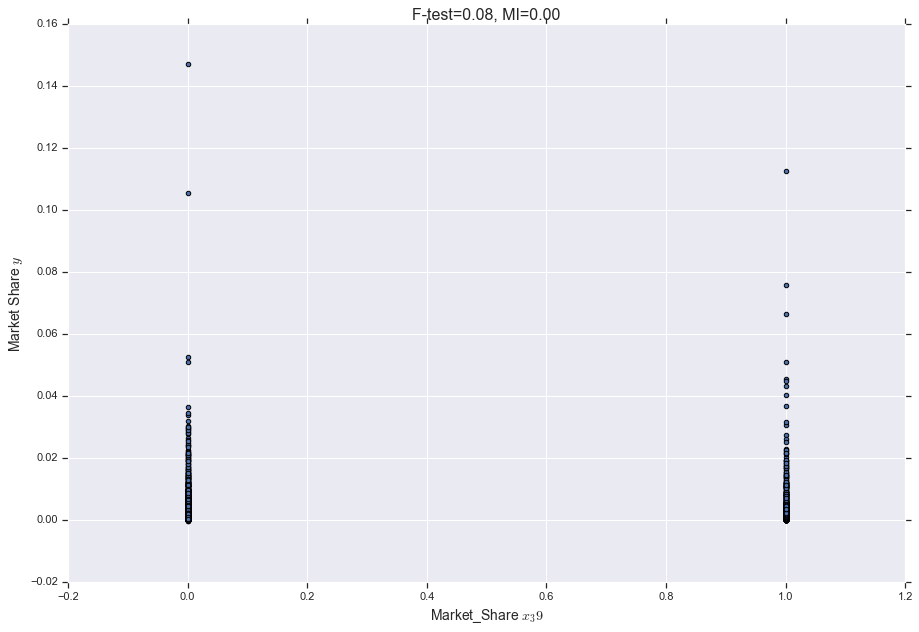

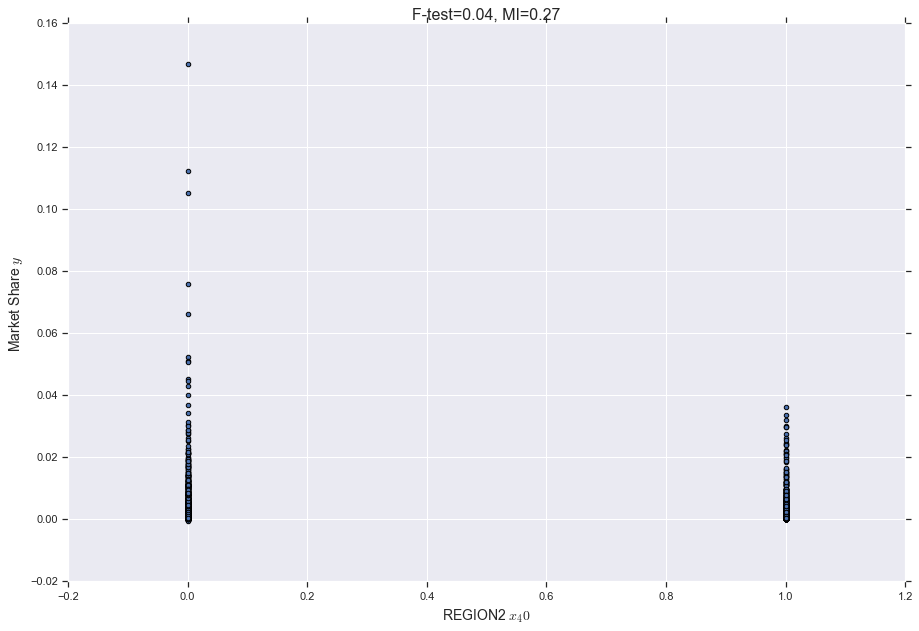

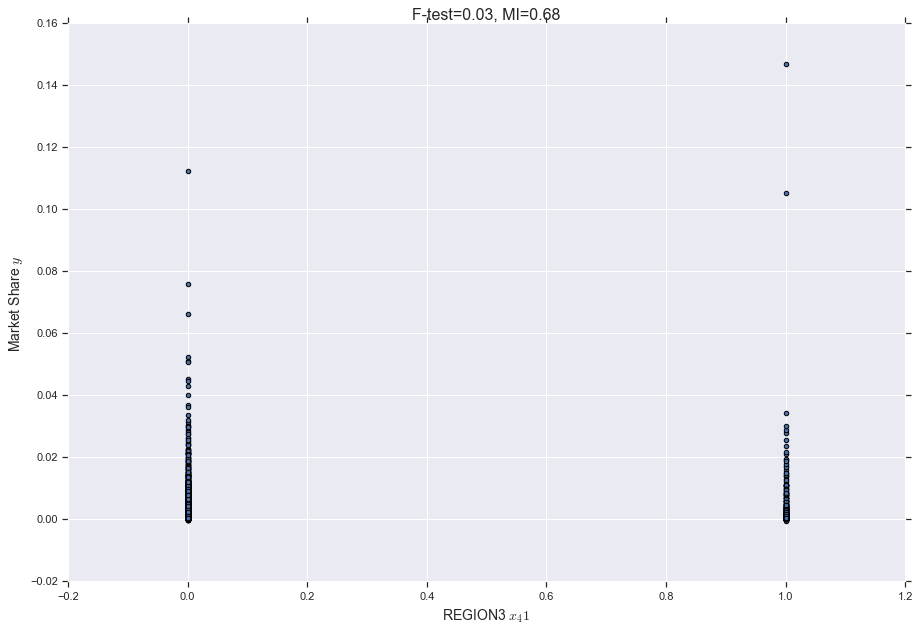

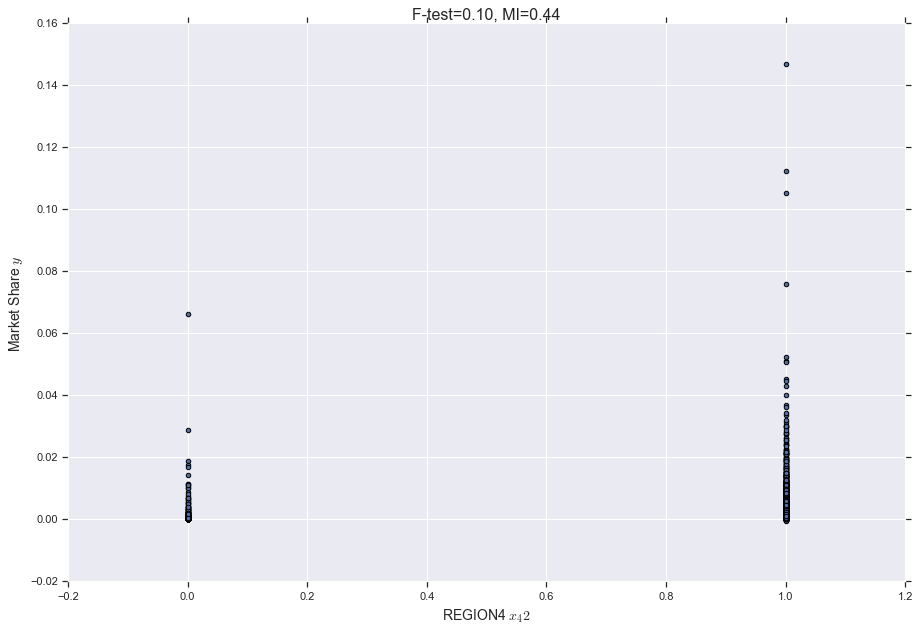

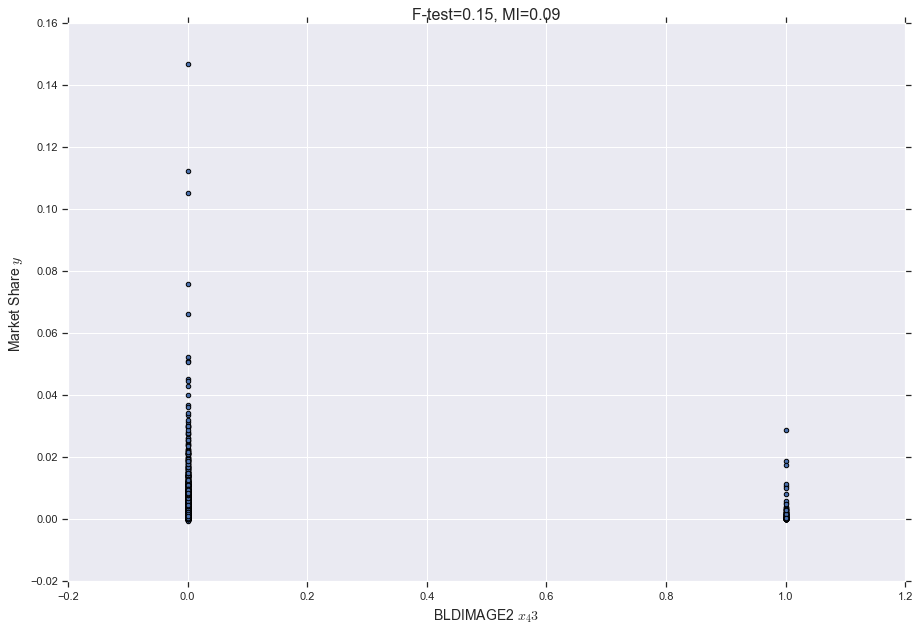

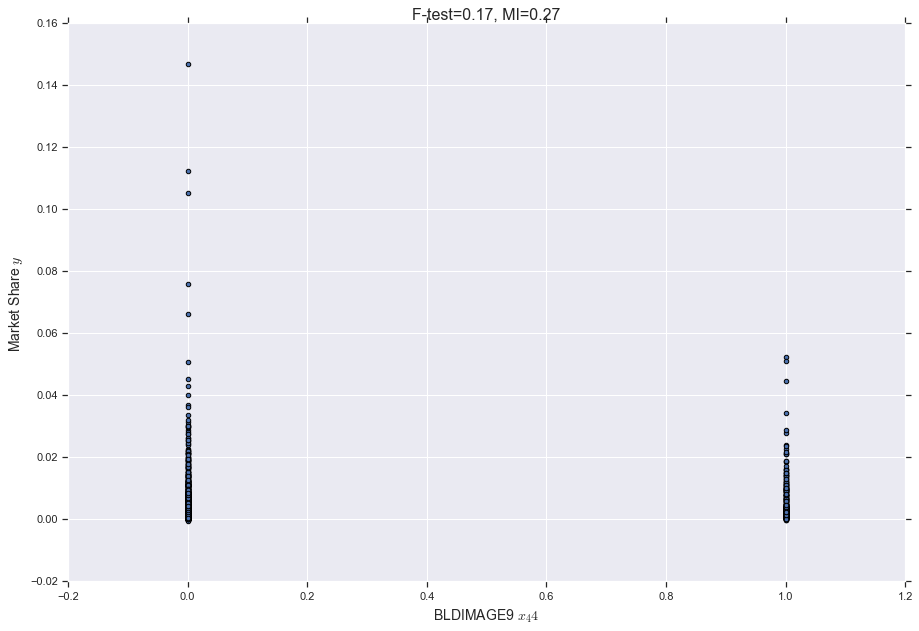

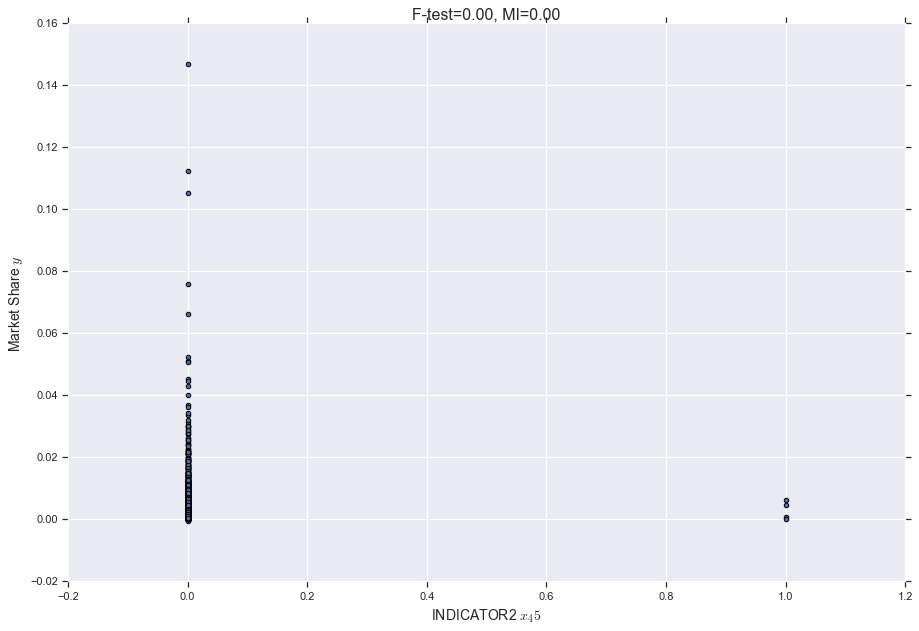

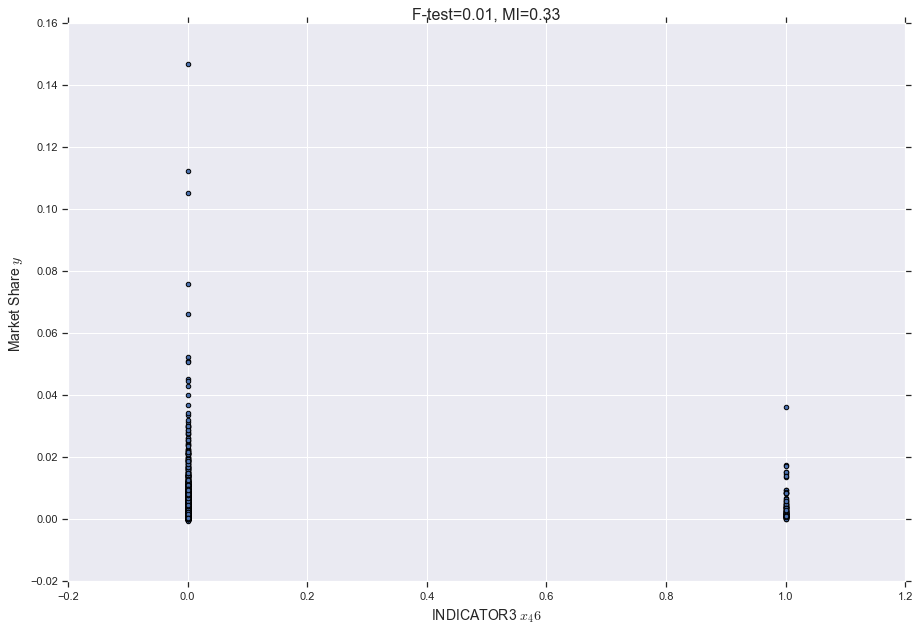

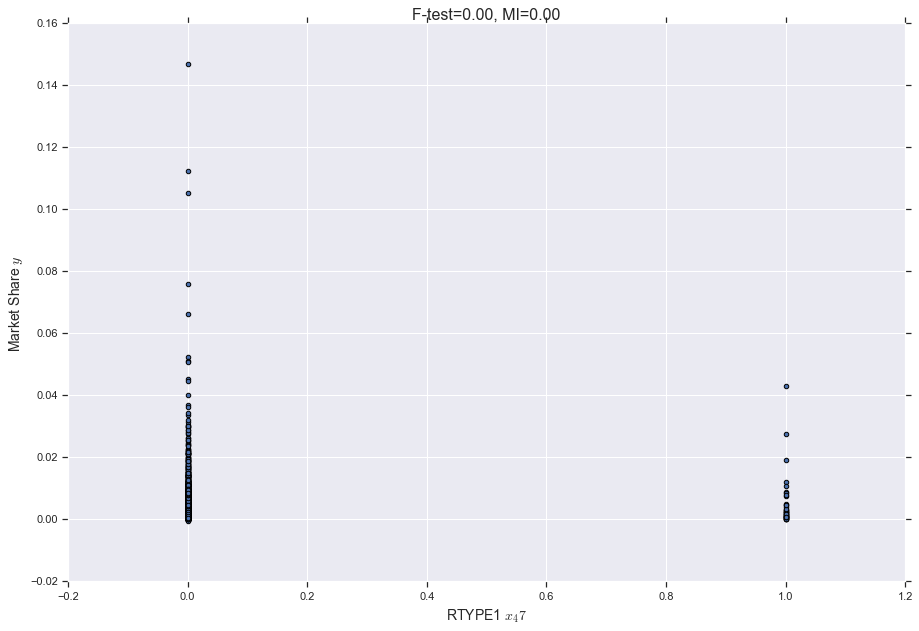

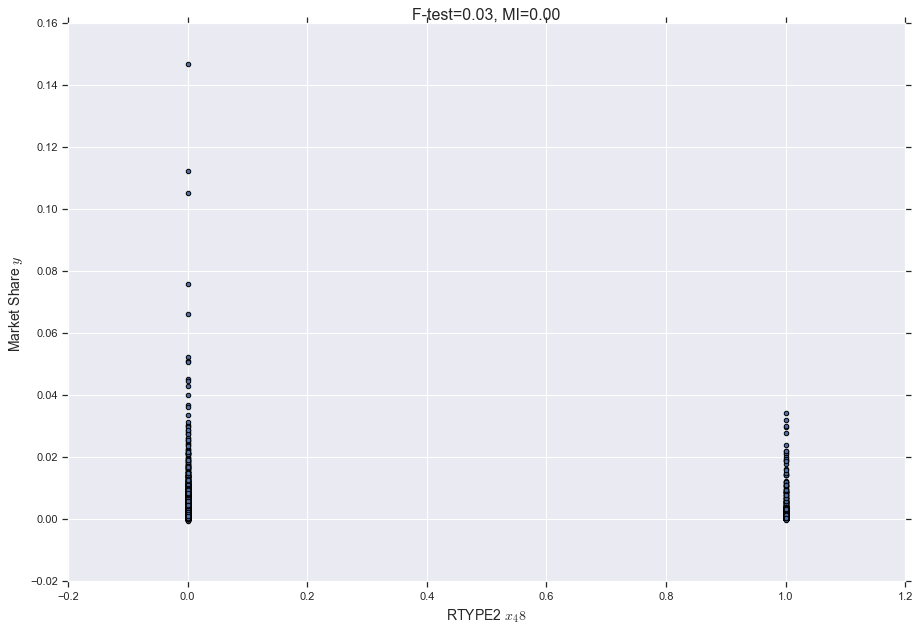

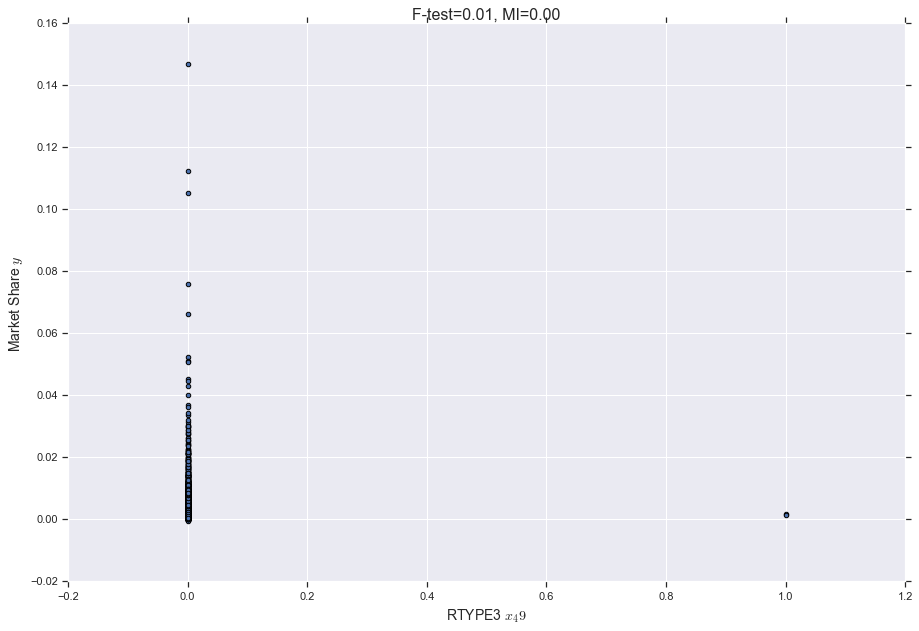

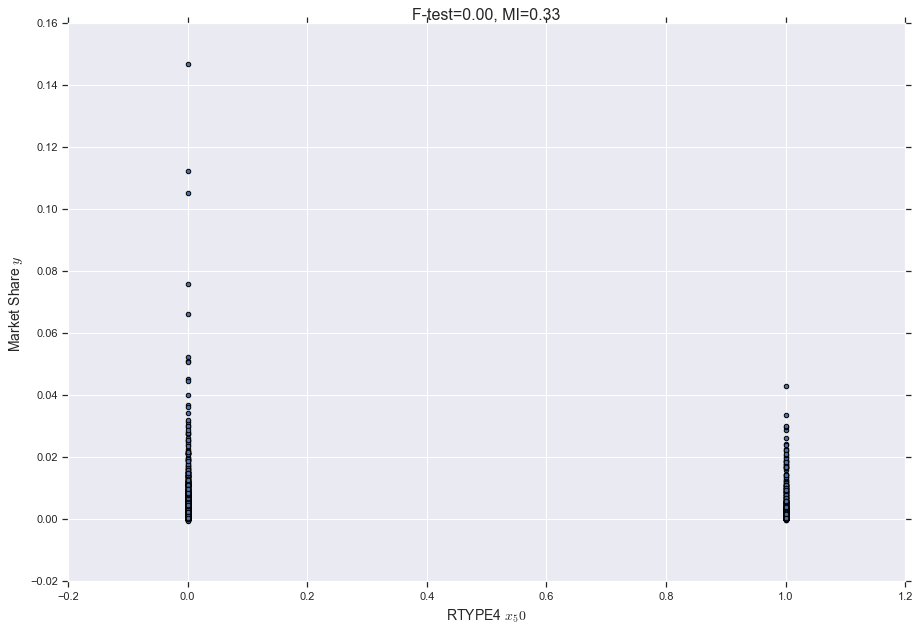

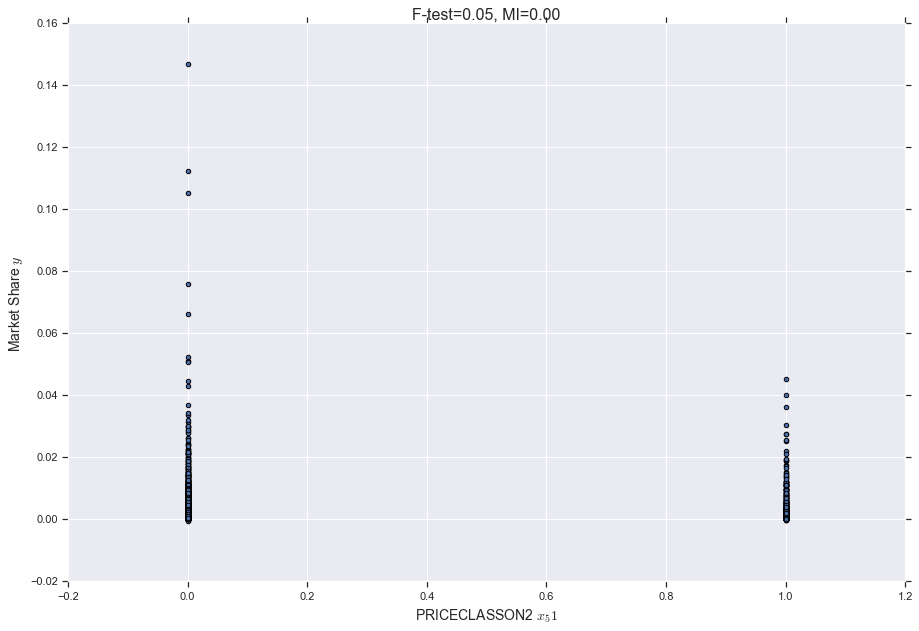

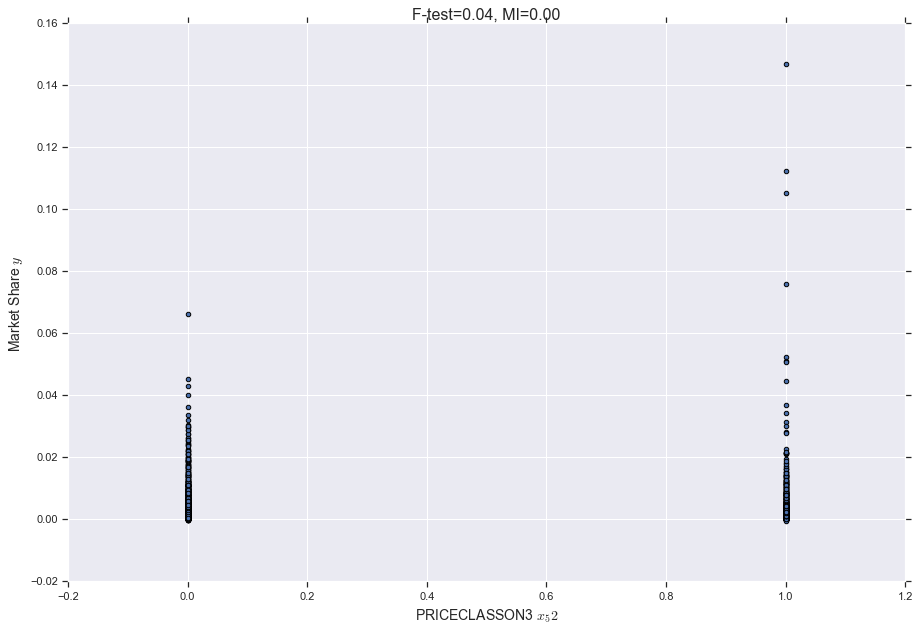

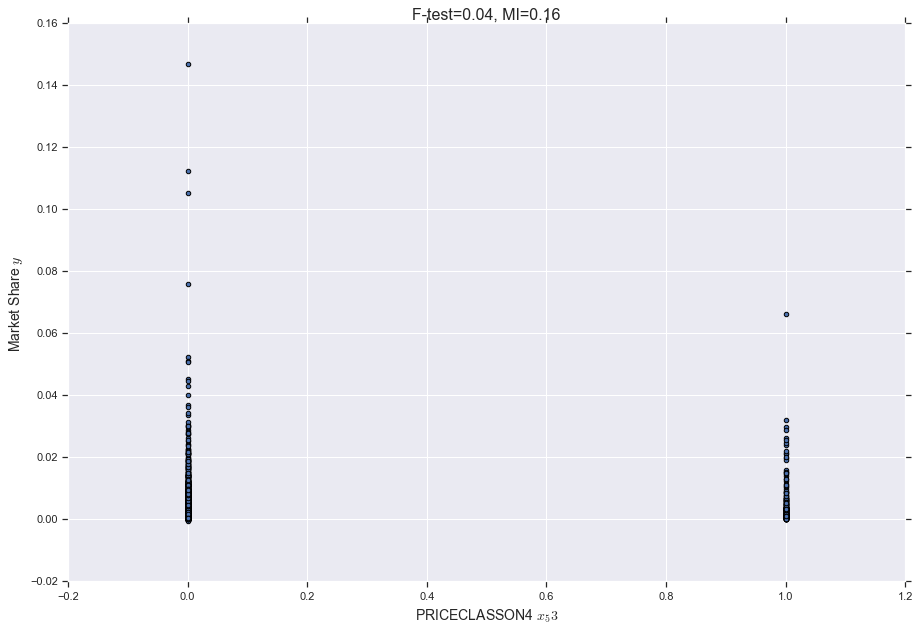

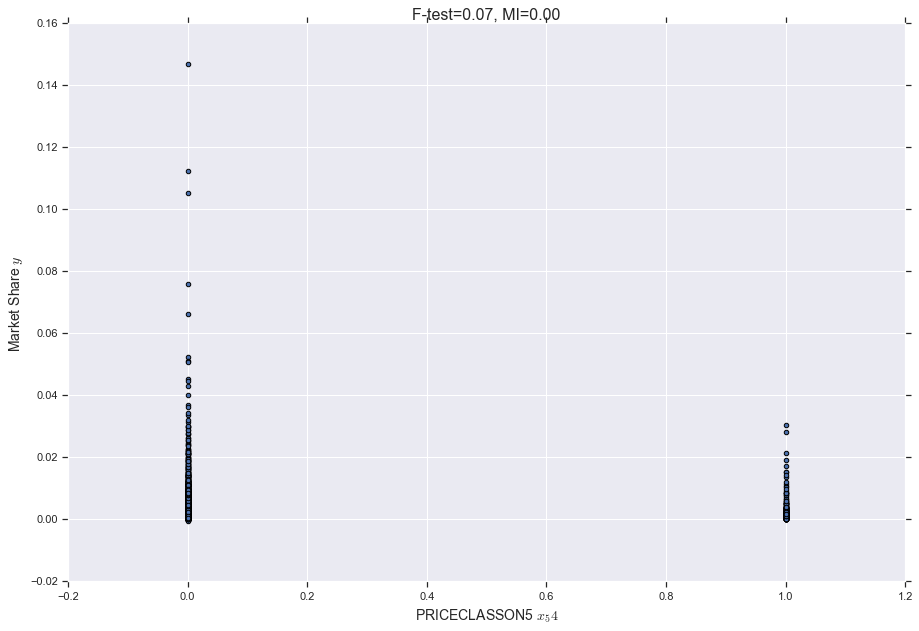

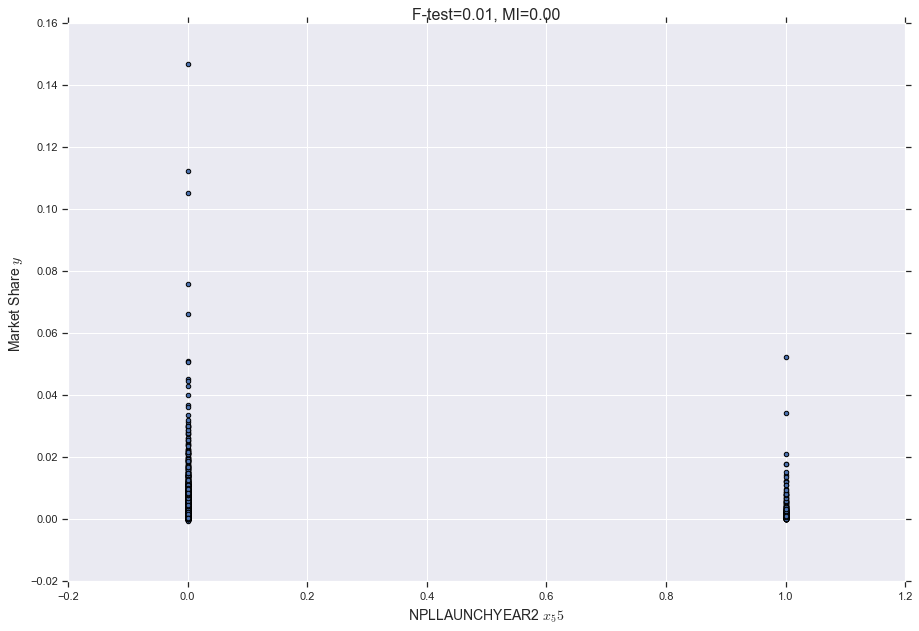

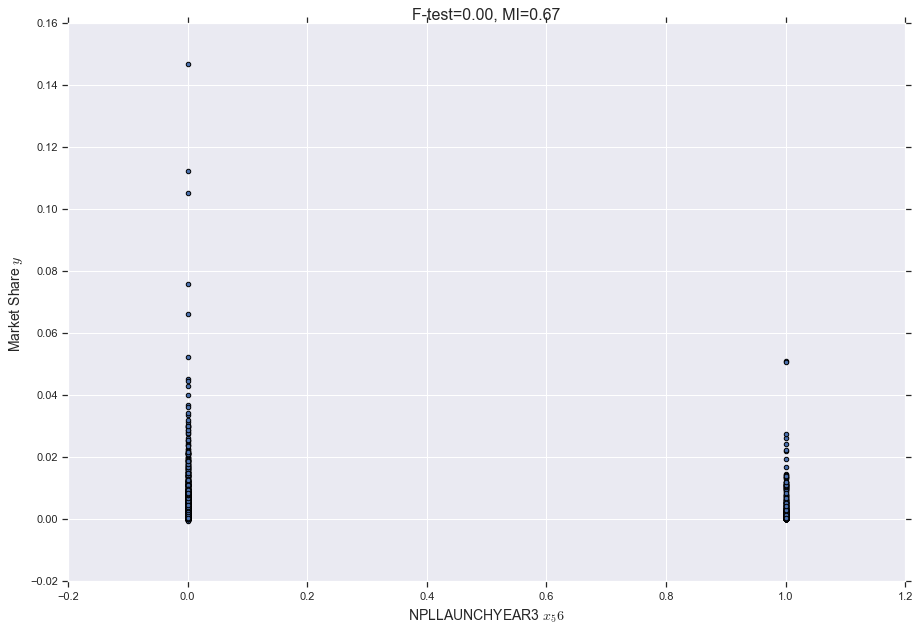

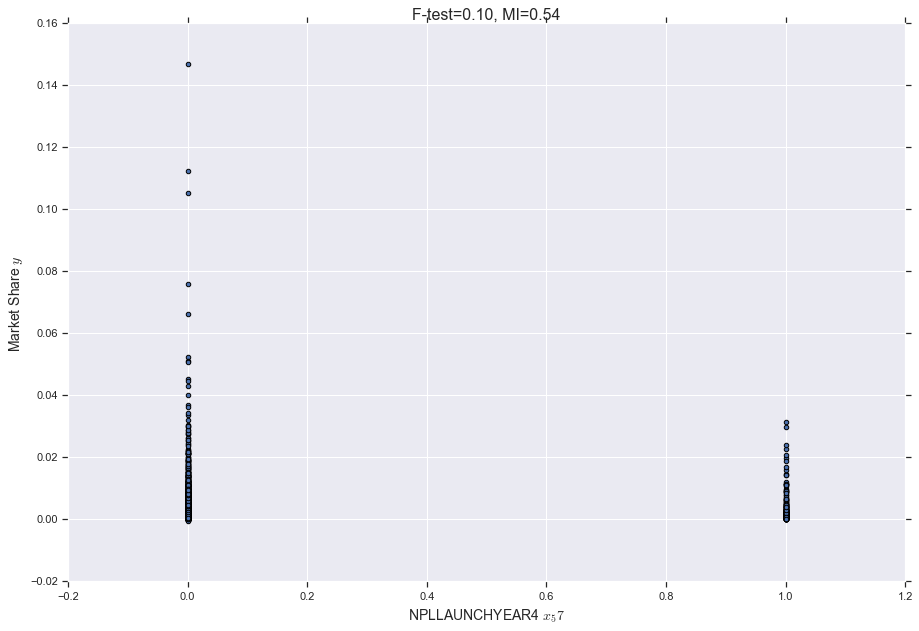

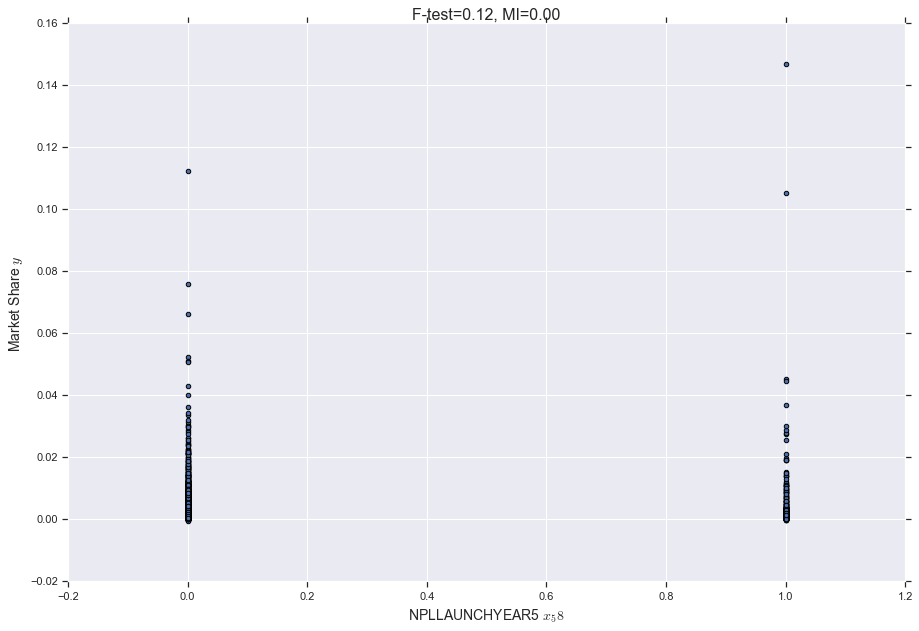

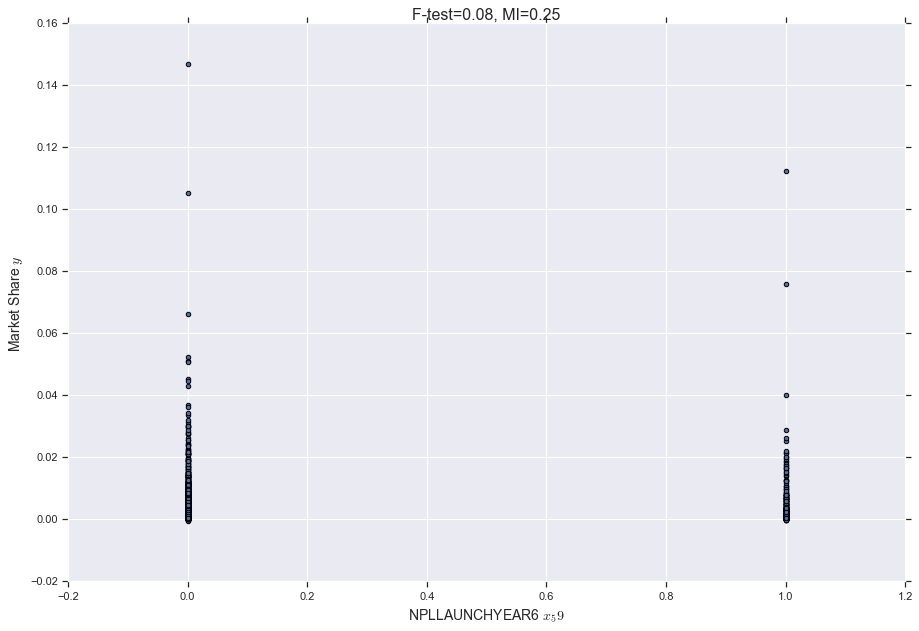

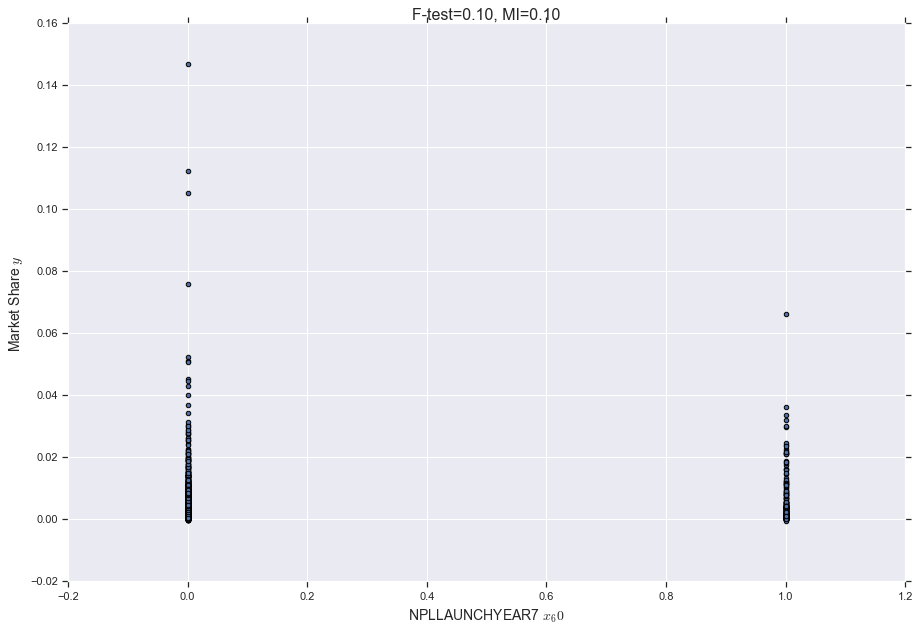

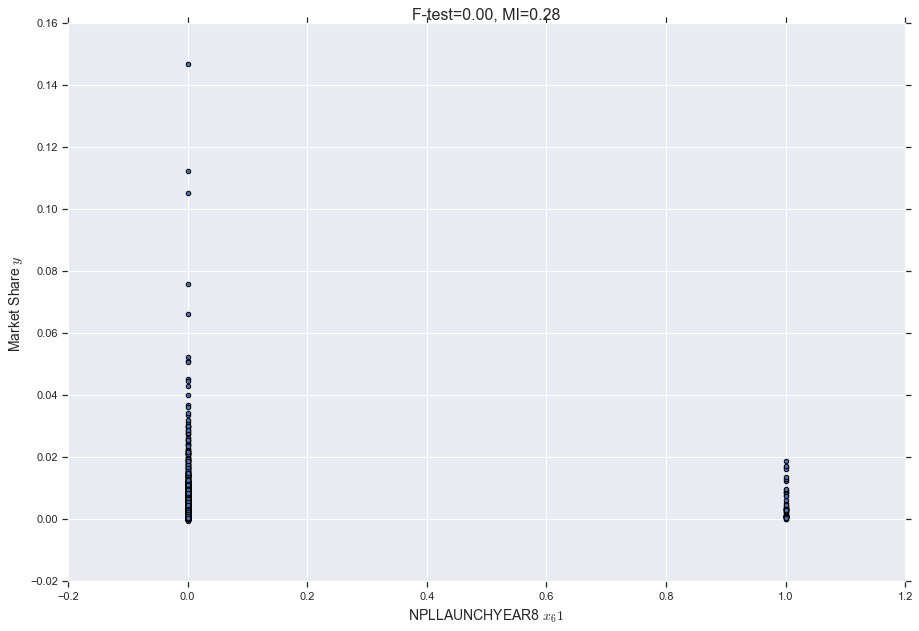

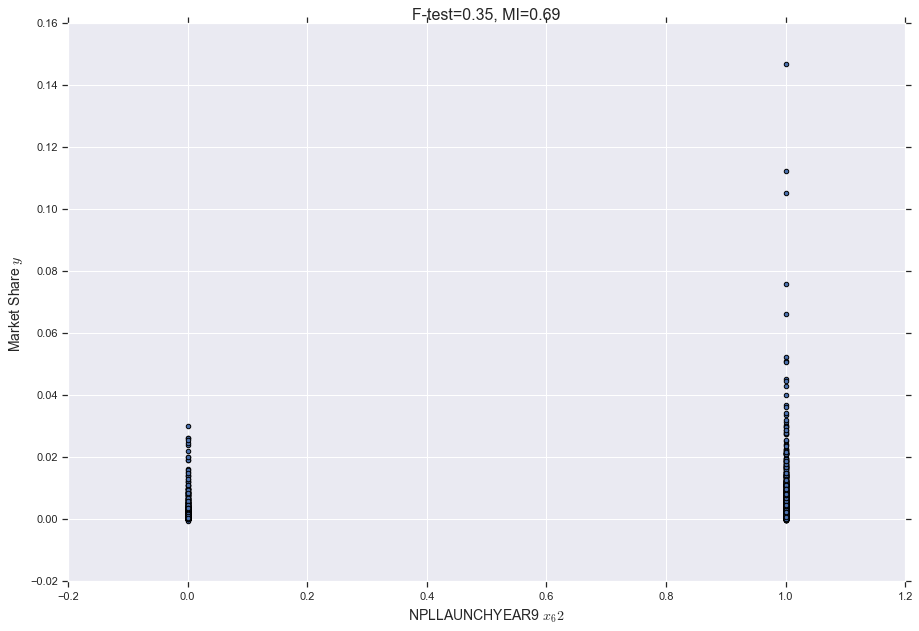

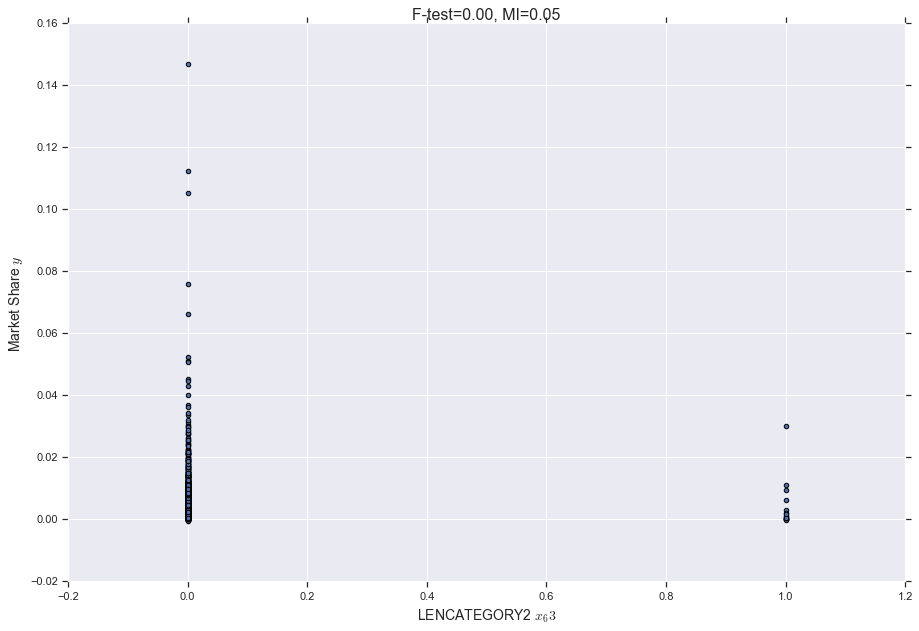

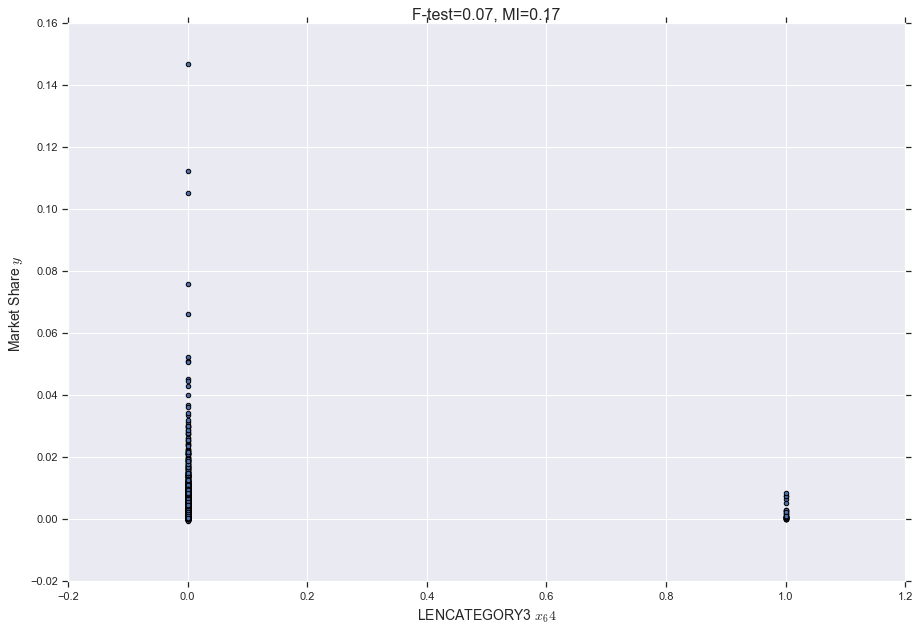

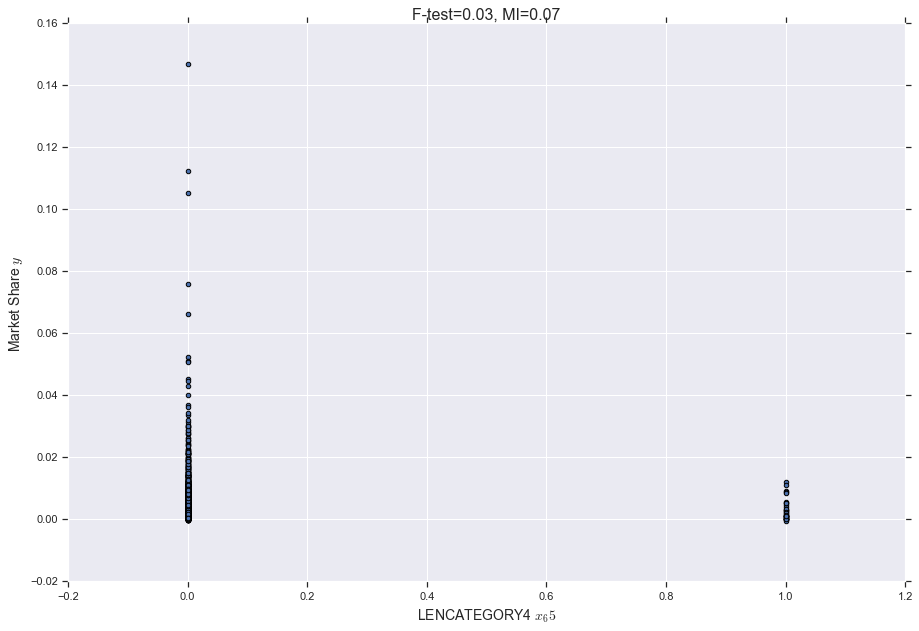

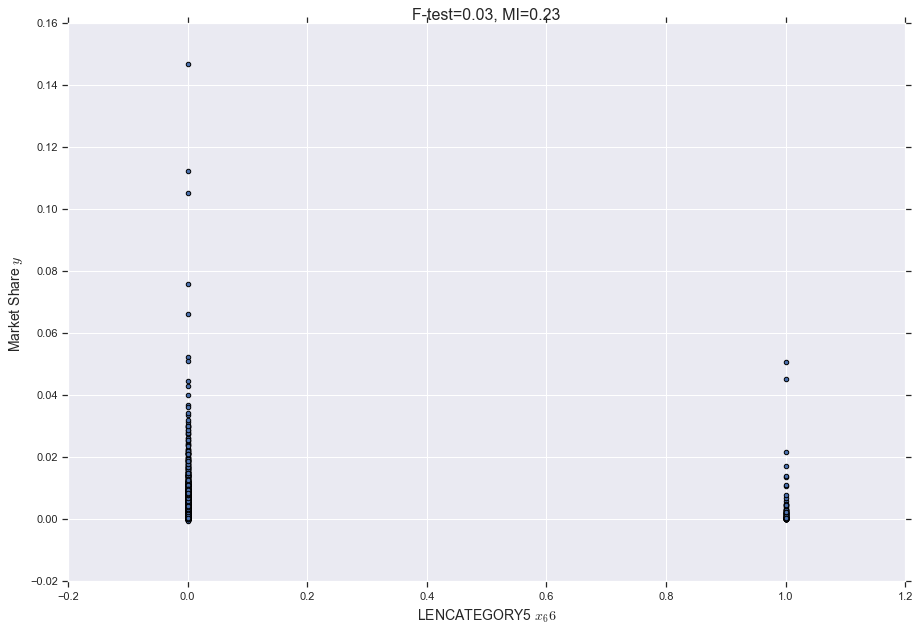

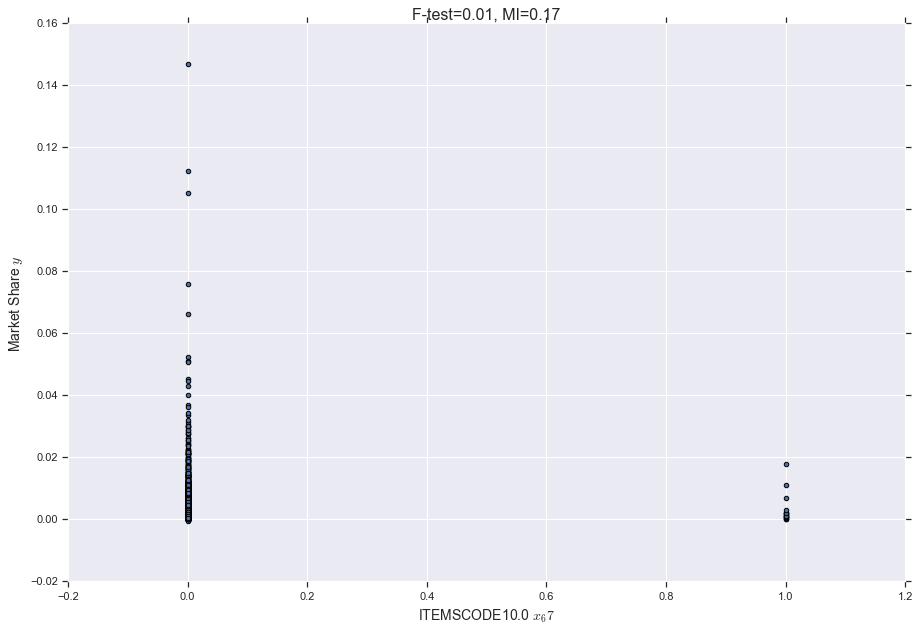

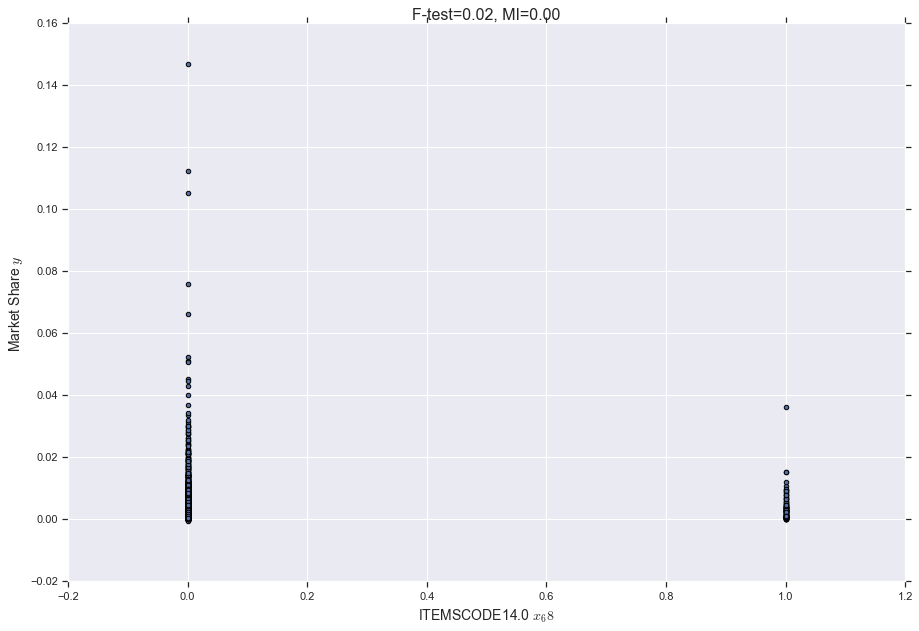

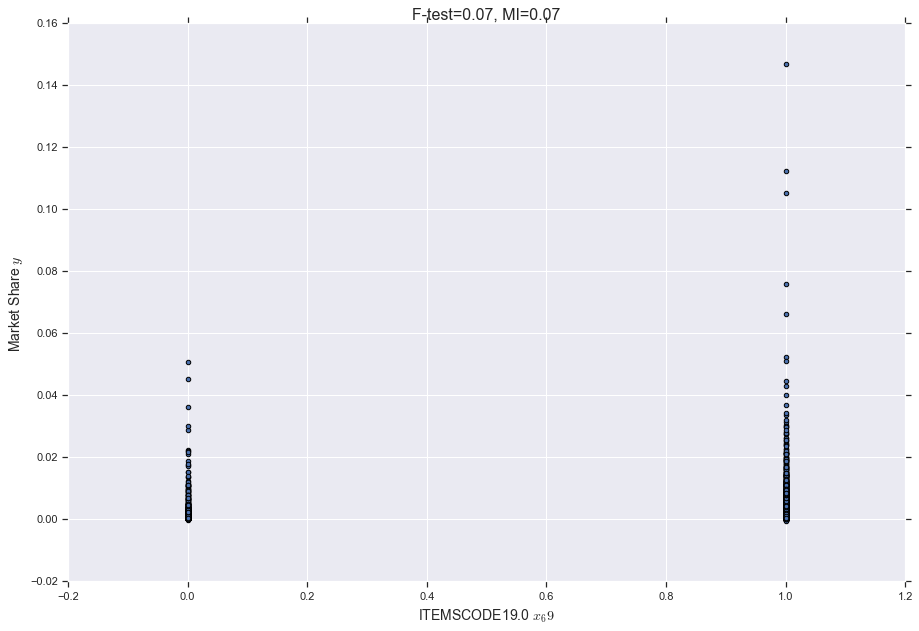

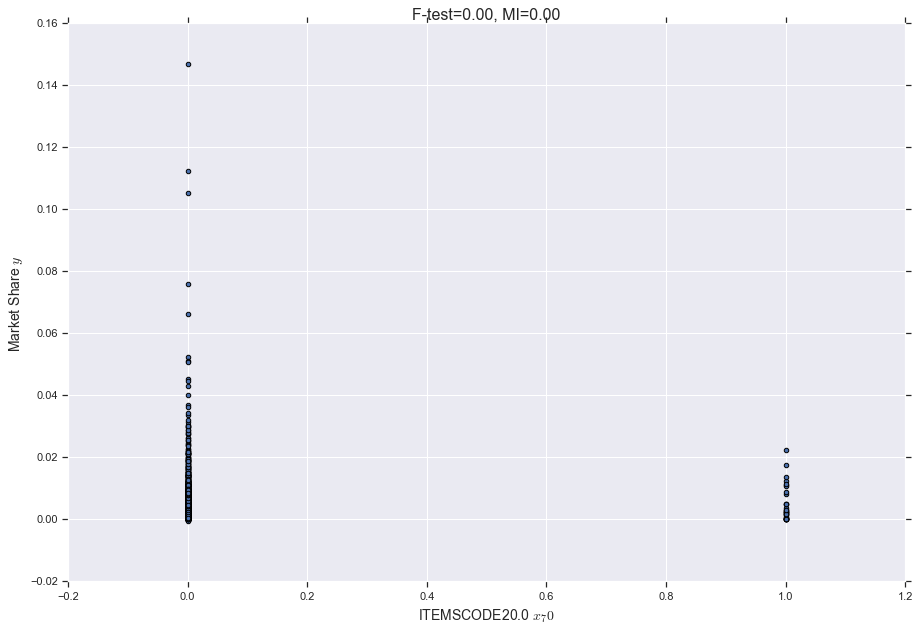

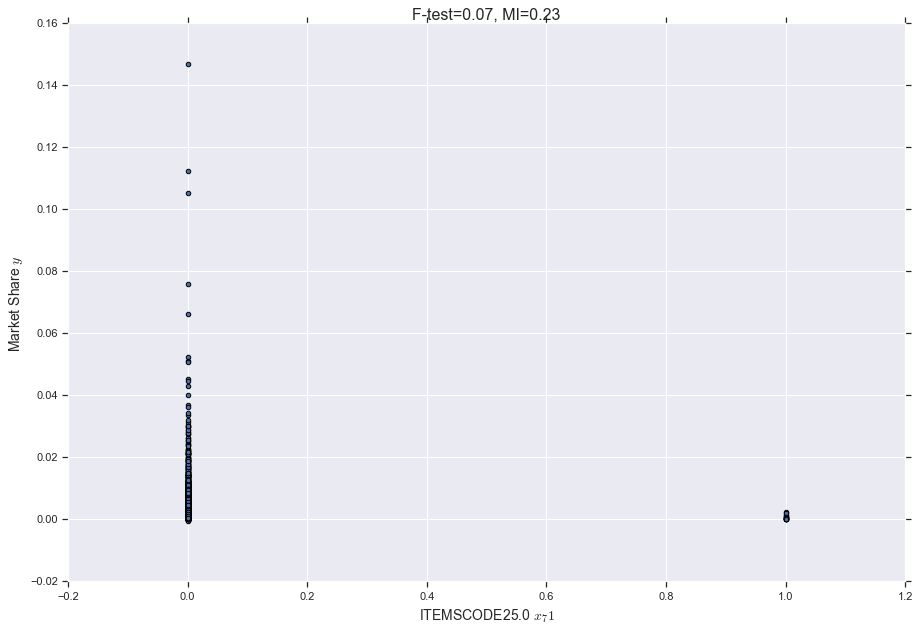

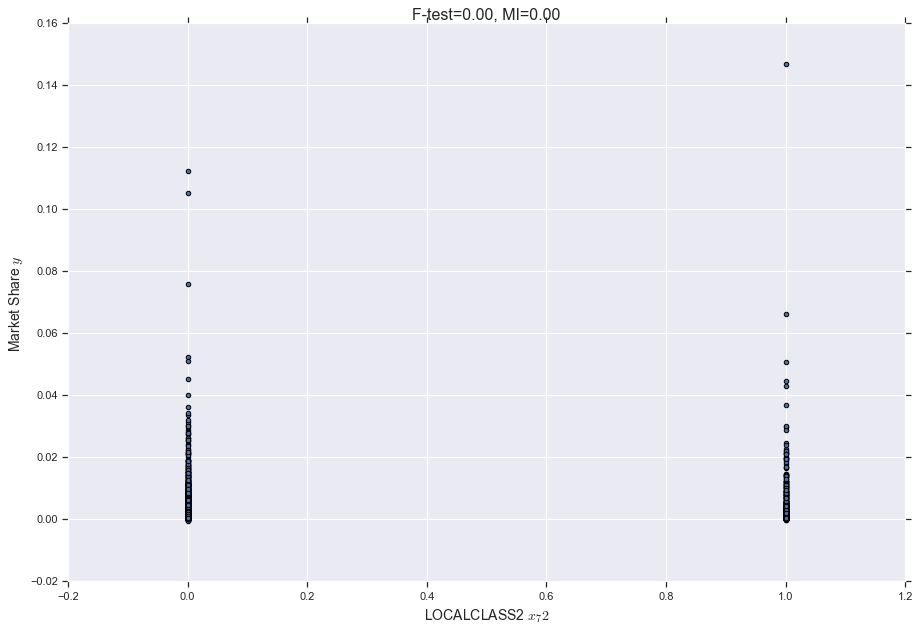

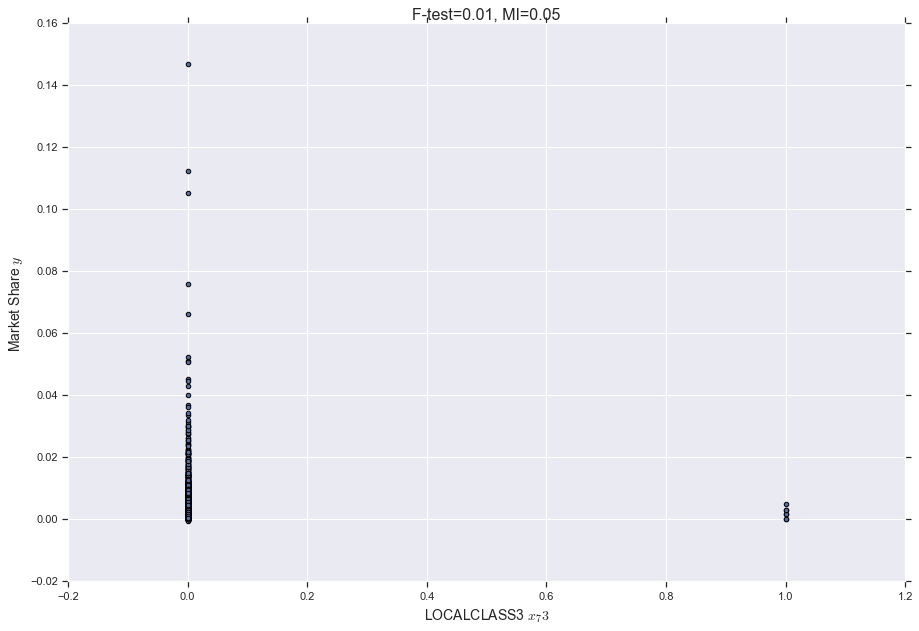

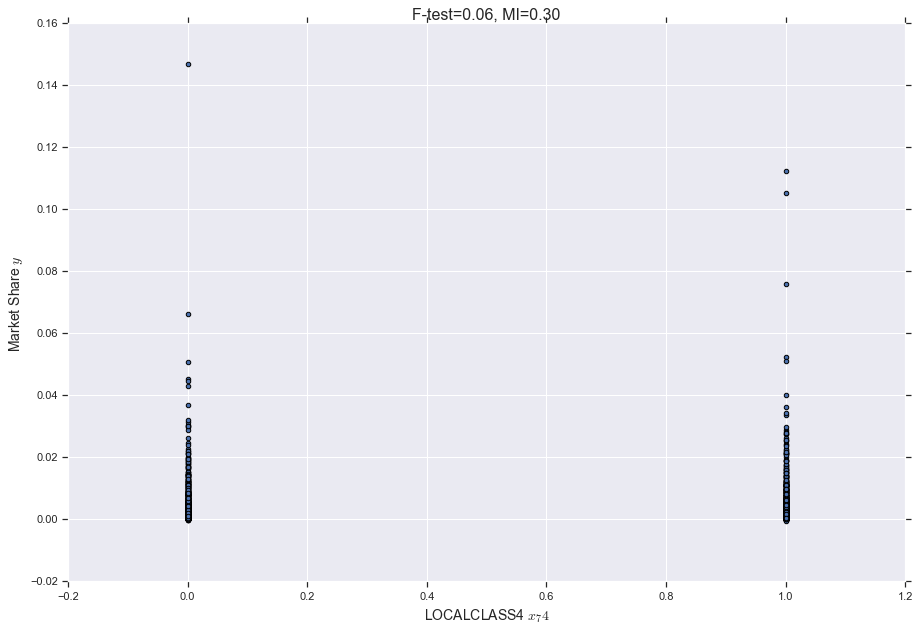

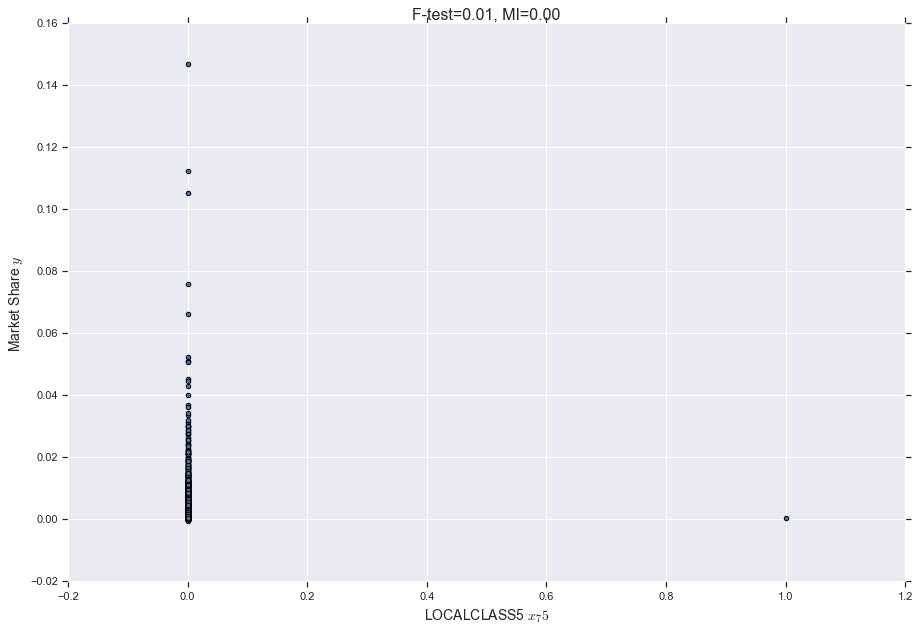

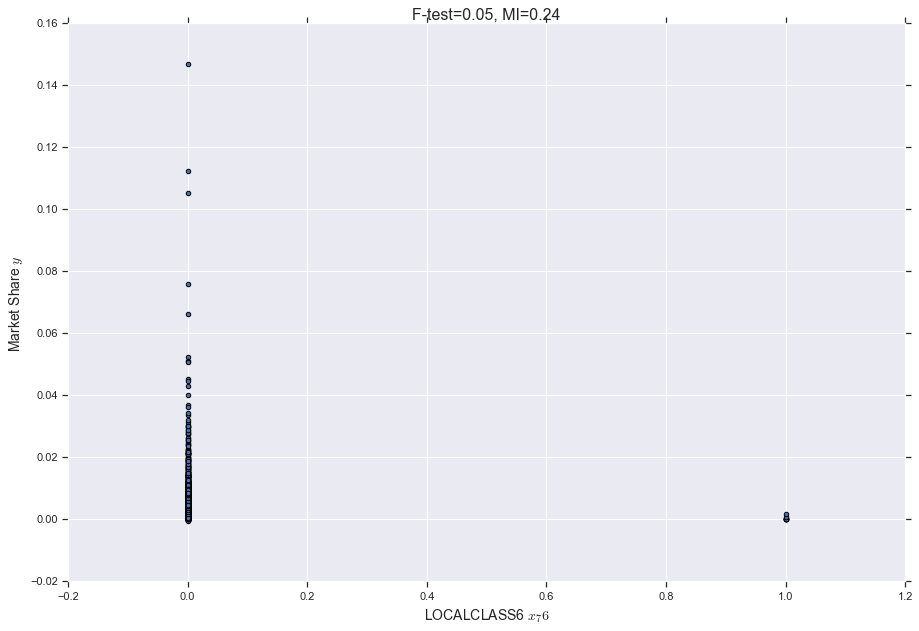

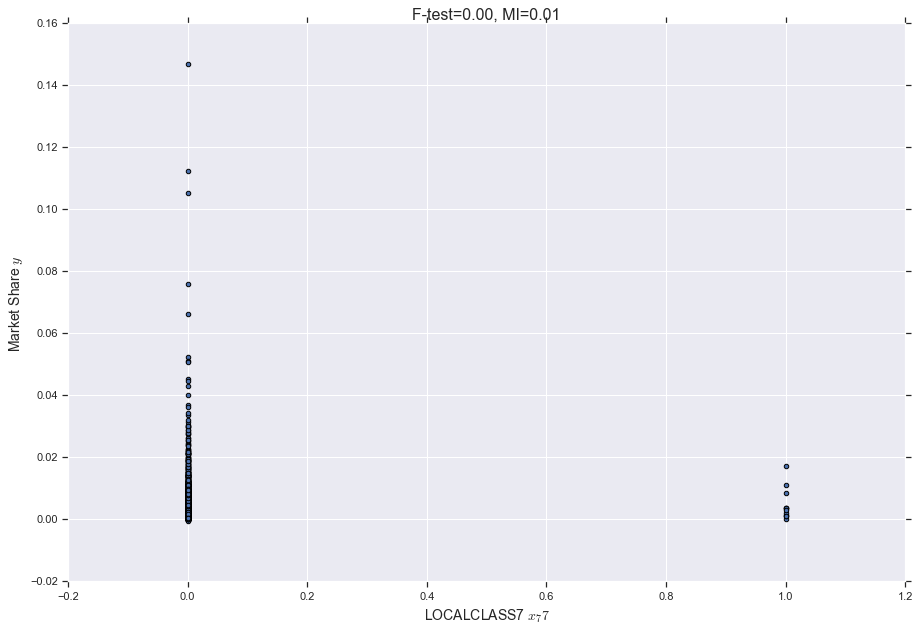

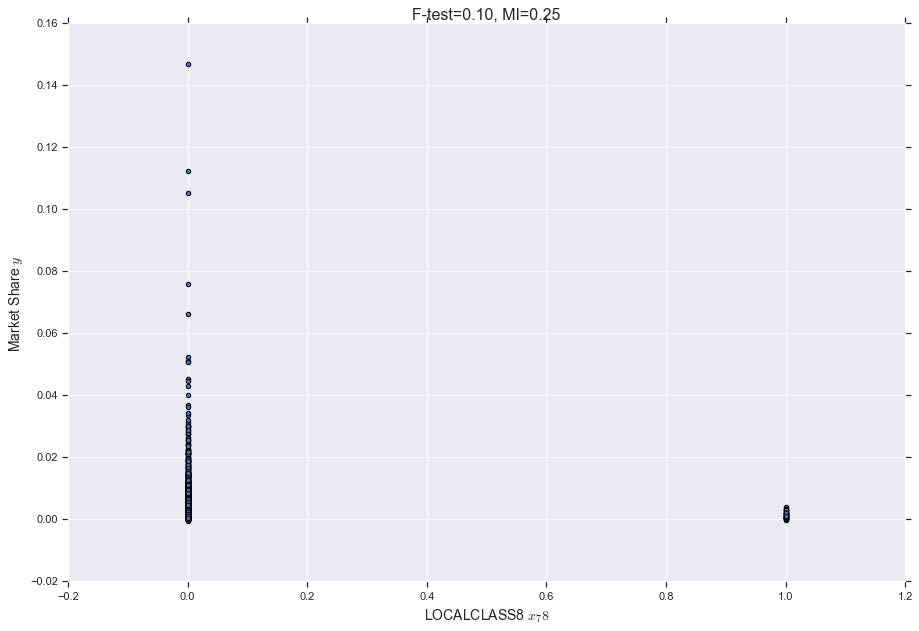

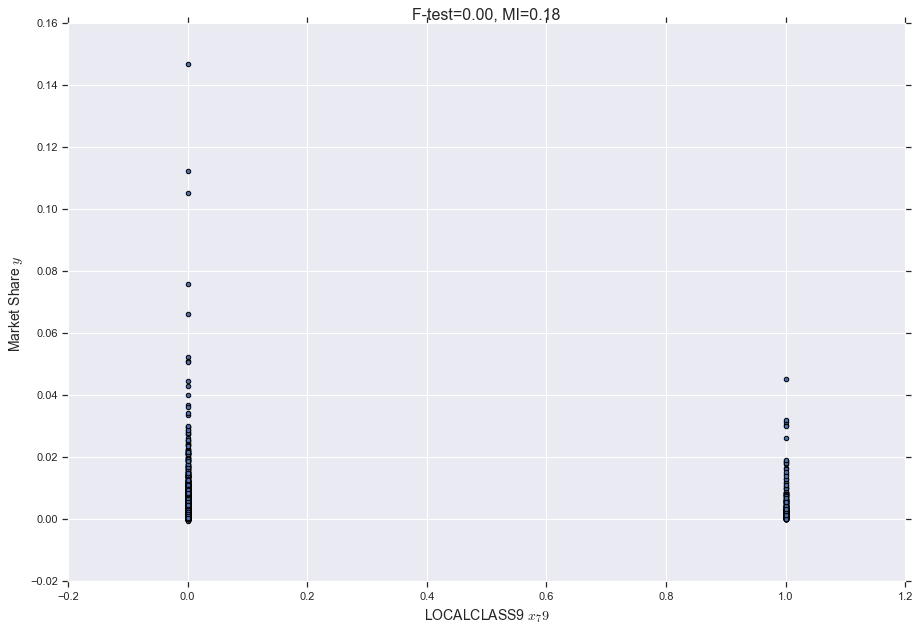

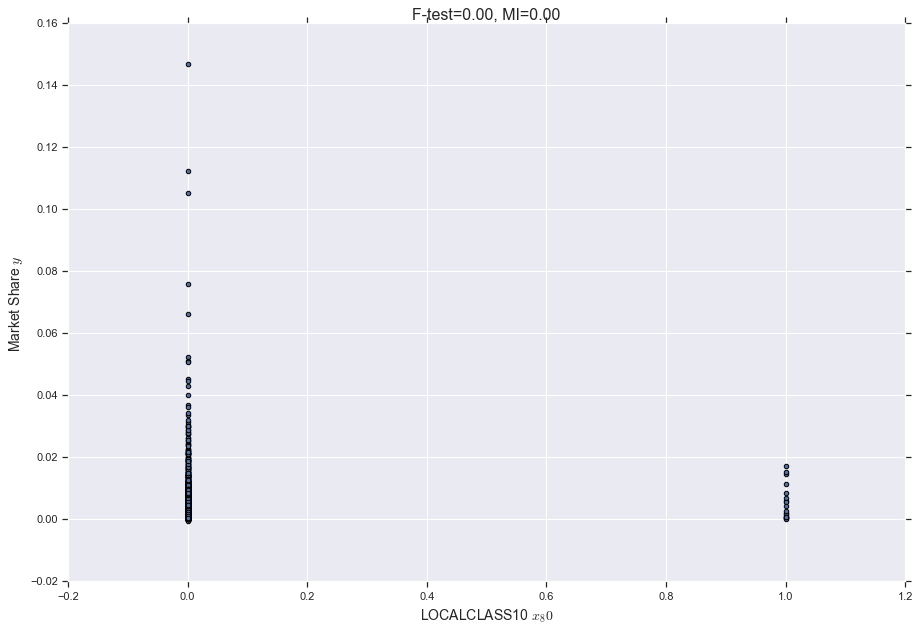

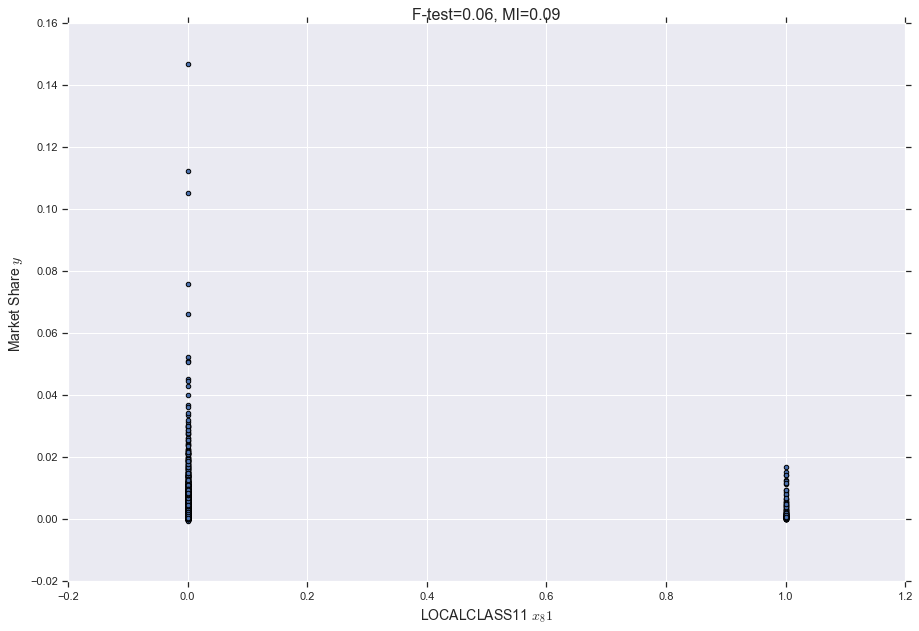

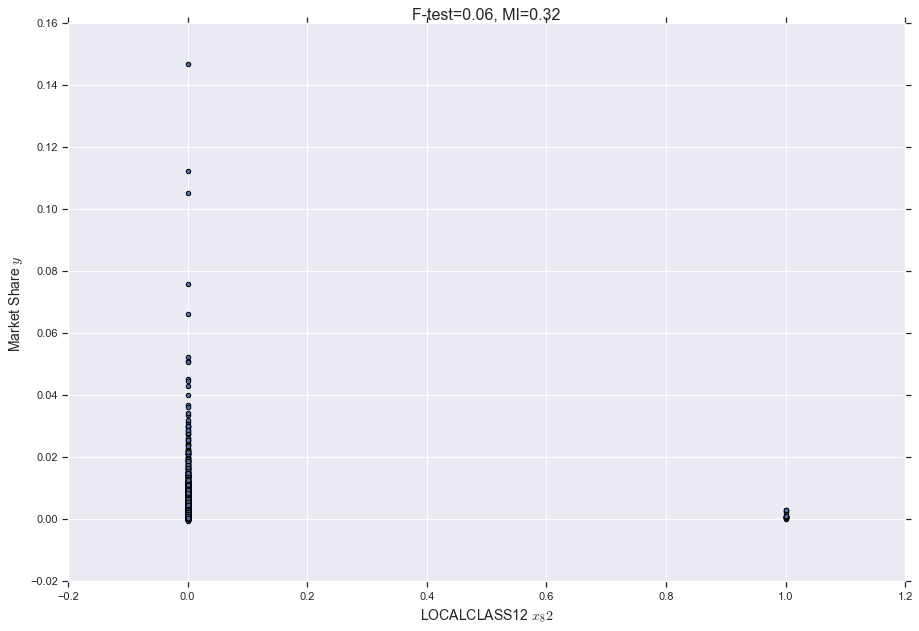

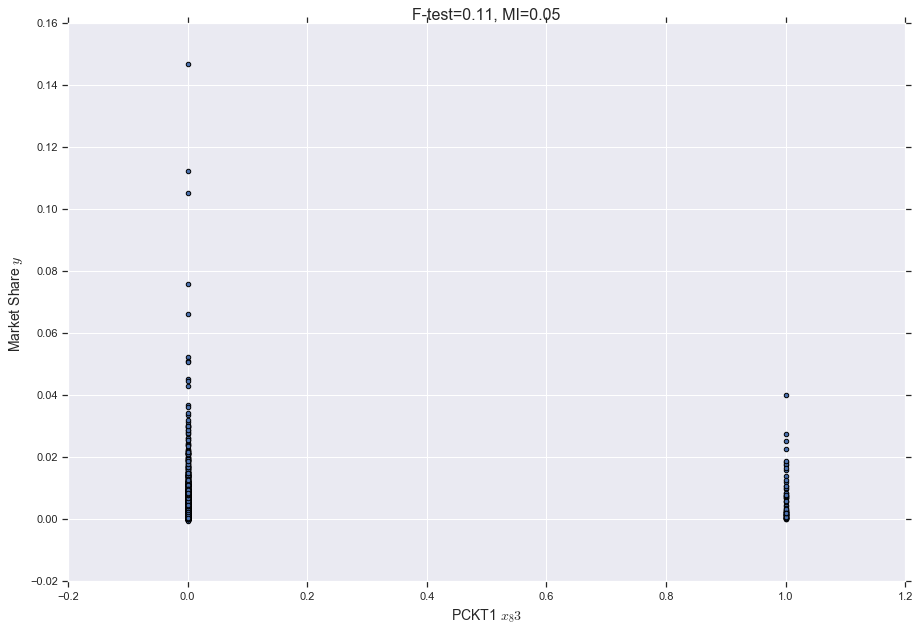

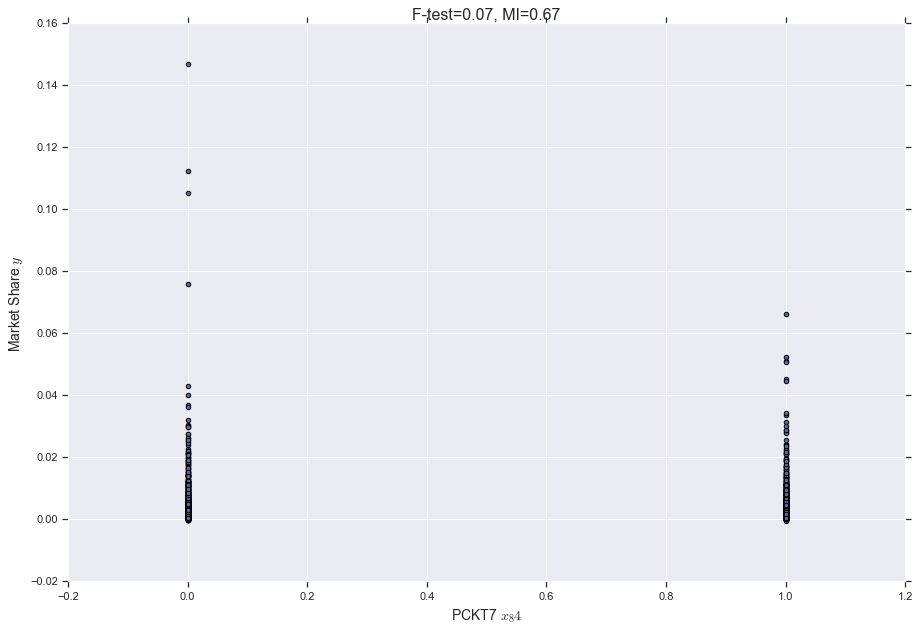

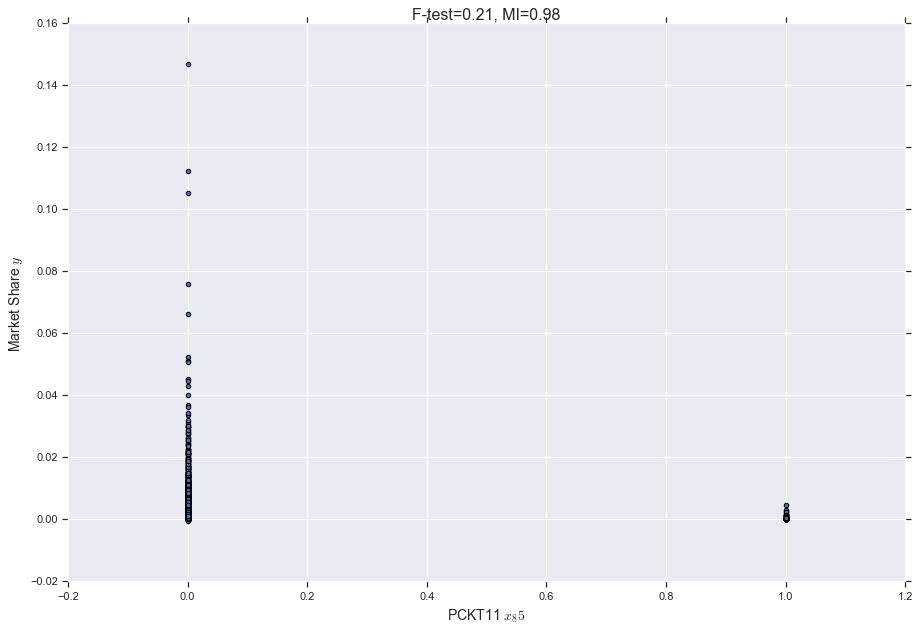

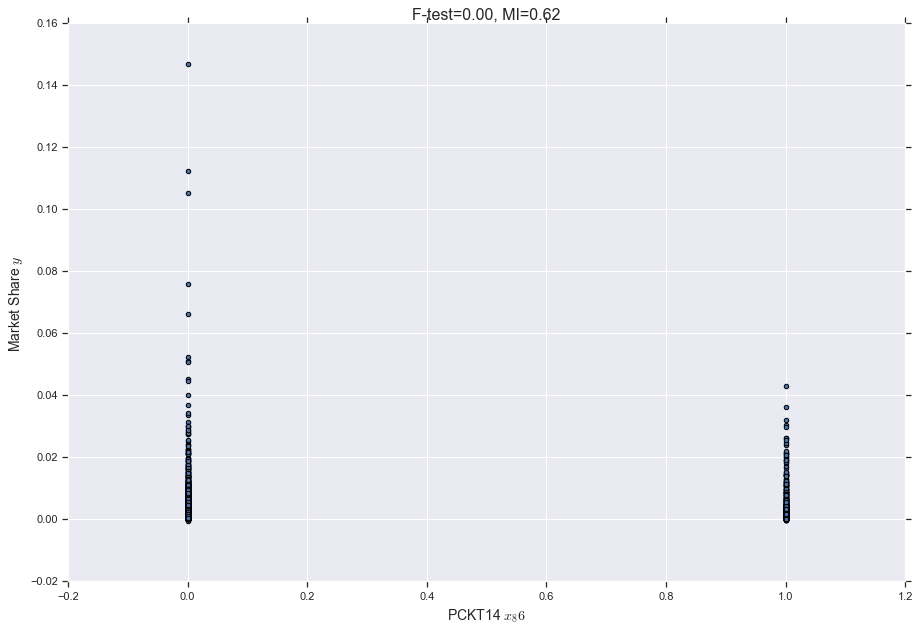

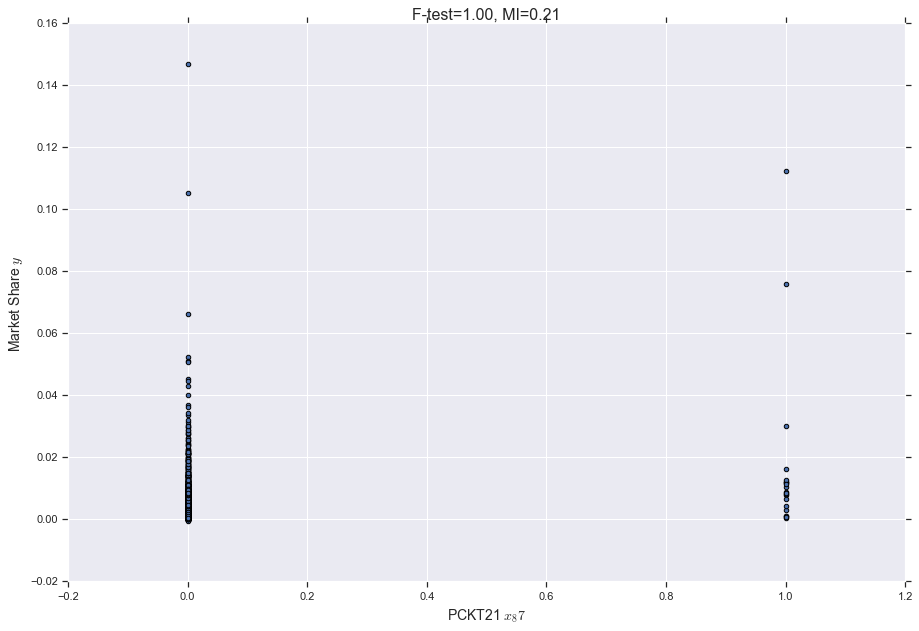

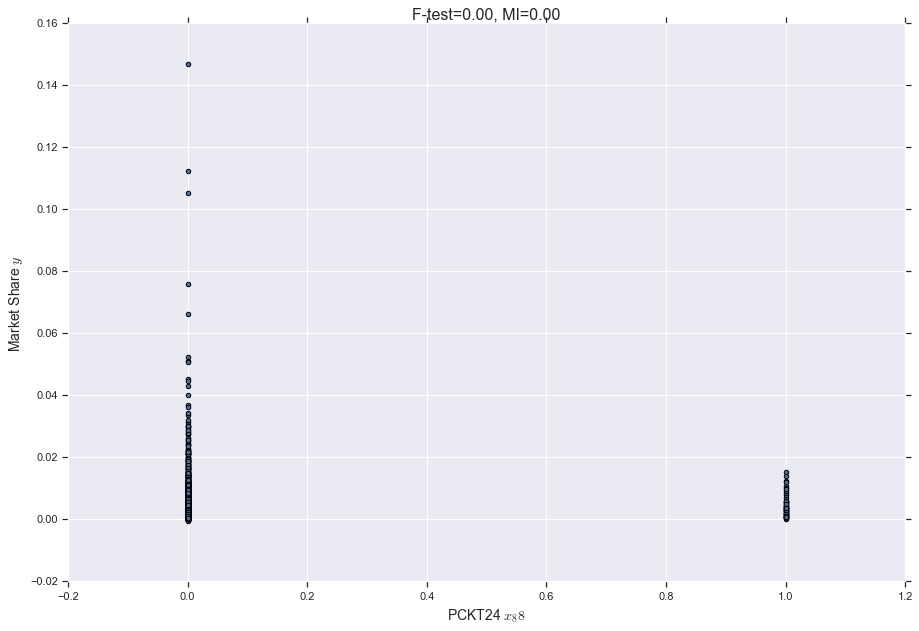

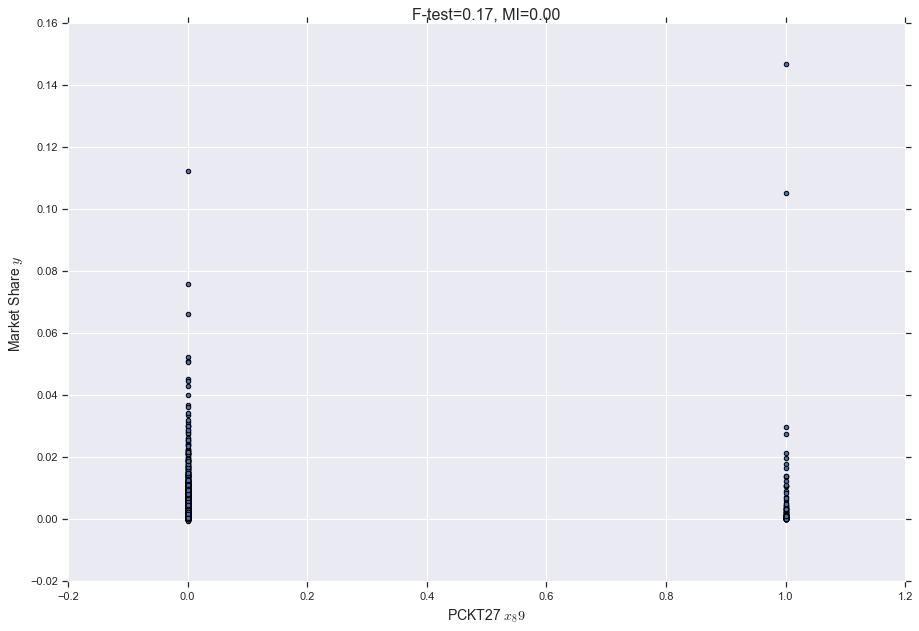

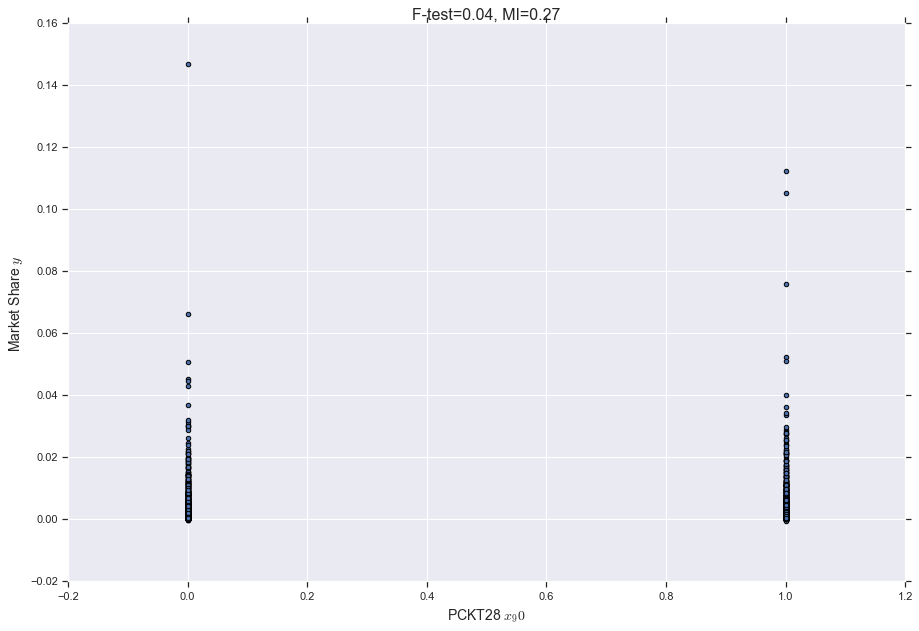

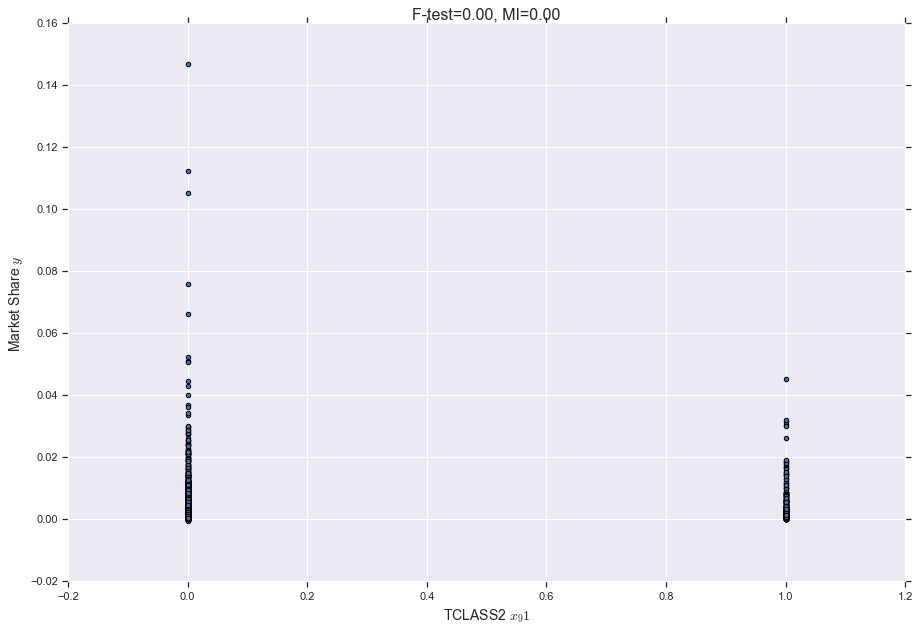

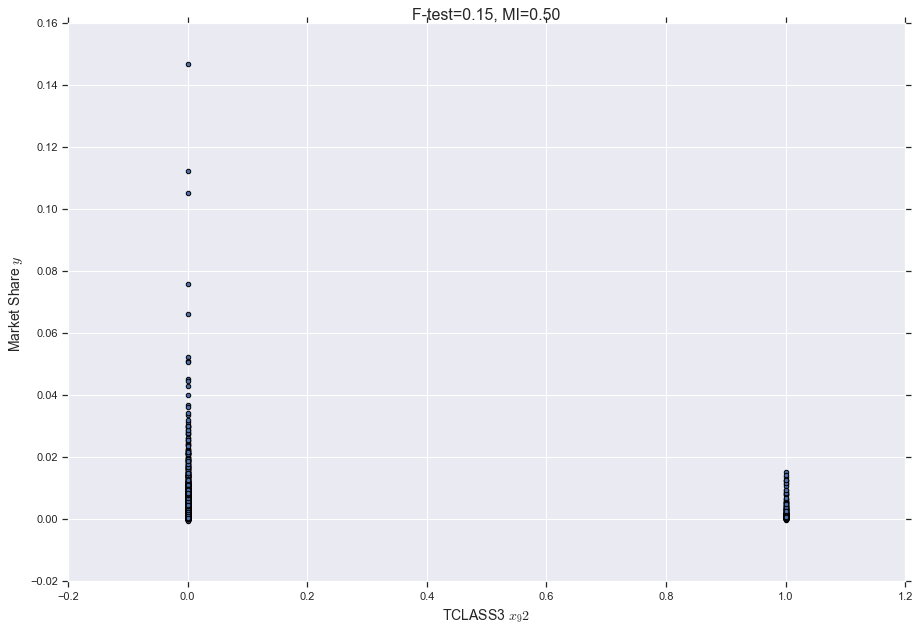

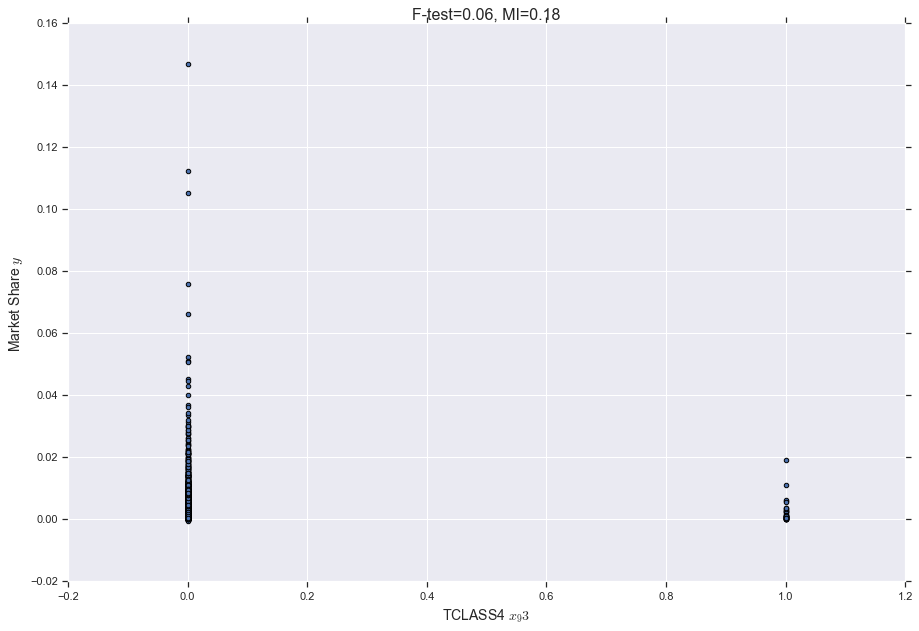

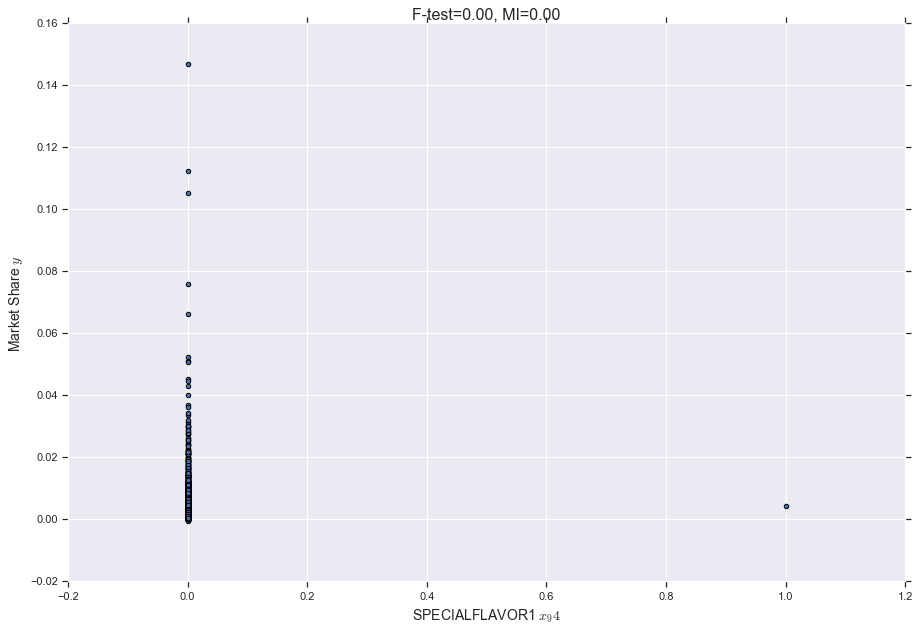

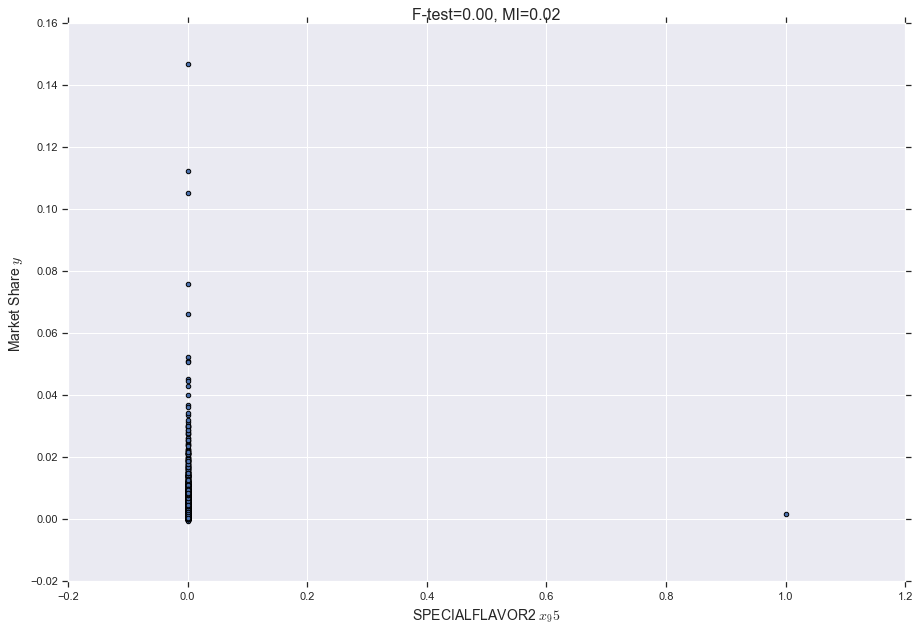

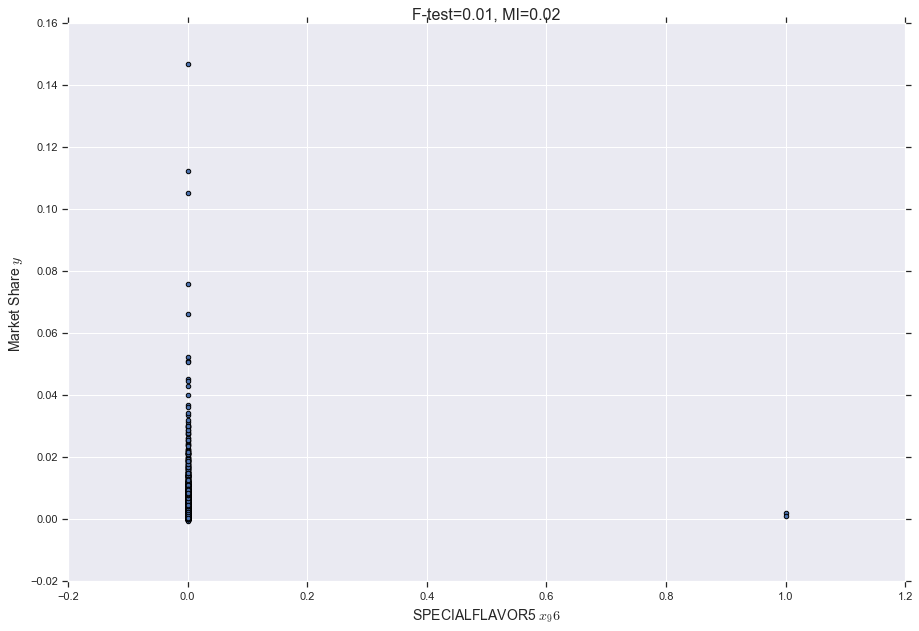

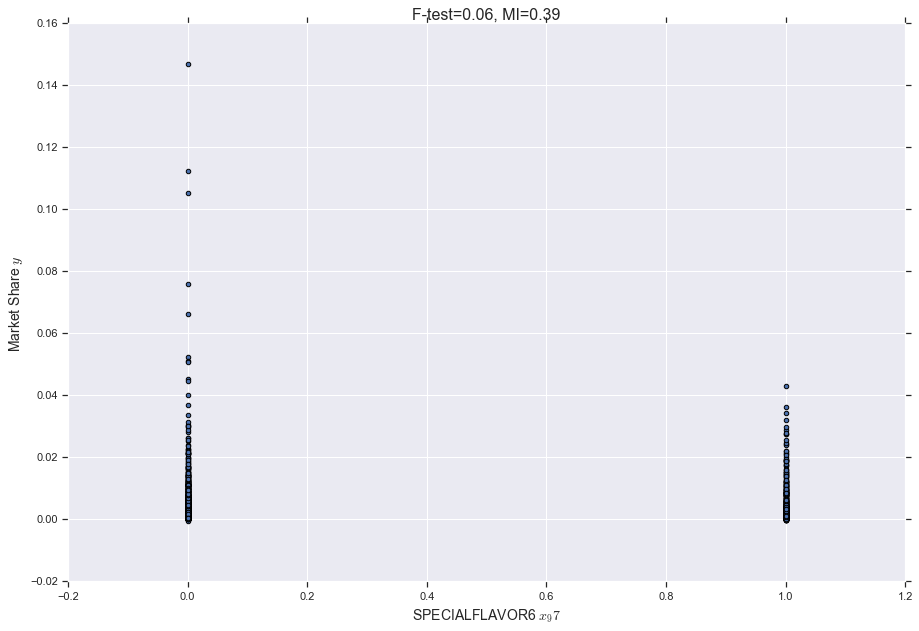

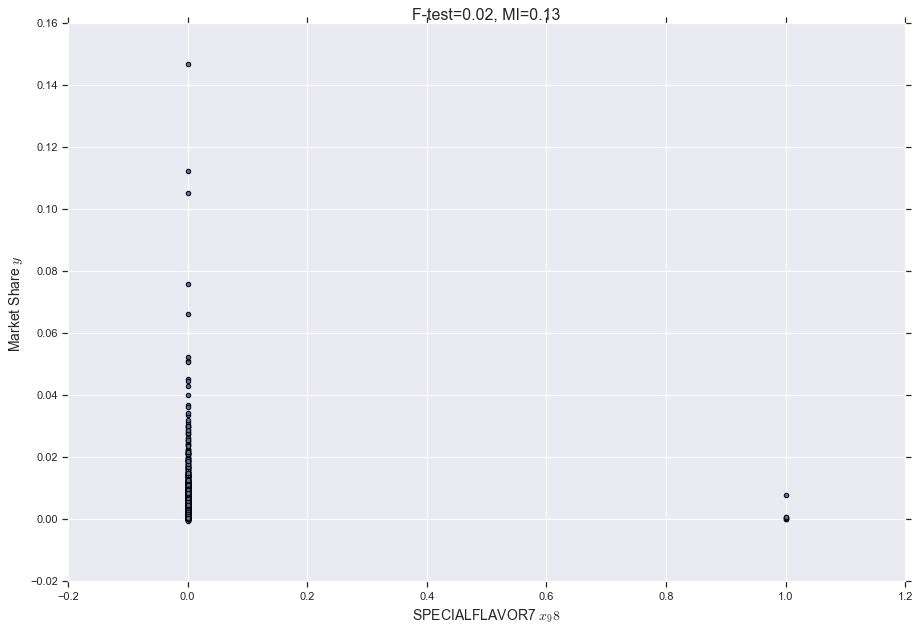

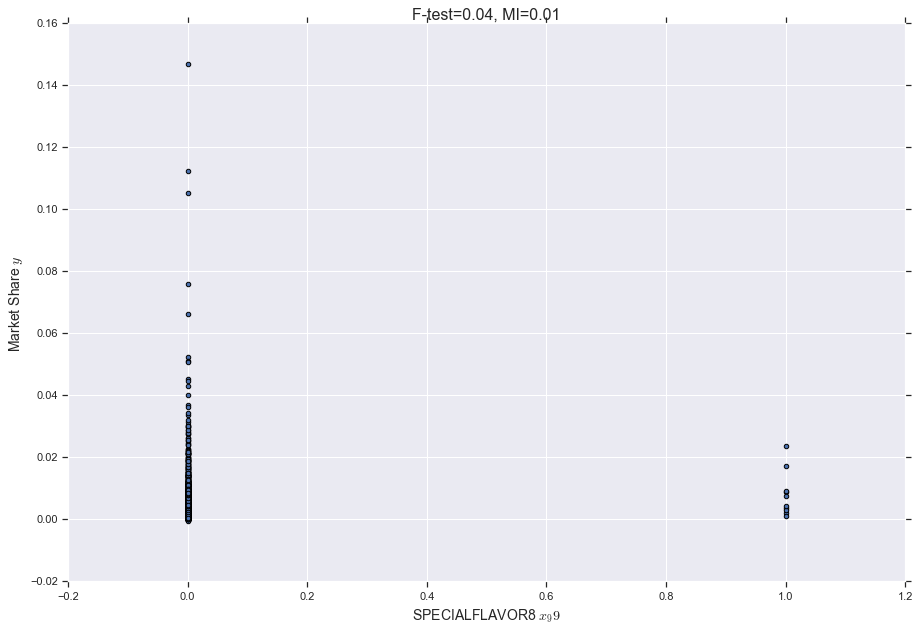

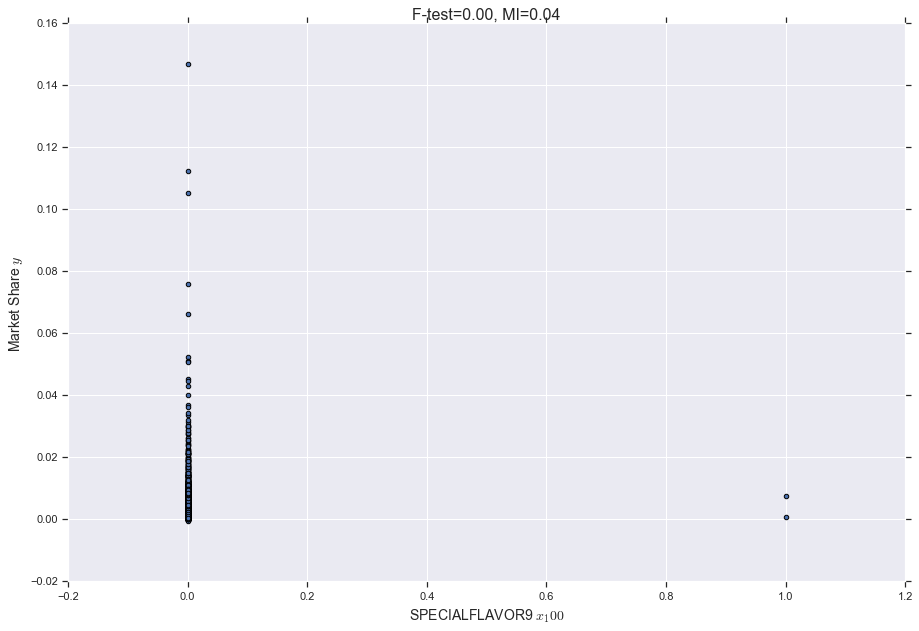

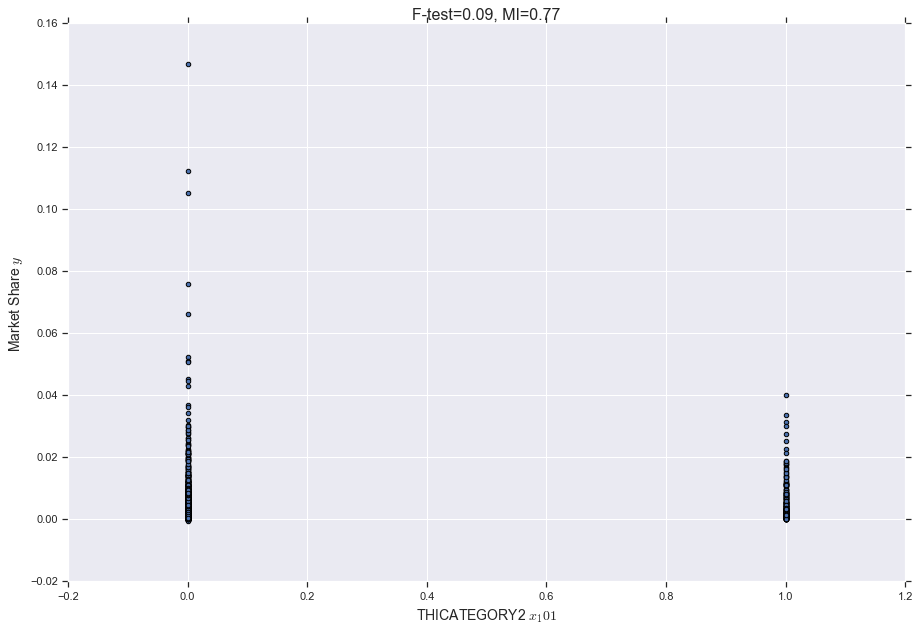

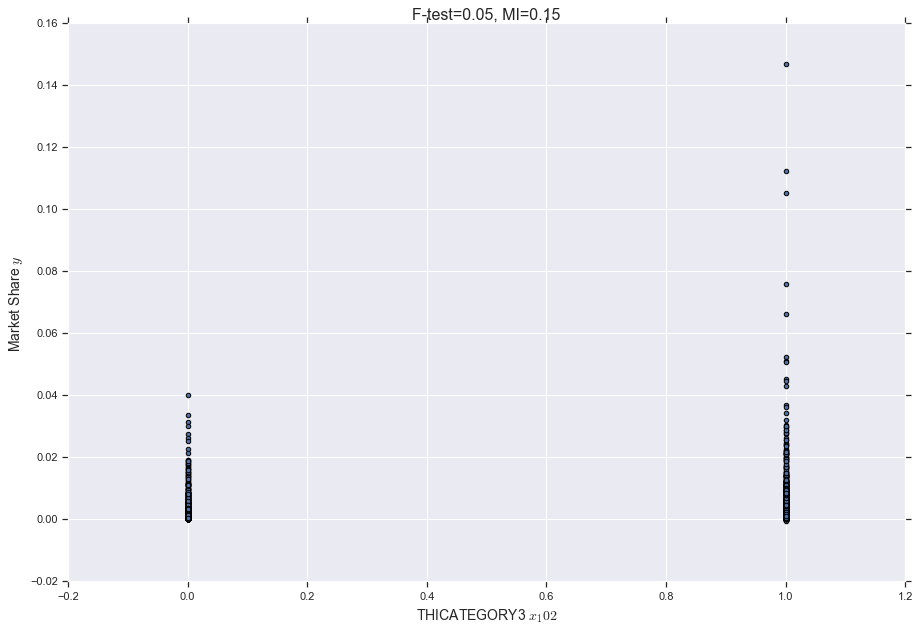

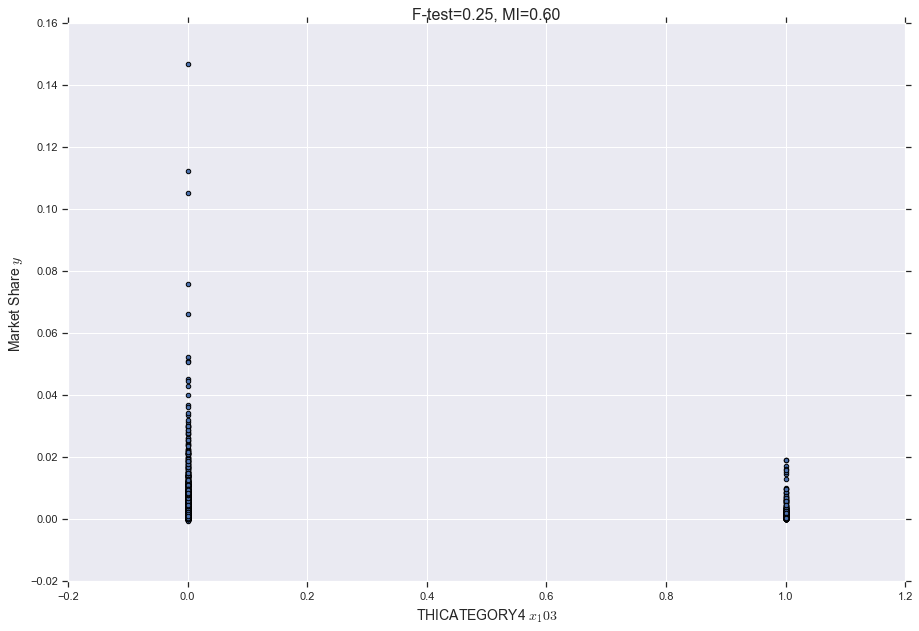

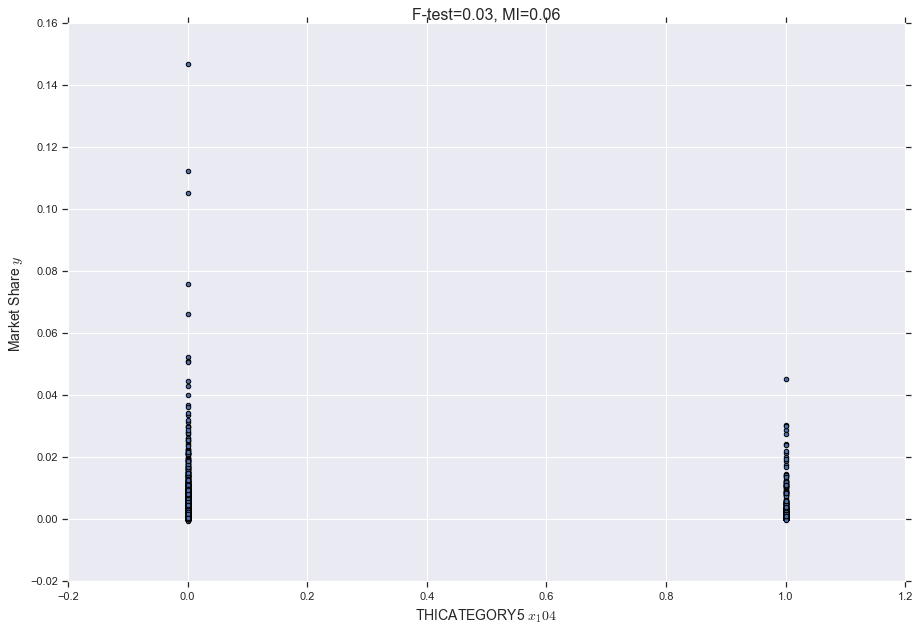

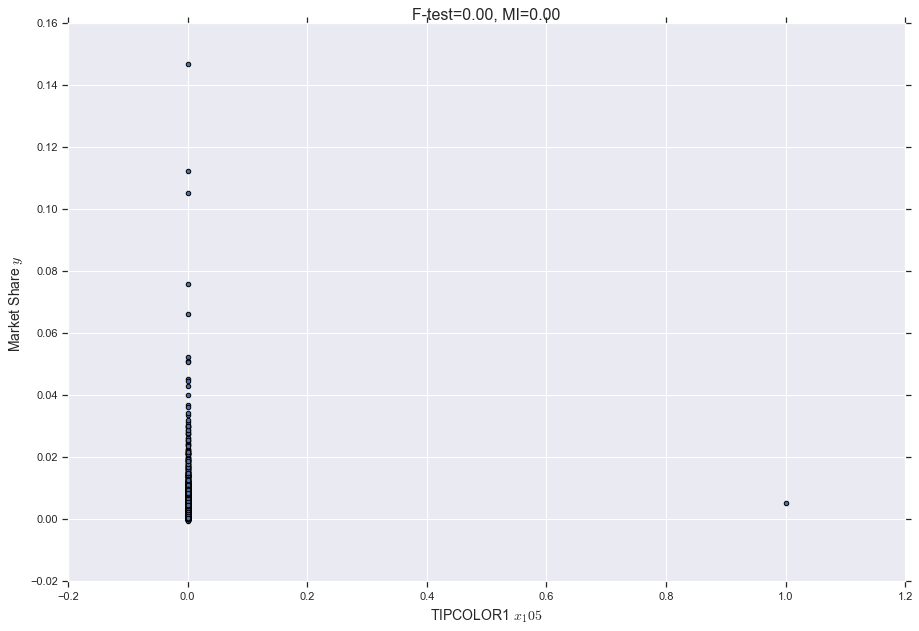

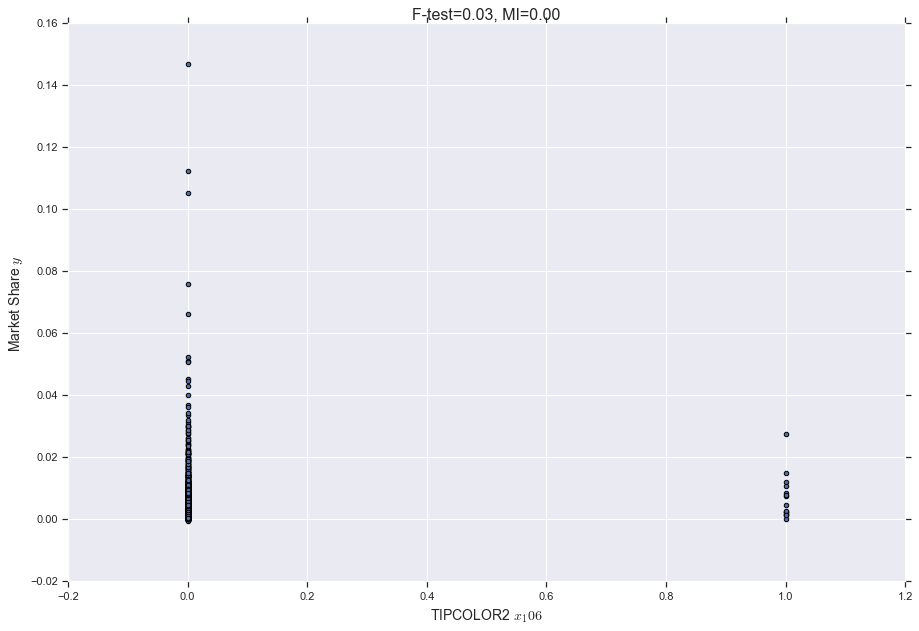

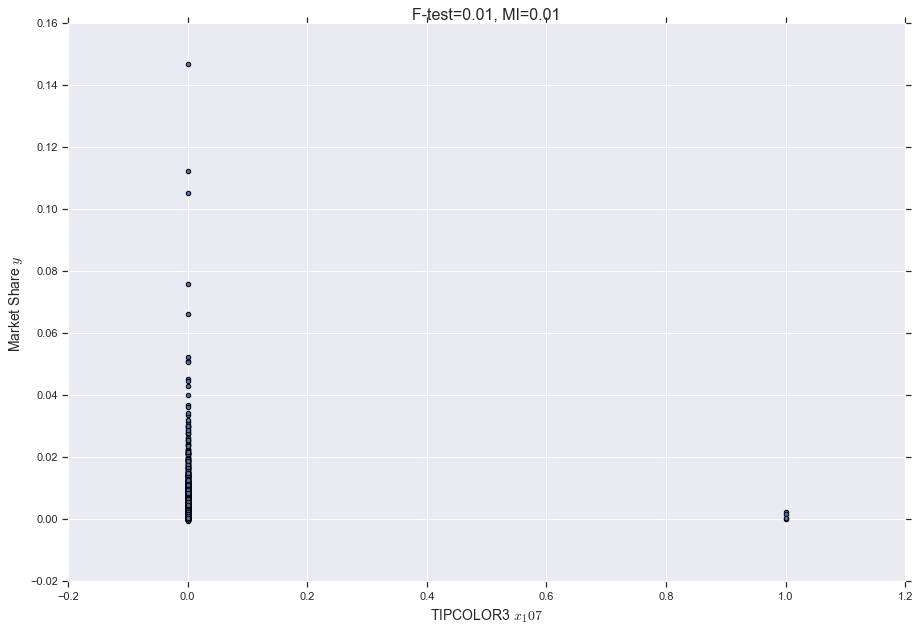

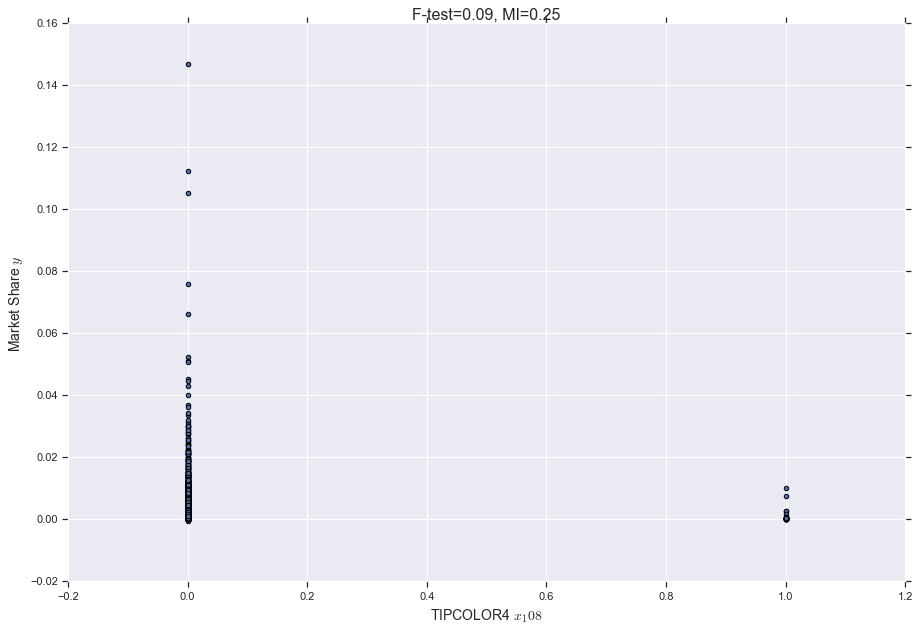

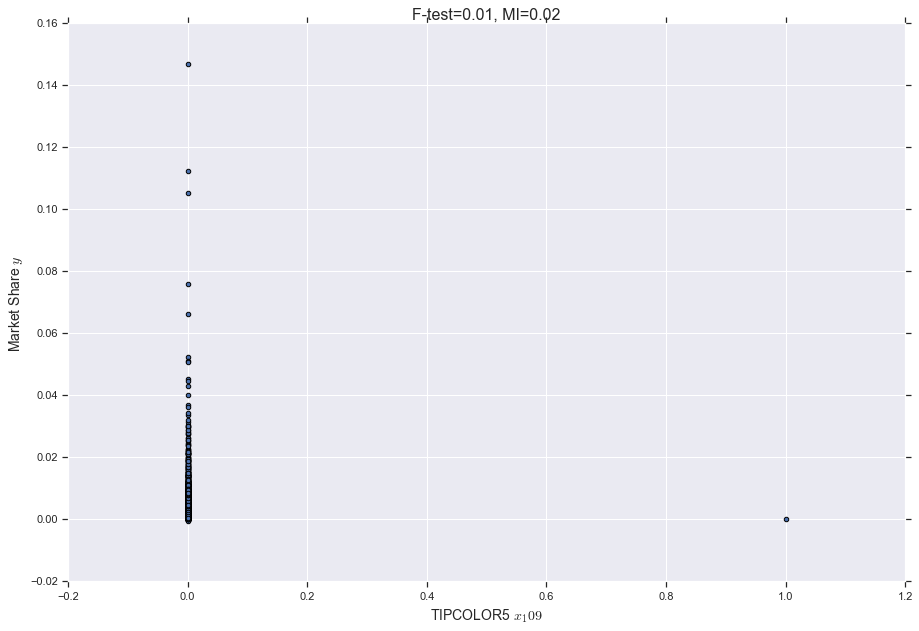

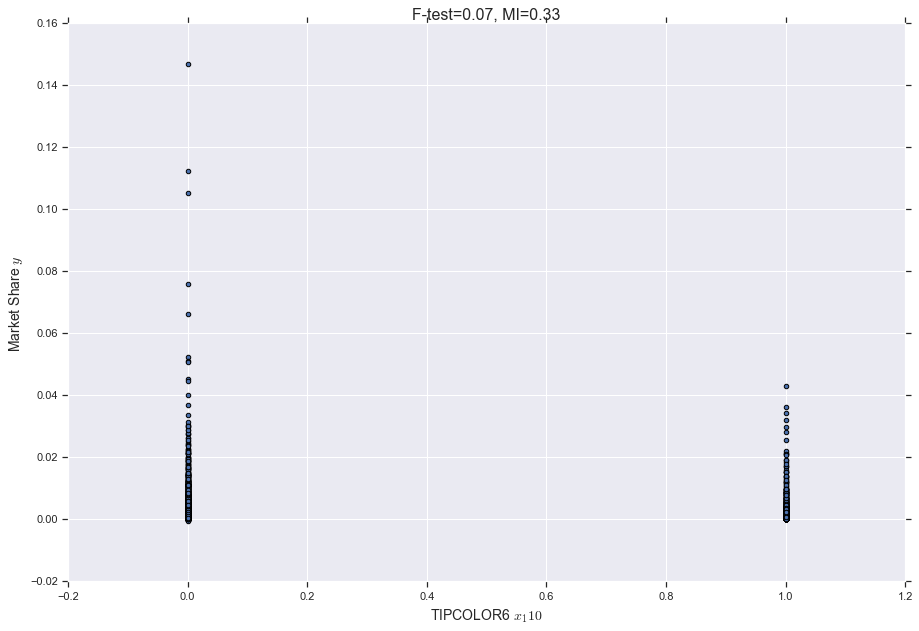

In [109]:
# Scatter plts for each fatures with f test and MI
from sklearn.feature_selection import f_regression, mutual_info_regression

np.random.seed(0)
num = len(df_scaled.columns) - 1

f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)

mi = mutual_info_regression(X, y)
mi /= np.max(mi)

for i in range(num):
    plt.figure(figsize=(15, 10))
    plt.scatter(X[:, i], y, edgecolor='black', s=20)
    plt.xlabel(df_scaled.columns[i]+" $x_{}$".format(i + 1), fontsize=14)
    plt.ylabel("Market Share $y$", fontsize=14)
    plt.title("F-test={:.2f}, MI={:.2f}".format(f_test[i], mi[i]),
              fontsize=16)
    plt.show()

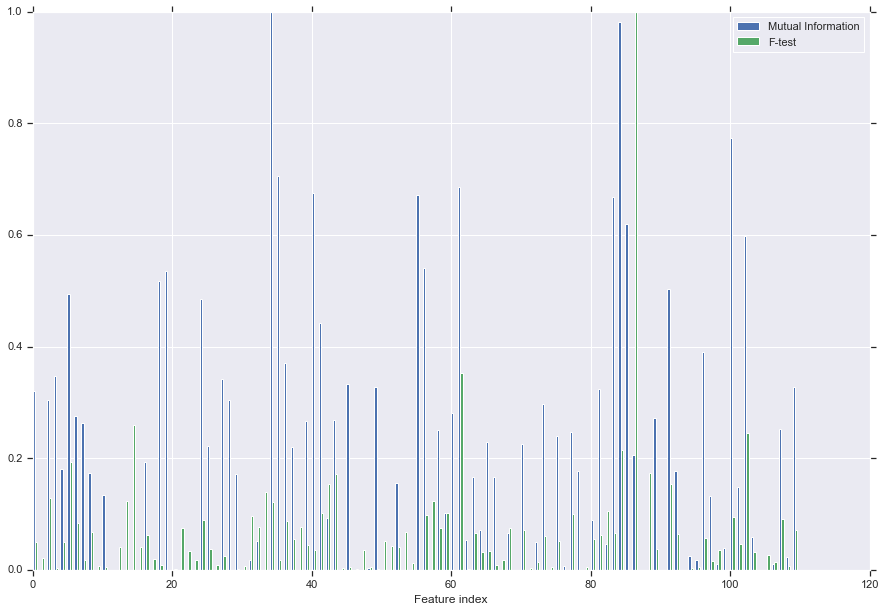

In [110]:
# Plot MI and f test on same graph
plt.figure(figsize=(15, 10))
ax1 = plt.bar(range(num), mi, color='b', width=0.33, )
ax2 = plt.bar(np.array(range(num))+0.33, f_test, color='g', width=0.33)
plt.legend((ax1, ax2), ('Mutual Information', 'F-test'))
plt.xlabel('Feature index')
#plt.savefig('image/MI_ftest.jpg')
plt.show()

In [111]:
# We look fr features not rejecting null hypothesis
relevant = dict()
irrelevant = dict()
for i in range(len(f_test)):
    if f_test[i] < 0.05 and mi[i] < 0.05:
        irrelevant[df_scaled.columns[i]] = f_test[i]
    if f_test[i] > 0.8 :
        relevant[df_scaled.columns[i]] = f_test[i]
    if mi[i] > 0.8:
        relevant[df_scaled.columns[i]] = mi[i]
print('Irrelevant features: ', irrelevant)
print('\nHigh indicators: ', relevant)

Irrelevant features:  {'TCLASS2': 7.122972930120247e-07, 'BRANDDIFFERENTIATOR5': 0.0004498978985636172, 'MARKET4': 0.020197070734461524, 'PCKT24': 0.0001330926394894402, 'LOCALCLASS2': 0.002688780235760907, 'BRANDDIFFERENTIATOR6': 0.04047351000252943, 'PRICECLASSON3': 0.04245433297596282, 'BRANDSUBFAMILYLINE': 0.006400024348415453, 'SPECIALFLAVOR8': 0.03502391763964846, 'LOCALCLASS5': 0.005210039595710002, 'LOCALCLASS10': 0.0048299663260792216, 'SPECIALFLAVOR2': 0.002343999406063333, 'ITEMSCODE20.0': 4.5968304513864454e-06, 'TIPCOLOR1': 0.00011729968539566598, 'MARKET2': 0.040246456708879844, 'ITEMSCODE14.0': 0.01726564251374009, 'LOCALCLASS3': 0.013996304035793616, 'SPECIALFLAVOR9': 0.00011115157239912992, 'TIPCOLOR2': 0.025933754040704235, 'NPLLAUNCHYEAR2': 0.01265714963586363, 'BRANDDIFFERENTIATOR3': 0.007200015591818152, 'BRM3': 0.017167398953205577, 'MARKET7': 0.0022772496637391304, 'TIPCOLOR3': 0.014769618960378624, 'TIPCOLOR5': 0.006540557095809051, 'BRM6': 0.009124506898807219,

In [129]:
# Again remove irrelevant univariate features
df_short = df_scaled.copy()
df_short = df_short.drop(irrelevant.keys(), axis = 1)

## Training <a class="anchor" id="training"></a>  

One can see the problem as a classification or regression task. For the business perspective it is more interesting to provide an actual number instead of a label, i.e. it provides more insight.

### Classification

In [61]:
from sklearn import svm, linear_model, neighbors, ensemble
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix 
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn import metrics
from time import time
from scipy import interp
from sklearn.utils.extmath import density

              precision    recall  f1-score   support

     Failure       0.81      0.99      0.89       274
     Success       0.70      0.10      0.17        70

   micro avg       0.81      0.81      0.81       344
   macro avg       0.76      0.54      0.53       344
weighted avg       0.79      0.81      0.75       344



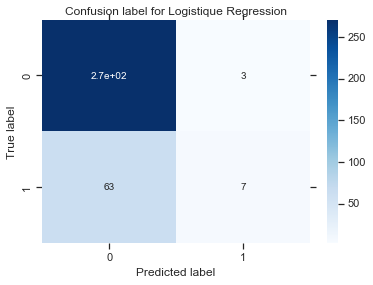

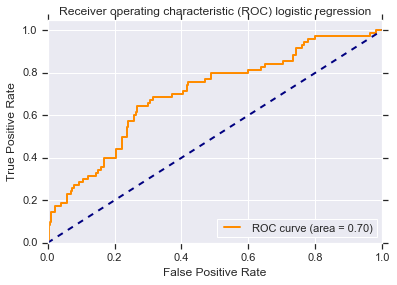

In [399]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

target_names = ['Failure', 'Success']

# Train logistic regression classifier
classifier = linear_model.LogisticRegression(solver='lbfgs', max_iter=1000)
clf = classifier.fit(X_train, y_train)

# Evaluate model
pred_ = clf.predict(X_test)
y_score = clf.predict_proba(X_test)
print(classification_report(y_test, pred_, target_names=target_names))

# Plot confusion matrix
sns.heatmap(confusion_matrix(y_test, pred_), annot=True, cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion label for Logistique Regression')
plt.savefig('image/conf_matrix_logit.png')
plt.show()

# Plot ROC
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) logistic regression')
plt.legend(loc="lower right")
plt.savefig('image/roc_logit.png')
plt.show()

<Container object of 125 artists>

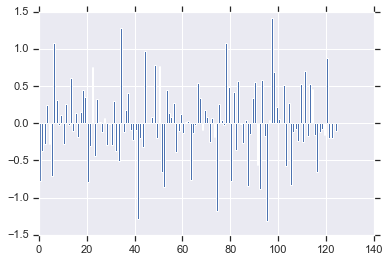

In [400]:
plt.bar(range(len(clf.coef_[0])), clf.coef_[0])

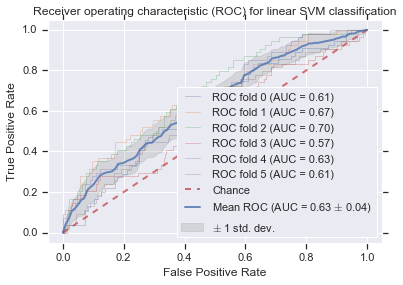

In [401]:
# Linear Support Vector Machine Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)
svc = svm.LinearSVC(max_iter=10000)
classifier = CalibratedClassifierCV(svc, cv=2) 

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) for linear SVM classification')
plt.legend(loc="lower right")
plt.show()

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='sag',
        tol=0.01)
train time: 0.172s
test time:  0.000s
accuracy:   0.132
dimensionality: 125
density: 0.976000
classification report:
              precision    recall  f1-score   support

     Failure       0.81      1.00      0.89       274
     Success       0.83      0.07      0.13        70

   micro avg       0.81      0.81      0.81       344
   macro avg       0.82      0.53      0.51       344
weighted avg       0.81      0.81      0.74       344

confusion matrix:


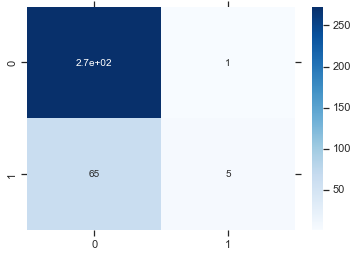


Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=50, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=0.001,
      validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.008s
test time:  0.001s
accuracy:   0.293
dimensionality: 125
density: 0.928000
classification report:
              precision    recall  f1-score   support

     Failure       0.82      0.87      0.85       274
     Success       0.34      0.26      0.29        70

   micro avg       0.75      0.75      0.75       344
   macro avg       0.58      0.56      0.57       344
weighted avg       0.72      0.75      0.73       344

confusion matrix:


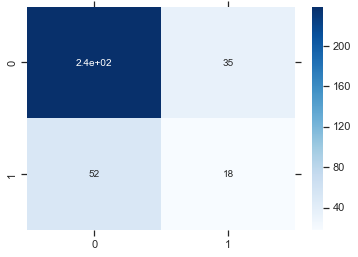


Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
              early_stopping=False, fit_intercept=True, loss='hinge',
              max_iter=50, n_iter=None, n_iter_no_change=5, n_jobs=None,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.011s
test time:  0.000s
accuracy:   0.331
dimensionality: 125
density: 0.960000
classification report:
              precision    recall  f1-score   support

     Failure       0.83      0.89      0.86       274
     Success       0.39      0.29      0.33        70

   micro avg       0.76      0.76      0.76       344
   macro avg       0.61      0.59      0.59       344
weighted avg       0.74      0.76      0.75       344

confusion matrix:


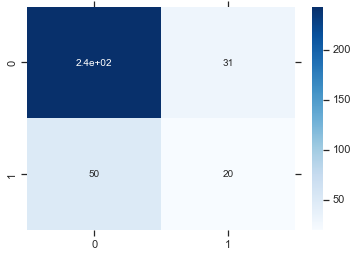


kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='uniform')
train time: 0.017s
test time:  0.183s
accuracy:   0.152
classification report:
              precision    recall  f1-score   support

     Failure       0.81      0.99      0.89       274
     Success       0.67      0.09      0.15        70

   micro avg       0.81      0.81      0.81       344
   macro avg       0.74      0.54      0.52       344
weighted avg       0.78      0.81      0.74       344

confusion matrix:


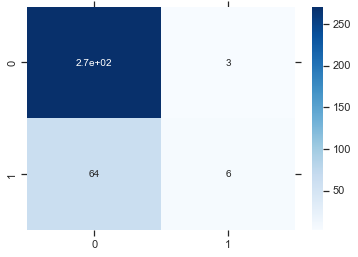


Random forest
________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
train time: 0.430s
test time:  0.025s
accuracy:   0.250
classification report:
              precision    recall  f1-score   support

     Failure       0.82      0.97      0.89       274
     Success       0.61      0.16      0.25        70

   micro avg       0.81      0.81      0.81       344
   macro avg       0.72      0.57      0.57       344
weighted avg       0.78      0.81      0.76       344

confusion matrix:


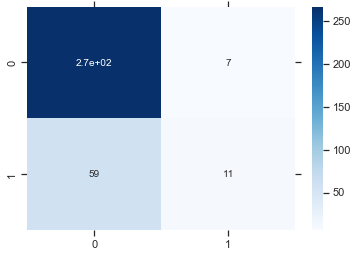


L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
     verbose=0)
train time: 0.035s
test time:  0.000s
accuracy:   0.177
dimensionality: 125
density: 0.976000
classification report:
              precision    recall  f1-score   support

     Failure       0.81      0.99      0.89       274
     Success       0.78      0.10      0.18        70

   micro avg       0.81      0.81      0.81       344
   macro avg       0.79      0.55      0.54       344
weighted avg       0.80      0.81      0.75       344

confusion matrix:


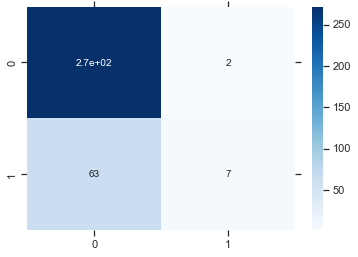


________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=50,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.032s
test time:  0.000s
accuracy:   0.419
dimensionality: 125
density: 0.968000
classification report:
              precision    recall  f1-score   support

     Failure       0.85      0.83      0.84       274
     Success       0.40      0.44      0.42        70

   micro avg       0.75      0.75      0.75       344
   macro avg       0.63      0.64      0.63       344
weighted avg       0.76      0.75      0.75       344

confusion matrix:


C:\Users\Louis\AppData\Roaming\Python\Python35\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


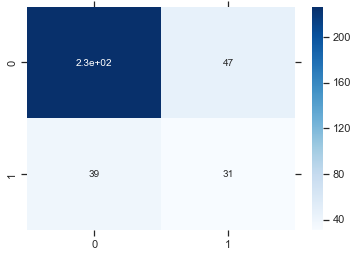


L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.001,
     verbose=0)


C:\Users\Louis\AppData\Roaming\Python\Python35\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.289s
test time:  0.000s
accuracy:   0.177
dimensionality: 125
density: 0.736000
classification report:
              precision    recall  f1-score   support

     Failure       0.81      0.99      0.89       274
     Success       0.78      0.10      0.18        70

   micro avg       0.81      0.81      0.81       344
   macro avg       0.79      0.55      0.54       344
weighted avg       0.80      0.81      0.75       344

confusion matrix:


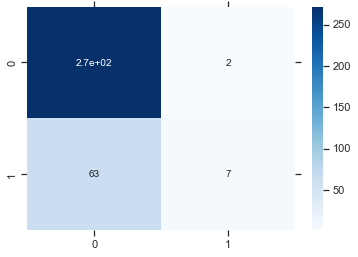


________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=50,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.095s
test time:  0.000s
accuracy:   0.242
dimensionality: 125
density: 0.696000
classification report:
              precision    recall  f1-score   support

     Failure       0.82      0.94      0.87       274
     Success       0.41      0.17      0.24        70

   micro avg       0.78      0.78      0.78       344
   macro avg       0.61      0.55      0.56       344
weighted avg       0.73      0.78      0.74       344

confusion matrix:


C:\Users\Louis\AppData\Roaming\Python\Python35\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


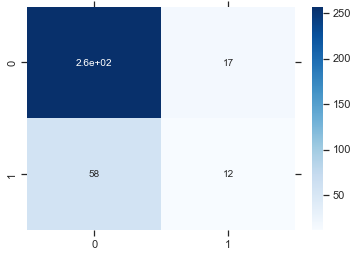


Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=50,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.103s
test time:  0.000s
accuracy:   0.336
dimensionality: 125
density: 0.848000
classification report:
              precision    recall  f1-score   support

     Failure       0.83      0.91      0.87       274
     Success       0.44      0.27      0.34        70

   micro avg       0.78      0.78      0.78       344
   macro avg       0.64      0.59      0.60       344
weighted avg       0.75      0.78      0.76       344

confusion matrix:


C:\Users\Louis\AppData\Roaming\Python\Python35\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


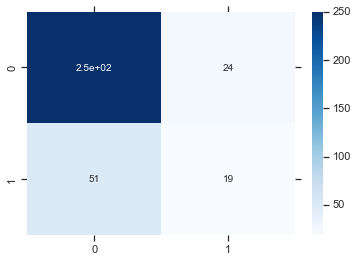


NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_threshold=None)
train time: 0.003s
test time:  0.001s
accuracy:   0.356
classification report:
              precision    recall  f1-score   support

     Failure       0.84      0.63      0.72       274
     Success       0.27      0.53      0.36        70

   micro avg       0.61      0.61      0.61       344
   macro avg       0.55      0.58      0.54       344
weighted avg       0.72      0.61      0.65       344

confusion matrix:


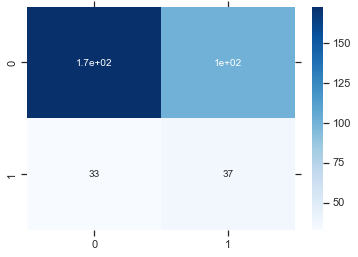


LinearSVC with L1-based feature selection
________________________________________________________________________________
Training: 
Pipeline(memory=None,
     steps=[('feature_selection', SelectFromModel(estimator=LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.001,
     verbose=0),
        max_features=None, no...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])


C:\Users\Louis\AppData\Roaming\Python\Python35\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.525s
test time:  0.001s
accuracy:   0.177
classification report:
              precision    recall  f1-score   support

     Failure       0.81      0.99      0.89       274
     Success       0.78      0.10      0.18        70

   micro avg       0.81      0.81      0.81       344
   macro avg       0.79      0.55      0.54       344
weighted avg       0.80      0.81      0.75       344

confusion matrix:


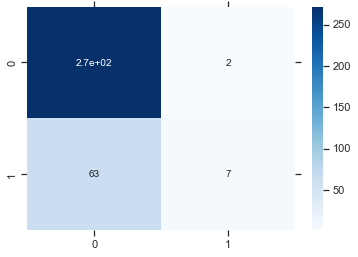

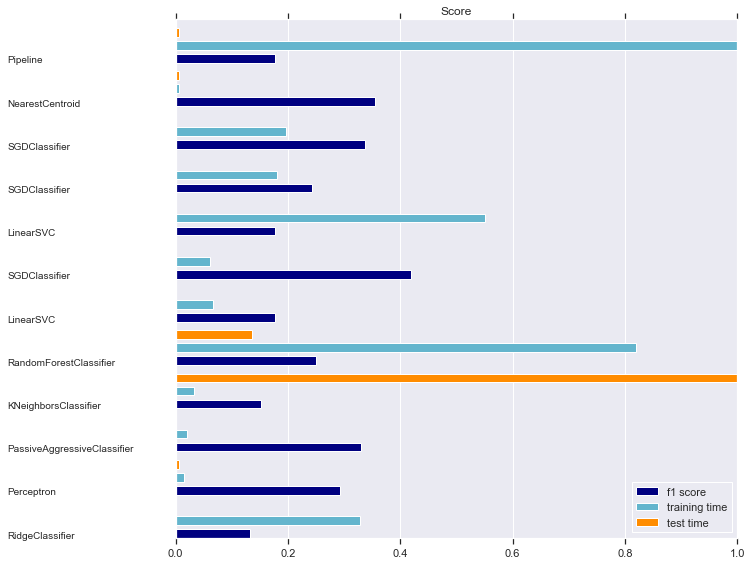

In [402]:
# #############################################################################
# Benchmark classifiers
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.f1_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

    print("classification report:")
    print(metrics.classification_report(y_test, pred,
                                            target_names=target_names))

    print("confusion matrix:")
    plt.figure()
    sns.heatmap(confusion_matrix(y_test, pred), annot=True, cmap='Blues')
    plt.savefig('image/conf/'+str(t0)+'.jpg')
    plt.show()
    
    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        (linear_model.RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
        (linear_model.Perceptron(max_iter=50, tol=1e-3), "Perceptron"),
        (linear_model.PassiveAggressiveClassifier(max_iter=50, tol=1e-3),
         "Passive-Aggressive"),
        (neighbors.KNeighborsClassifier(n_neighbors=10), "kNN"),
        (ensemble.RandomForestClassifier(n_estimators=100), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(svm.LinearSVC(penalty=penalty, dual=False,
                                       tol=1e-3)))

    # Train SGD model
    results.append(benchmark(linear_model.SGDClassifier(alpha=.0001, max_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(linear_model.SGDClassifier(alpha=.0001, max_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(neighbors.NearestCentroid()))
'''
# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))
results.append(benchmark(ComplementNB(alpha=.1)))
'''

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(svm.LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', svm.LinearSVC(penalty="l2"))])))

# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="f1 score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)
plt.savefig('image/classification_models.jpg')
plt.show()

### Regression

#### OLS

We first randomly split training and test set (80%/20%).

In [130]:
# Labels are continuous values
X = df_short.drop('Market_Share', axis = 1).as_matrix()
y = np.array(df_var['Market_Share'])

C:\Users\Louis\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


In [141]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

preds = reg.predict(X_test)

mae = mean_absolute_error(y_true=y_test, y_pred=preds)
r2 = r2_score(y_true=y_test, y_pred=preds)
mse = mean_squared_error(y_true=y_test, y_pred=preds)

print('mae :', mae)
print('R2 :', r2)
print('mse :', mse)

mae : 0.00395060621321261
R2 : -0.039613757292478624
mse : 3.303826123762131e-05


In [132]:
# Check for errors in coefficients
for i, c in enumerate(reg.coef_):
    if c > 10 or -10 > c:
        print(df_scaled.columns[i])

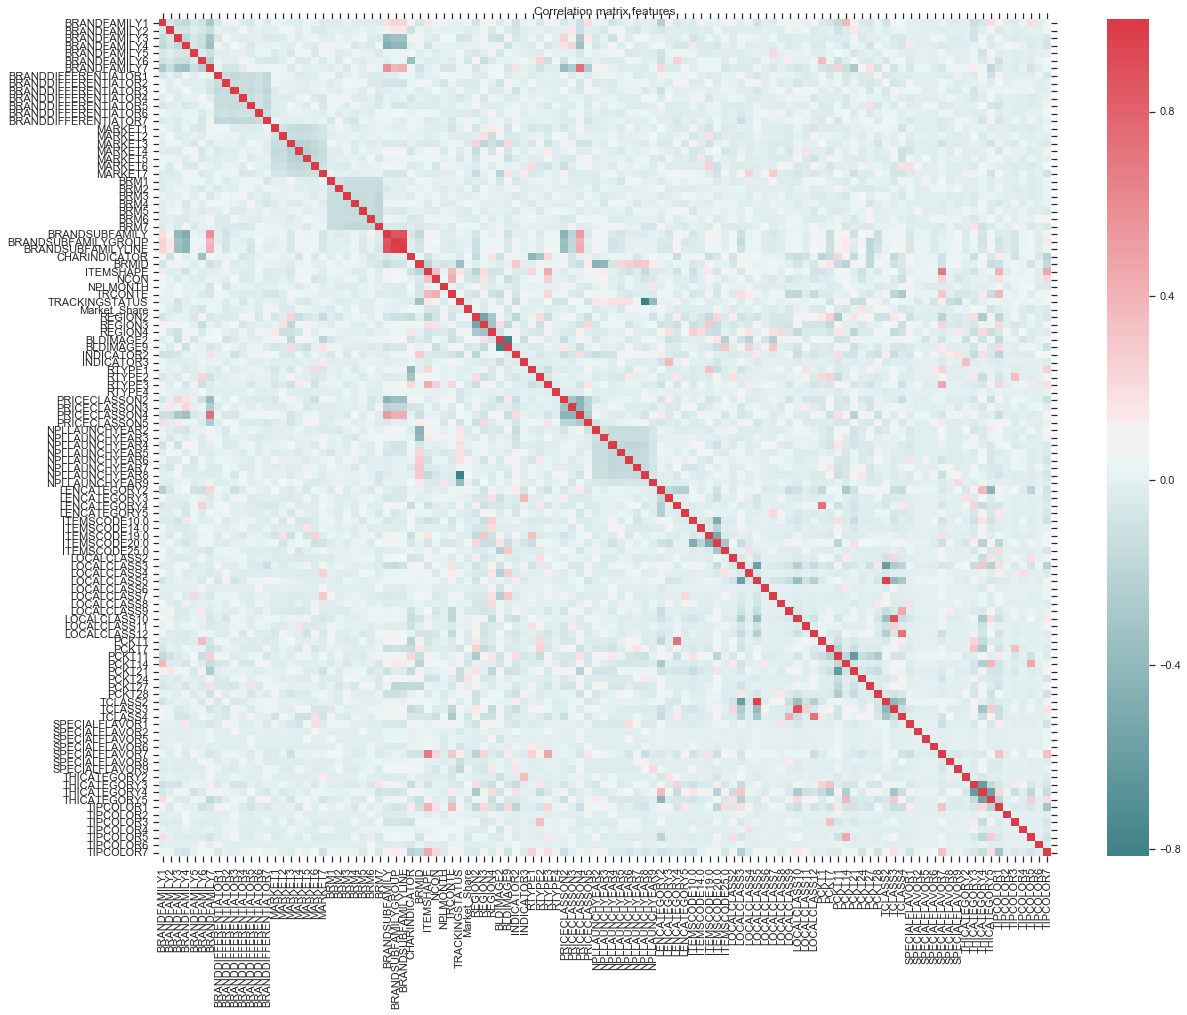

x                   y      corr
0  BRANDSUBFAMILYGROUP  BRANDSUBFAMILYLINE  0.965622
1          LOCALCLASS5             TCLASS2  0.967810

In [133]:
corr = pd.DataFrame(df_scaled).corr()
dispCorr(corr)

We test the robustness by doing a 5-Fold cross validation (again randomly shuffled).

In [148]:
from sklearn.model_selection import cross_validate, ShuffleSplit

# score with MSE and R2
scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']

# CV with OLS
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
reg = linear_model.BayesianRidge()

cv_results = cross_validate(reg, X, y,
                            scoring=scoring, cv=cv, return_train_score=False)

In [149]:
for score in cv_results:
    print('%s %0.3f +- %0.3f' % (score, cv_results[score].mean()*100, cv_results[score].std()*100))

test_neg_mean_squared_error -0.009 +- 0.003
fit_time 2.778 +- 0.213
test_r2 2.656 +- 3.075
score_time 0.260 +- 0.049
test_neg_mean_absolute_error -0.437 +- 0.032


In [139]:
from sklearn.feature_selection import SelectKBest

k = [5, 10, 20, 30, 40, X.shape[1]]
for n in k:
    print('Taking %d best features' % (n))
    X_transformed = SelectKBest(f_regression, k=n).fit_transform(X, y)
    cv_results = cross_validate(reg, X_transformed, y,
                            scoring=scoring, cv=cv, return_train_score=False)
    for score in cv_results:
        print('%s %0.3f +- %0.3f' % (score, cv_results[score].mean()*100, cv_results[score].std()*100))
    print()

Taking 5 best features
test_neg_mean_squared_error -0.009 +- 0.004
fit_time 0.180 +- 0.040
test_r2 1.985 +- 1.059
score_time 0.200 +- 0.089
test_neg_mean_absolute_error -0.438 +- 0.038

Taking 10 best features
test_neg_mean_squared_error -0.009 +- 0.004
fit_time 0.200 +- 0.000
test_r2 3.336 +- 1.632
score_time 0.200 +- 0.000
test_neg_mean_absolute_error -0.436 +- 0.038

Taking 20 best features
test_neg_mean_squared_error -0.009 +- 0.003
fit_time 0.360 +- 0.049
test_r2 2.751 +- 3.936
score_time 0.160 +- 0.049
test_neg_mean_absolute_error -0.437 +- 0.034

Taking 30 best features
test_neg_mean_squared_error -0.008 +- 0.003
fit_time 0.480 +- 0.040
test_r2 3.459 +- 3.890
score_time 0.280 +- 0.040
test_neg_mean_absolute_error -0.435 +- 0.033

Taking 40 best features
test_neg_mean_squared_error -0.008 +- 0.003
fit_time 0.660 +- 0.049
test_r2 3.303 +- 4.874
score_time 0.280 +- 0.040
test_neg_mean_absolute_error -0.439 +- 0.030

Taking 75 best features
test_neg_mean_squared_error -0.009 +- 0.00

Given poor results and the following plots, Linear regression is a bad estimator.

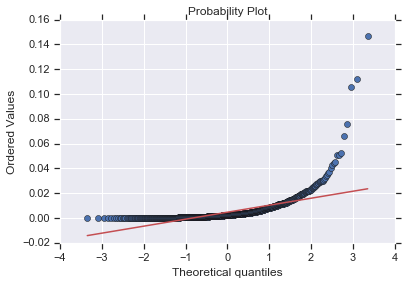

In [147]:
import scipy.stats as stats
import pylab

stats.probplot(y, dist='norm', plot=pylab)
pylab.show()

## Evaluation <a class="anchor" id="evaluation"></a>

## Scoring <a class="anchor" id="scoring"></a>